## Prepare Data

In [162]:
import math
import torch
from matplotlib import pyplot as plt
%matplotlib inline

import os
import pandas as pd
from pandas import factorize
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from scipy import stats

In [175]:
import re
os.chdir('/Users/chenya68/Documents/GitHub/BFO')
#df = pd.read_excel('data/mk-6204-data.xlsx',sheet_name = 0)
df = pd.read_excel('data/mk-6204-data-adj.xlsx',sheet_name = 0)
df.columns = [re.sub('[^A-Za-z0-9Δ%]+', '_', element) for element in df.columns]
df.columns  = [re.sub('%','_PCT',element) for element in df.columns]
print(len(df))
df.head()

279


,Study,ELN_,Protein_concentration_mg_ml_,Protein_concentration_mg_ml_measured,Buffer,Buffer_strength_mM_,pH_theoretical,pH_Actual,Excipients,Sugar_type,...,KL610348_ug_mg_,Other_impurities_ug_ml_,icief_Peak1_PCT,icief_Peak2_PCT,icief_Peak3_PCT,icief_Peak4_PCT,icief_Peak5_PCT,icief_Peak6_PCT,Bioassay,Binding
0,Preliminary pH range screening study for ADC,NaN,5,NaN,Acetate,20,4.0,NaN,NaN,NaN,...,0.3,0.8,5.3,11.3,27.2,33.7,20.5,1.9,NaN,NaN
1,Preliminary pH range screening study for ADC,NaN,5,NaN,Acetate,20,5.0,NaN,NaN,NaN,...,0.3,0.7,6.1,2,12.2,28.3,32.5,19.1,NaN,NaN
2,Preliminary pH range screening study for ADC,NaN,5,NaN,NaN,20,6.0,NaN,NaN,NaN,...,0.2,0.7,7.1,2.6,14.2,29.6,30.6,16,NaN,NaN
3,Preliminary pH range screening study for ADC,NaN,5,NaN,Phosphate,20,7.0,NaN,NaN,NaN,...,0.3,0.6,3.4,8.9,17.2,31.2,26.6,12.7,NaN,NaN
4,Preliminary pH range screening study for ADC,NaN,5,NaN,Phosphate,20,8.0,NaN,NaN,NaN,...,0.3,0.8,17.4,26.6,27.7,18.2,8.3,1.8,NaN,NaN


In [176]:
cols_group = ['Stress_type','Condition_Agitation_FT_5C1M_etc_']
cols_feature00 = ['Protein_concentration_mg_ml_','Buffer','Buffer_strength_mM_',
                 'pH_theoretical','Sugar_type', 'Sugar_PCT','Surfactant_type', 
                 'Surfactant_w_v__PCT', 'NaCl_mM_',
                 'Temperature_C_', 'Duration', 'Duration_unit']
cols_feature01 = ['Protein_concentration_mg_ml_','Buffer','Buffer_strength_mM_',
                 'pH_theoretical','Sugar_type', 'Sugar_PCT','Surfactant_type', 
                 'Surfactant_w_v__PCT']
cols_cate = ['Buffer','Sugar_type', 'Surfactant_type']
cols_target0 = ['SEC_HMW_PCT','SEC_Monomer_PCT', 'SEC_LMW_PCT', 
               'NR_CE_SDS_HLC_HHC_HHLC_PCT','NR_CE_SDS_LC_HC_PCT', 'NR_CE_SDS_Others_PCT']
#cols_target = ['SEC_HMW_PCT','SEC_Monomer_PCT', 
#               'NR_CE_SDS_HLC_HHC_HHLC_PCT','NR_CE_SDS_LC_HC_PCT']
cols_target = ['SEC_HMW_PCT','SEC_Monomer_PCT']

In [177]:
#there are nonnumerical entries in 'NR_CE_SDS_HLC_HHC_HHLC_PCT' and 'NR_CE_SDS_LC_HC_PCT'
#remove those entries
df_numeric1 = df[
    pd.to_numeric(df['NR_CE_SDS_HLC_HHC_HHLC_PCT'], errors='coerce').notnull()
]
print(df_numeric1.shape)
df_numeric2 = df_numeric1[
    pd.to_numeric(df_numeric1['NR_CE_SDS_LC_HC_PCT'], errors='coerce').notnull()
]
print(df_numeric2.shape)

df_numeric2.reset_index(inplace = True, drop = True)

df = df_numeric2.copy()
df['Stress_type'] = df['Stress_type'].str.replace('-control','')
df = df.loc[df['Stress_type']!='Light']
print(df['Stress_type'].unique())
print(df['Condition_Agitation_FT_5C1M_etc_'].unique())
print(df['Condition_Agitation_FT_5C1M_etc_'].value_counts())

(237, 43)
(237, 43)
['T0' 'Agitation' 'FT' 'Thermal']
['T0' 'Ag8h' 'FT4X' '40C7d' '40C14d' '5C1M' '25C3d' '25C7d' '25C14d'
 '25C1M' 'FT2X' '40BC1M' 'AG1d' 'AG3d' '25C32d' 'FT5X' '5C14d']
T0        53
40C7d     35
40C14d    26
FT4X      25
Ag8h      20
25C14d    18
25C7d     10
AG3d      10
5C1M       5
FT2X       5
40BC1M     5
AG1d       5
5C14d      5
25C32d     4
FT5X       4
25C3d      1
25C1M      1
Name: Condition_Agitation_FT_5C1M_etc_, dtype: int64


In [178]:
#only choose 'T0','40C7d','40C14d'
df = df.loc[df['Condition_Agitation_FT_5C1M_etc_'].isin(['T0','40C7d','40C14d'])]
df.shape

(114, 43)

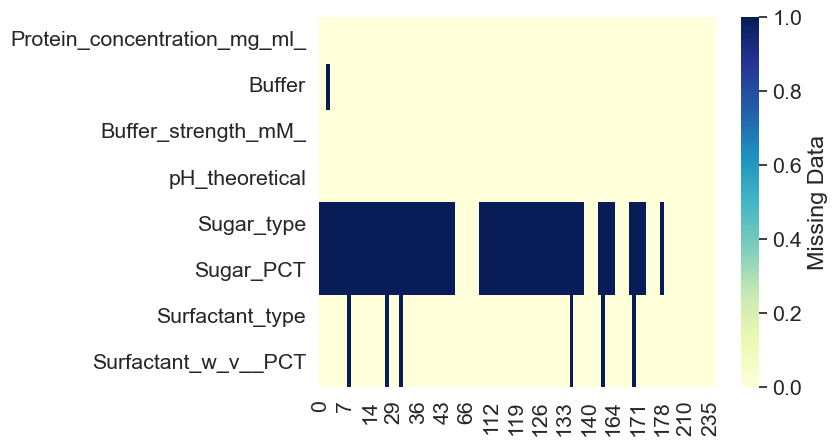

In [179]:
df_x = df[cols_feature01]
#df_x.loc[df['NaCl_mM_'].notnull(),'Sugar_type'] = 'NaCl' #add salt type to sugar type column where NaCl_mM is not null
# missing data visualization across formulation factors
import seaborn as sns
sns.set(font_scale=1.4)
sns.heatmap(df_x.isnull().transpose(), cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'})
plt.show()

In [180]:
df_x.dropna(subset = ['Buffer', 'Sugar_type', 'Sugar_PCT','Surfactant_type','Surfactant_w_v__PCT'], inplace=True)

/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_8776/270022673.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x.dropna(subset = ['Buffer', 'Sugar_type', 'Sugar_PCT','Surfactant_type','Surfactant_w_v__PCT'], inplace=True)


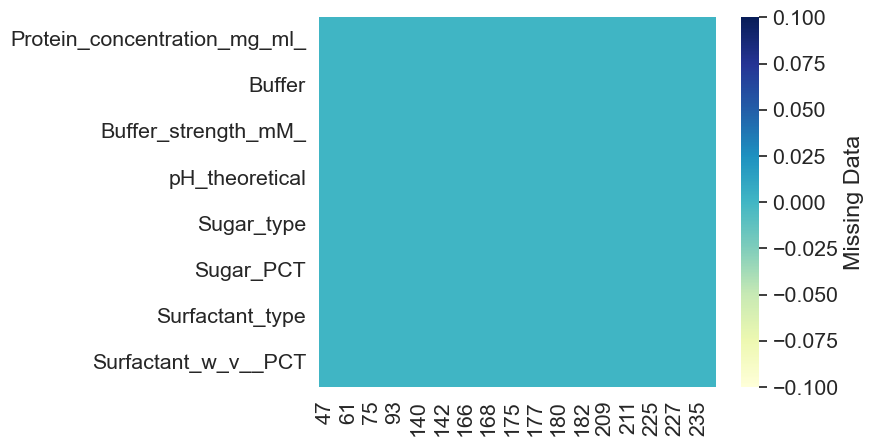

In [181]:
sns.set(font_scale=1.4)
sns.heatmap(df_x.isnull().transpose(), cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'})
plt.show()

In [129]:
#fill Buffer column with most frequent values
#df_x['Buffer'] = df_x['Buffer'].fillna(df_x['Buffer'].mode().iloc[0])
#df_x['Sugar_type'] = df_x['Sugar_type'].fillna(df_x['Sugar_type'].mode().iloc[0])
#df_x['Surfactant_type'] = df_x['Surfactant_type'].fillna(df_x['Surfactant_type'].mode().iloc[0])
#df_x.fillna({'Sugar_PCT':0},inplace = True)
#df_x.fillna({'Surfactant_w_v__PCT':0},inplace = True)
#df_x.fillna({'NaCl_mM_':0},inplace = True)

/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_8776/369720680.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x['Buffer'] = df_x['Buffer'].fillna(df_x['Buffer'].mode().iloc[0])
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_8776/369720680.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x['Sugar_type'] = df_x['Sugar_type'].fillna(df_x['Sugar_type'].mode().iloc[0])
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_8776/369720680.py:4: SettingWithCopyWarning: 
A v

In [182]:
ls_n_levels = [len(df_x[col].unique()) for col in cols_cate]
num_total_cate_levels = np.sum(ls_n_levels)
num_total_cate_levels

6

In [183]:
df_x['Buffer'].unique()

array(['Histidine'], dtype=object)

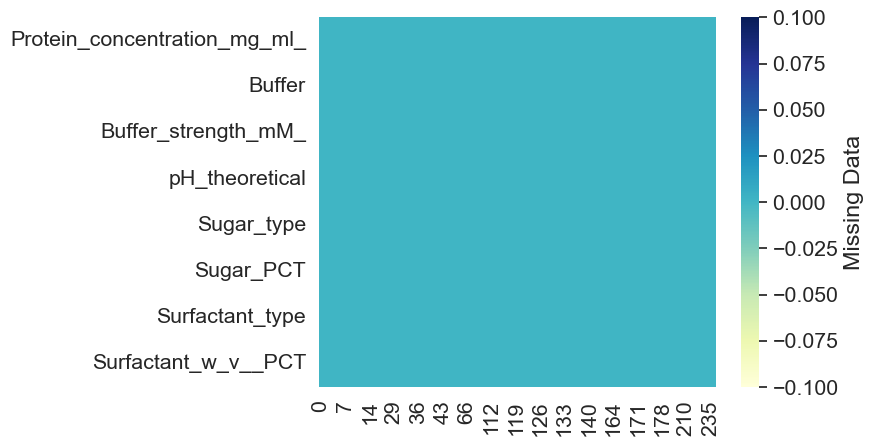

In [131]:
sns.set(font_scale=1.4)
sns.heatmap(df_x.isnull().transpose(), cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'})
plt.show()

In [132]:
#convert categorical columns to labels
for x_name in cols_cate:
    labels, categories = factorize(df_x[x_name])
    df_x[x_name+"_label"] = labels
labels, categories = factorize(df[cols_group[1]])
df_x['task_ind'] = labels
display(df_x)

/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_8776/2437042718.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x[x_name+"_label"] = labels
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_8776/2437042718.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x[x_name+"_label"] = labels
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_8776/2437042718.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

,Protein_concentration_mg_ml_,Buffer,Buffer_strength_mM_,pH_theoretical,Sugar_type,Sugar_PCT,Surfactant_type,Surfactant_w_v__PCT,Buffer_label,Sugar_type_label,Surfactant_type_label,task_ind
0,5,Acetate,20,4.0,sucrose,0.0,PS80,0.02,0,0,0,0
1,5,Acetate,20,5.0,sucrose,0.0,PS80,0.02,0,0,0,0
2,5,Histidine,20,6.0,sucrose,0.0,PS80,0.02,1,0,0,0
3,5,Phosphate,20,7.0,sucrose,0.0,PS80,0.02,2,0,0,0
4,5,Phosphate,20,8.0,sucrose,0.0,PS80,0.02,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
226,50,Histidine,10,5.3,sucrose,8.0,PS80,0.02,1,0,0,0
227,50,Histidine,10,5.3,sucrose,10.0,PS80,0.02,1,0,0,0
234,50,Histidine,10,5.3,sucrose,6.0,PS80,0.02,1,0,0,1
235,50,Histidine,10,5.3,sucrose,8.0,PS80,0.02,1,0,0,1


In [133]:
total_df_y_long = df[cols_target]
total_df_y_long.reset_index(inplace = True, drop = True)
total_df_y_long

,SEC_HMW_PCT,SEC_Monomer_PCT
0,2.9,97
1,2.7,97.3
2,3.5,96.4
3,6,93.9
4,5.6,94.4
...,...,...
109,3.1,96.7
110,3.1,96.7
111,5.1,94.6
112,4.9,94.8


In [134]:
ls_model = ['rf','simpleGP-sklearn','simpleGP-gpytorch','multi-task-single-output','multi-task-multi-output','multi-task-multi-input-multi-output']
ls_x_scale = ['no-x-scale','x-minmax','x-stand','x-robust']
ls_y_scale = ['no-y-scale','y-minmax','y-stand','y-robust', 'y-norm-sklearn']
ls_n_cate = ['no-cate','one-cate']
ls_cate_transform = ['label','ohe','LVGP','partial-LMGP','partial-LMGP-per-task','full-LMGP']
ls_output_rank_option = [0,1,2]
ls_task_rank_option = [0,1,2,3,4,5,6,7]
ls_lik_rank_option = [0,1,2]
ls_stratify_task = ['not-stratify','stratify-x']


model_option = 'multi-task-multi-output' #'simpleGP-gpytorch'
x_scale_option = 'x-minmax'
y_scale_option = 'y-minmax' #GaussianProcessRegressor has a normalize_y argument

cate_option = cols_cate

if len(cate_option) > 0:
        #cate_transform_option = 'full-LMGP-per-task'
        cate_transform_option = 'partial-LMGP-per-task'
        #cate_transform_option = 'label'
        #cate_transform_option = 'ohe'
if model_option != 'simpleGP-gpytorch':
        output_rank_option = 2#2
        task_rank_option = 3#3
        lik_rank_option = 1
else:
        output_rank_option = ''
        lik_rank_option = ''

#stratify_option = 'stratify-x'

model_label = model_option
x_scale_label = x_scale_option
y_scale_label = y_scale_option
cate_label = 'n_cate_var_'+str(len(cate_option))
cate_transform_label = 'cate_transform_'+cate_transform_option
if model_option != 'simpleGP-gpytorch':
        output_rank_label = 'output_rank_'+str(output_rank_option)
        task_rank_label = 'task_rank_'+str(task_rank_option)
        lik_rank_label = 'lik_rank_'+str(lik_rank_option)
else:
        output_rank_label = str(output_rank_option)
        task_rank_label = str(task_rank_option)
        lik_rank_label = str(lik_rank_option)


folder_name = '-'.join([model_label,output_rank_label,task_rank_label,lik_rank_label,
                        x_scale_label,y_scale_label,cate_label,cate_transform_label])

figPath = 'output/mk6204-multitask-multiout-0809/'+folder_name

if not os.path.exists(figPath):
        print(f'Creating folder {figPath}')
        os.makedirs(figPath,exist_ok = True)

In [135]:
s = set(cate_option)
cols_numeric = [x for x in cols_feature01 if x not in s]
cols_numeric

['Protein_concentration_mg_ml_',
 'Buffer_strength_mM_',
 'pH_theoretical',
 'Sugar_PCT',
 'Surfactant_w_v__PCT']

In [136]:
if len(cate_option) == 0:
    cols_cate_label = []
    cols_feature_new = cols_feature01
else:
    cols_cate_label = [x + '_label' for x in cate_option]
    if cate_transform_option != 'ohe':
        cols_feature_new = cols_cate_label+ list(cols_numeric) + ['task_ind']
    #else:
        #cols_feature_new = df_X.columns.difference(cols_cate_label + ['pH_label'])

In [137]:
df_X_train, df_X_test, df_y_train, df_y_test, indices_train,indices_test = train_test_split(df_x[cols_feature_new], total_df_y_long, np.arange(df_x.shape[0]), test_size=0.2, 
                                                                random_state=0, 
                                                                stratify=df_x['task_ind'])



In [138]:
from sklearn.compose import ColumnTransformer
#cols_exception = []
cols_exception = cols_cate_label + ['task_ind']
#cols_exception =  ['task_ind']
if x_scale_label == 'x-minmax':
    xct = ColumnTransformer([('x_mm_scaler',MinMaxScaler(),
                          df_X_train.columns.difference(cols_exception))], 
                         remainder = 'passthrough')

    scaled_X_train=xct.fit_transform(df_X_train) 
    scaled_X_test=xct.transform(df_X_test)

    t_train_x = torch.Tensor(scaled_X_train)
    t_test_x = torch.Tensor(scaled_X_test)
elif x_scale_label == 'no-x-scale':
    scaled_X_train=df_X_train.to_numpy()
    scaled_X_test=df_X_test.to_numpy()

    t_train_x = torch.Tensor(df_X_train.to_numpy())
    t_test_x = torch.Tensor(df_X_test.to_numpy())

In [139]:
y_scale_label = 'y-minmax'
if y_scale_label == 'y-robust':
    y_scaler = RobustScaler()
    scaled_y_train = y_scaler.fit_transform(df_y_train)
    #scaled_y_test= y_scaler.transform(df_y_test)
elif y_scale_label == 'y-stand':
    y_scaler = StandardScaler()
    scaled_y_train = y_scaler.fit_transform(df_y_train)
    #scaled_y_test= y_scaler.transform(df_y_test)
elif y_scale_label == 'y-minmax':
    y_scaler = MinMaxScaler()
    scaled_y_train = y_scaler.fit_transform(df_y_train)
    #scaled_y_test= y_scaler.transform(df_y_test)
else:
    scaled_y_train = df_y_train.to_numpy()
    #scaled_y_test = df_y_test.to_numpy()

t_train_y = torch.Tensor(scaled_y_train)

## No LMGP Multitask GP

In [18]:
import gpytorch
class MultiOutputMultiTaskGP0(gpytorch.models.ExactGP):

    def __init__(
        self,
        train_X,
        train_Y,
        likelihood,
        data_kernel = 'Matern',
        task_rank = None,
        output_rank = None
    ) -> None:

        num_outputs = train_Y.shape[-1]
        num_tasks = len(torch.unique(train_X[..., -1]))
        #batch_shape, ard_num_dims = train_X.shape[:-2], train_X.shape[-1]
                       
        #self._validate_tensor_args(X=train_X, Y=train_Y)

        super(MultiOutputMultiTaskGP0, self).__init__(train_X, train_Y,likelihood)
        self.task_rank = task_rank if task_rank is not None else num_tasks
        self.output_rank = output_rank if output_rank is not None else num_outputs

        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=num_outputs
        )
        
        if data_kernel == 'Matern':
            self.data_kernel = gpytorch.kernels.MaternKernel()
        else:
            self.data_kernel = gpytorch.kernels.RBFKernel()
        self.task_kernel = gpytorch.kernels.IndexKernel(num_tasks=num_tasks, rank = self.task_rank) #default rank is 1
        self.output_kernel = gpytorch.kernels.IndexKernel(num_tasks=num_outputs, rank = self.output_rank) #default rank is 1
        
        self.to(train_X)
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        task_term = self.task_kernel(x[..., -1].long())
        data_and_task_x = self.data_kernel(x[..., :-1]).mul(task_term)
        output_x = self.output_kernel.covar_matrix
        covar_x = gpytorch.lazy.KroneckerProductLazyTensor(data_and_task_x, output_x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

In [381]:
num_outputs = t_train_y.shape[-1]

task_rank = task_rank_option
output_rank = output_rank_option
lik_rank = lik_rank_option
if lik_rank is None:
            lik_rank = output_rank

likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(
                num_tasks=num_outputs, 
                rank=lik_rank if lik_rank is not None else 0,
            )

model = MultiOutputMultiTaskGP0(t_train_x, t_train_y,likelihood,
                               task_rank = task_rank,output_rank = output_rank)


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iterations = 100
loss_list = []

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(t_train_x)
    loss = -mll(output, t_train_y)
    loss_list.append(loss.item())
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()

Iter 1/100 - Loss: 1.571
Iter 2/100 - Loss: 1.475
Iter 3/100 - Loss: 1.379
Iter 4/100 - Loss: 1.280
Iter 5/100 - Loss: 1.182
Iter 6/100 - Loss: 1.085
Iter 7/100 - Loss: 0.993
Iter 8/100 - Loss: 0.906
Iter 9/100 - Loss: 0.828
Iter 10/100 - Loss: 0.758
Iter 11/100 - Loss: 0.693
Iter 12/100 - Loss: 0.629
Iter 13/100 - Loss: 0.565
Iter 14/100 - Loss: 0.501
Iter 15/100 - Loss: 0.437
Iter 16/100 - Loss: 0.376
Iter 17/100 - Loss: 0.316
Iter 18/100 - Loss: 0.261
Iter 19/100 - Loss: 0.210
Iter 20/100 - Loss: 0.160
Iter 21/100 - Loss: 0.109
Iter 22/100 - Loss: 0.056
Iter 23/100 - Loss: 0.004
Iter 24/100 - Loss: -0.044
Iter 25/100 - Loss: -0.086
Iter 26/100 - Loss: -0.120
Iter 27/100 - Loss: -0.149
Iter 28/100 - Loss: -0.180
Iter 29/100 - Loss: -0.214
Iter 30/100 - Loss: -0.249
Iter 31/100 - Loss: -0.286
Iter 32/100 - Loss: -0.326
Iter 33/100 - Loss: -0.364
Iter 34/100 - Loss: -0.400
Iter 35/100 - Loss: -0.436
Iter 36/100 - Loss: -0.472
Iter 37/100 - Loss: -0.504
Iter 38/100 - Loss: -0.535
Iter 3

Text(0.5, 1.0, 'Neg. Loss')

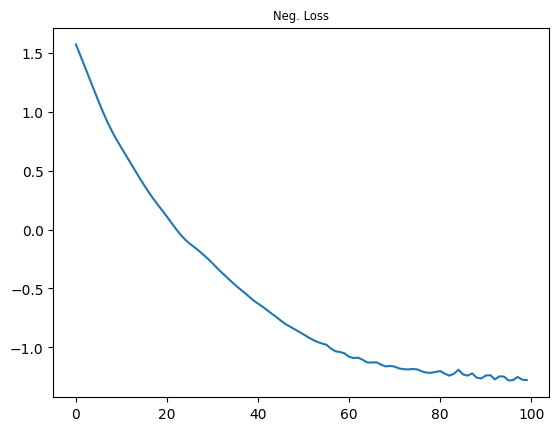

In [383]:
plt.plot(loss_list)
plt.title('Neg. Loss', fontsize='small')

In [378]:
t_test_y = torch.Tensor(df_y_test.to_numpy())

if x_scale_option != 'no-x-scale':
    t_test_x = torch.Tensor(scaled_X_test)
else:
    t_test_x = torch.Tensor(df_X_test.to_numpy())


# Set into eval mode
model.eval()
likelihood.eval()

MultitaskGaussianLikelihood(
  (raw_noise_constraint): GreaterThan(1.000E-04)
)

In [379]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
        test_pred = likelihood(model(t_test_x))   
        test_mean = test_pred.mean
        test_lower, test_upper = test_pred.confidence_region()
        train_pred = likelihood(model(t_train_x))
        train_mean = train_pred.mean
        train_lower, train_upper = train_pred.confidence_region()


if y_scale_label=='no-y-scale':
    arr_train_x = t_train_x.detach().numpy()
    arr_train_y = t_train_y.detach().numpy()
    arr_test_x = t_test_x.detach().numpy()
    arr_test_y = t_test_y.detach().numpy()
    arr_test_mean = test_mean.detach().numpy()
    arr_test_lower = test_lower.detach().numpy()
    arr_test_upper = test_upper.detach().numpy()

    arr_train_mean = train_mean.detach().numpy()
    arr_train_lower = train_lower.detach().numpy()
    arr_train_upper = train_upper.detach().numpy()
else:
    arr_train_x = t_train_x.detach().numpy()
    arr_train_y = y_scaler.inverse_transform(t_train_y)
    arr_test_x = t_test_x.detach().numpy()
    arr_test_y = t_test_y.detach().numpy()

    arr_train_mean = y_scaler.inverse_transform(train_mean)
    arr_train_lower = y_scaler.inverse_transform(train_lower)
    arr_train_upper = y_scaler.inverse_transform(train_upper)

    arr_test_mean = y_scaler.inverse_transform(test_mean)
    arr_test_lower = y_scaler.inverse_transform(test_lower)
    arr_test_upper = y_scaler.inverse_transform(test_upper)

/Users/chenya68/anaconda3/envs/gpplus-py39/lib/python3.9/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


             _Dimer_HMW_1  _Monomer_1  _Dimer_HMW_2  _Monomer_2  _Dimer_HMW_3  \
MAE                  0.15        0.22          0.15        0.17          0.31   
MedianAE             0.08        0.26          0.18        0.20          0.26   
MSE                  0.05        0.07          0.02        0.04          0.14   
RMSE                 0.22        0.26          0.15        0.21          0.37   
MAPE                 0.06        0.00          0.09        0.00          0.12   
MAXE                 0.42        0.38          0.18        0.34          0.56   
EVS                  0.89        0.90          0.98        0.79          0.89   
R2                   0.89        0.89          0.64        0.54          0.89   
AVG_STD_PCT          0.24        0.01          0.27        0.01          0.22   
MIN_STD_PCT          0.20        0.01          0.27        0.01          0.19   
MAX_STD_PCT          0.31        0.01          0.27        0.01          0.24   

             _Monomer_3  
M

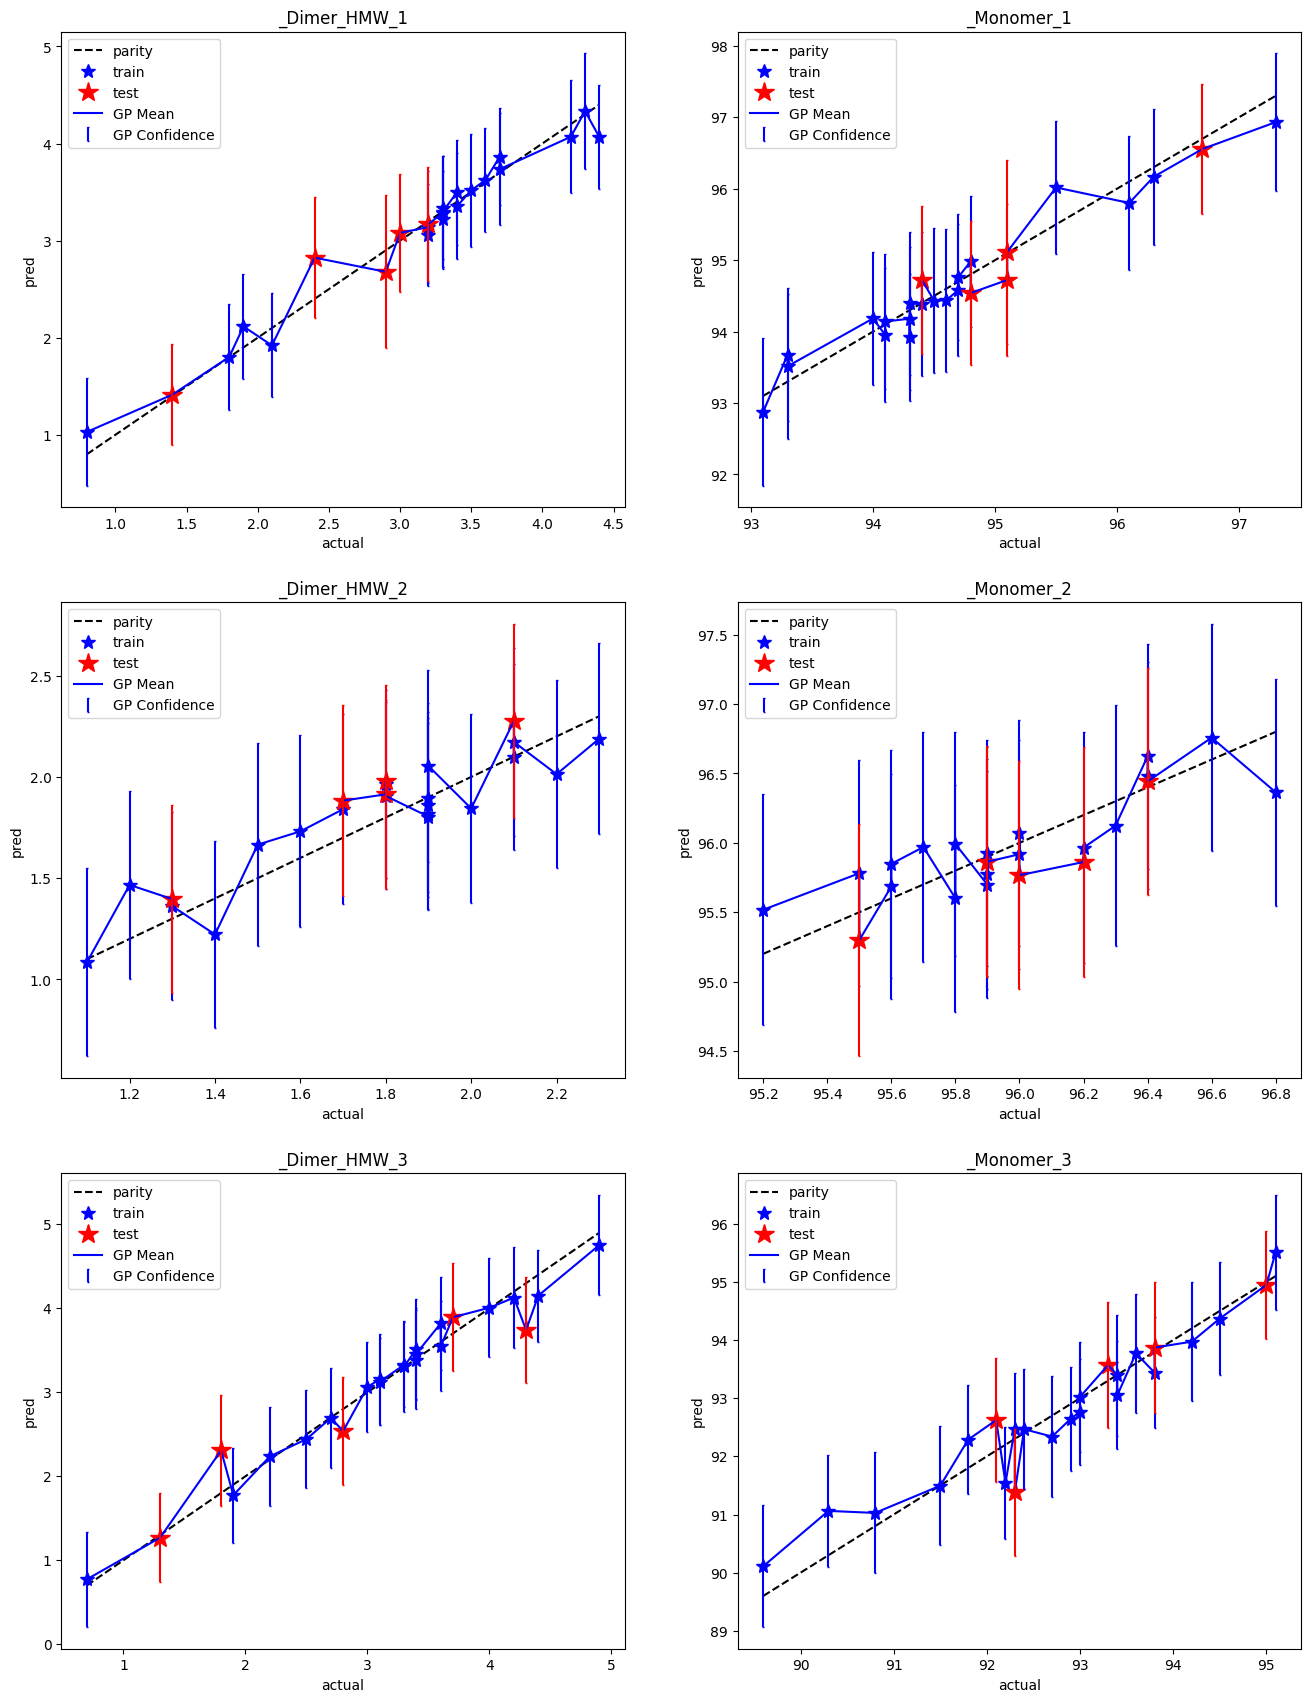

In [380]:
from sklearn.metrics import mean_squared_error

uncertainty_figure_option = 'errorbar' #shade or errorbar
is_set_axis_limit = False

plot_axis_lb = df_y.min(axis = 0) - 0.4 * df_y.std(axis = 0)
plot_axis_ub = df_y.max(axis = 0) + 0.4 * df_y.std(axis = 0)

#num_outputs = arr_train_y.shape[-1]
#num_tasks = len(np.unique(arr_train_x[..., -1]))
num_outputs = len(cols_target)
num_tasks = 3

num_total_output = num_outputs*num_tasks
arr_train_metrics = np.zeros((11,num_total_output))
arr_test_metrics = np.zeros((11,num_total_output))

# Initialize plots
#f, y_axes = plt.subplots(num_tasks, num_outputs, figsize=(16, 48))
f, y_axes = plt.subplots(num_tasks, num_outputs, figsize=(num_outputs*8, num_tasks*7))
y_axes = y_axes.ravel()
for task_ind in range(num_tasks):
  for j,_ in enumerate(cols_target):
    a = j + len(cols_target)*task_ind
    tmp_col_y = cols_target_new[a]

    r_train_y = arr_train_y[arr_train_x[:,-1]==task_ind,j]
    r_train_mean_y =arr_train_mean[arr_train_x[:,-1]==task_ind,j]
    r_train_lower_y =arr_train_lower[arr_train_x[:,-1]==task_ind,j]
    r_train_upper_y =arr_train_upper[arr_train_x[:,-1]==task_ind,j]
    r_train_std = r_train_mean_y - r_train_lower_y

    r_test_y = arr_test_y[arr_test_x[:,-1]==task_ind,j]
    r_test_mean_y =arr_test_mean[arr_test_x[:,-1]==task_ind,j]
    r_test_lower_y =arr_test_lower[arr_test_x[:,-1]==task_ind,j]
    r_test_upper_y =arr_test_upper[arr_test_x[:,-1]==task_ind,j]
    r_test_std = r_test_mean_y - r_test_lower_y
    
    train_comp = np.concatenate((r_train_y.reshape(-1,1),r_train_mean_y.reshape(-1,1)),axis = 1)
    df_train_comp = pd.DataFrame(train_comp,columns = ['true','pred'])
    df_train_comp['upper'] = r_train_upper_y
    df_train_comp['lower'] = r_train_lower_y
    df_train_comp['mode'] = 'train'
    
    test_comp = np.concatenate((r_test_y.reshape(-1,1),r_test_mean_y.reshape(-1,1)),axis = 1)
    df_test_comp = pd.DataFrame(test_comp,columns = ['true','pred'])
    df_test_comp['upper'] = r_test_upper_y
    df_test_comp['lower'] = r_test_lower_y
    df_test_comp['mode'] = 'test'
    
    df_comp = pd.concat([df_train_comp,df_test_comp])
    df_comp_sorted = df_comp.sort_values(by = ['true'],ascending=True)

    #plot a parity line
    y_axes[a].plot(df_comp_sorted['true'], df_comp_sorted['true'], '--',c = 'black')
    
    # Plot training data as blue stars
    y_axes[a].plot(df_train_comp['true'], df_train_comp['pred'], 'b*',markersize=10)

    # Plot training data as red stars
    y_axes[a].plot(df_test_comp['true'], df_test_comp['pred'], 'r*',markersize=15)
    # Predictive mean as blue line
    y_axes[a].plot(df_comp_sorted['true'], df_comp_sorted['pred'],c = 'blue')
    
    if uncertainty_figure_option == 'shade':
    # Shade in confidence
      y_axes[a].fill_between(x = df_comp_sorted['true'],y1 = df_comp_sorted['lower'], y2 = df_comp_sorted['upper'], color='b', alpha=.15)
    else:
      yerr = df_comp_sorted['pred'] - df_comp_sorted['lower']
      yerr = yerr.values.tolist()
      #y_axes[a].errorbar(x = df_comp_sorted['true'], y = df_comp_sorted['pred'], yerr = yerr, capsize=1, fmt='none', ecolor = 'black')
      yerr_train = df_train_comp['pred'] - df_train_comp['lower']
      yerr_train = yerr_train.values.tolist()
      yerr_test = df_test_comp['pred'] - df_test_comp['lower']
      yerr_test = yerr_test.values.tolist()
      y_axes[a].errorbar(x = df_train_comp['true'], y = df_train_comp['pred'], yerr = yerr_train, capsize=1, fmt='none', ecolor = 'blue')
      y_axes[a].errorbar(x = df_test_comp['true'], y = df_test_comp['pred'], yerr = yerr_test, capsize=1, fmt='none', ecolor = 'red')
    
    if is_set_axis_limit:
      y_axes[a].set_xlim([plot_axis_lb[j],plot_axis_ub[j]])
      y_axes[a].set_ylim([plot_axis_lb[j],plot_axis_ub[j]])

    y_axes[a].legend(['parity','train','test','GP Mean','GP Confidence'])
    y_axes[a].set_title(tmp_col_y)
    y_axes[a].set_xlabel('actual')
    y_axes[a].set_ylabel('pred')

    y_true = r_test_y
    y_pred = r_test_mean_y
    y_train = r_train_y
    mean_train = r_train_mean_y
    

    arr_test_metrics[0,a] = np.round(metrics.mean_absolute_error(y_true, y_pred),2)
    arr_test_metrics[1,a] = np.round(metrics.median_absolute_error(y_true, y_pred),2)
    arr_test_metrics[2,a] = np.round(metrics.mean_squared_error(y_true, y_pred),2)
    arr_test_metrics[3,a] = round(np.sqrt(metrics.mean_squared_error(y_true, y_pred)),2)
    arr_test_metrics[4,a] = round(metrics.mean_absolute_percentage_error(y_true, y_pred),2)
    arr_test_metrics[5,a] = round(metrics.max_error(y_true, y_pred),2)
    arr_test_metrics[6,a] = round(metrics.explained_variance_score(y_true, y_pred),2)
    arr_test_metrics[7,a] = round(metrics.r2_score(y_true, y_pred),2)
    arr_test_metrics[8,a] = round(np.mean(r_test_std)/np.mean(y_true),2)
    arr_test_metrics[9,a] = round(np.min(r_test_std)/np.mean(y_true),2)
    arr_test_metrics[10,a] = round(np.max(r_test_std)/np.mean(y_true),2)

    arr_train_metrics[0,a] = round(metrics.mean_absolute_error(y_train, mean_train),2)
    arr_train_metrics[1,a] = round(metrics.median_absolute_error(y_train, mean_train),2)
    arr_train_metrics[2,a] = round(metrics.mean_squared_error(y_train, mean_train),2)
    arr_train_metrics[3,a] = round(np.sqrt(metrics.mean_squared_error(y_train, mean_train)),2)
    arr_train_metrics[4,a] = round(metrics.mean_absolute_percentage_error(y_train, mean_train),2)
    arr_train_metrics[5,a] = round(metrics.max_error(y_train, mean_train),2)
    arr_train_metrics[6,a] = round(metrics.explained_variance_score(y_train, mean_train),2)
    arr_train_metrics[7,a] = round(metrics.r2_score(y_train, mean_train),2)
    arr_train_metrics[8,a] = round(np.mean(r_train_std)/np.mean(y_train),2)
    arr_train_metrics[9,a] = round(np.min(r_train_std)/np.mean(y_train),2)
    arr_train_metrics[10,a] = round(np.max(r_train_std)/np.mean(y_train),2)
    #arr_train_metrics[11,i] = my_gpr.kernel_.get_params()['k1__constant_value']
    #arr_train_metrics[12,i] = my_gpr.kernel_.get_params()['k2__length_scale']


if uncertainty_figure_option == 'shade' and is_set_axis_limit:
  plt.savefig(figPath+'/true-pred-shade.jpg')
elif uncertainty_figure_option == 'shade' and ~is_set_axis_limit:
  plt.savefig(figPath+'/true-pred-shade-zoomin.jpg')
elif uncertainty_figure_option == 'errorbar' and is_set_axis_limit:
  plt.savefig(figPath+'/true-pred-errorbar.jpg')
elif uncertainty_figure_option == 'errorbar' and ~is_set_axis_limit:
  plt.savefig(figPath+'/true-pred-errorbar-zoomin.jpg')

df_test_metrics = pd.DataFrame(arr_test_metrics,columns = cols_target_new, 
                               index = ['MAE','MedianAE','MSE','RMSE','MAPE','MAXE','EVS','R2','AVG_STD_PCT','MIN_STD_PCT','MAX_STD_PCT'])
print(df_test_metrics)

df_train_metrics = pd.DataFrame(arr_train_metrics,columns = cols_target_new, 
                               index = ['MAE','MedianAE','MSE','RMSE','MAPE','MAXE','EVS','R2','AVG_STD_PCT','MIN_STD_PCT','MAX_STD_PCT'])
print(df_train_metrics)


df_train_metrics.to_csv(figPath+'/df_train_metrics.csv')
df_test_metrics.to_csv(figPath+'/df_test_metrics.csv')

## Define GP for LMGP

In [154]:
#qual_ind_lev = {0: 4, 1:6, 2:2, 3:2}
qual_ind_lev = {5:5, 6:4, 7:3}
quant_index = [0,1,2,3,4]
task_index = 8

In [155]:
import gpytorch
from gpplus import kernels
from gpplus.priors import LogHalfHorseshoePrior,MollifiedUniformPrior
from gpytorch.priors import NormalPrior,LogNormalPrior
from gpytorch.constraints import GreaterThan,Positive

class MultiOutputMultiTaskGP(gpytorch.models.ExactGP):

    def __init__(
        self,
        train_X,
        train_Y,
        data_kernel,
        noise_indices,
        fix_noise:bool=False,
        lb_noise:float=1e-4,
        task_rank = None,
        output_rank = None,
        lik_rank = None
    ) -> None:

        num_outputs = train_Y.shape[-1]
        num_tasks = len(torch.unique(train_X[..., -1]))
        self._num_tasks = num_tasks
        self._num_outputs = num_outputs
        
        self.task_rank = task_rank if task_rank is not None else num_tasks
        self.output_rank = output_rank if output_rank is not None else num_outputs
        self.lik_rank = lik_rank if lik_rank is not None else 0
        # initializing likelihood
        likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=num_outputs,rank = self.lik_rank)
        super(MultiOutputMultiTaskGP, self).__init__(train_X, train_Y,likelihood)

        self.likelihood.register_prior('raw_noise_prior',LogHalfHorseshoePrior(0.01,lb_noise),'raw_noise')
        if self.lik_rank == 0:
            self.likelihood.register_prior('raw_task_noises_prior',LogHalfHorseshoePrior(0.01,lb_noise),'raw_task_noises')    
        else:
            self.likelihood.register_prior('task_noise_covar_factor_prior',NormalPrior(0.,1),'task_noise_covar_factor')

        #self.likelihood.register_prior('raw_task_noises_prior',LogHalfHorseshoePrior(0.01,lb_noise),'raw_task_noises')
        #self.likelihood.register_prior('raw_noise_prior',LogHalfHorseshoePrior(0.01,lb_noise),'raw_noise')
        if fix_noise:
            self.likelihood.raw_noise.requires_grad_(False)
            self.likelihood.noise_covar.noise =torch.tensor(4.9901e-05)

        
        #define prior for mean module
        mean_list = [gpytorch.means.ConstantMean(NormalPrior(0,1)) for t in range(num_outputs)]
        self.mean_module = gpytorch.means.MultitaskMean(
            mean_list, num_tasks=num_outputs
        )
        
        self.data_kernel = data_kernel
        if isinstance(data_kernel,str):
            try:
                data_kernel_class = getattr(kernels,data_kernel)
                self.data_kernel = data_kernel_class(
                    ard_num_dims = self.train_inputs[0].size(1),
                    lengthscale_constraint=Positive(transform=torch.exp,inv_transform=torch.log),
                )
                
                self.data_kernel.register_prior(
                    'lengthscale_prior',MollifiedUniformPrior(math.log(0.1),math.log(10)),'raw_lengthscale'
                )
                
            except:
                raise RuntimeError(
                    "%s not an allowed kernel" % data_kernel
                )
        
        elif not isinstance(data_kernel,gpytorch.kernels.Kernel):
            raise RuntimeError(
                "specified data kernel is not a `gpytorch.kernels.Kernel` instance"
            )

        #define kernel for gplvm on mixed variables
        self.data_kernel2 = gpytorch.kernels.RBFKernel()
        self.data_kernel2.register_prior(
                    'lengthscale_prior',MollifiedUniformPrior(math.log(0.1),math.log(10)),'raw_lengthscale'
                )

        self.task_kernel = gpytorch.kernels.IndexKernel(num_tasks=num_tasks, rank = self.task_rank) #default rank is 1
        self.output_kernel = gpytorch.kernels.IndexKernel(num_tasks=num_outputs, rank = self.output_rank) #default rank is 1
        
        self.task_kernel.register_prior("covar_factor_prior",NormalPrior(0.,1),lambda m: m._parameters['covar_factor'])
        self.task_kernel.register_prior("raw_var_prior",NormalPrior(0.,1),lambda m: m._parameters['raw_var'])

        self.output_kernel.register_prior("covar_factor_prior",NormalPrior(0.,1),lambda m: m._parameters['covar_factor'])
        self.output_kernel.register_prior("raw_var_prior",NormalPrior(0.,1),lambda m: m._parameters['raw_var'])
        
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        task_term = self.task_kernel(x[..., -1].long())
        data_and_task_x = self.data_kernel(x[..., :-1]).mul(task_term)
        output_x = self.output_kernel.covar_matrix
        covar_x = gpytorch.lazy.KroneckerProductLazyTensor(data_and_task_x, output_x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)
    
    def predict(
        self,x:torch.Tensor,return_std:bool=False,include_noise:bool=False
    ):

        self.eval()
        self.likelihood.eval()
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            pred_res = self.likelihood(self.forward(x))   
            mean = pred_res.mean
            lower, upper = pred_res.confidence_region()
        return mean, lower, upper

In [156]:
mt_model = MultiOutputMultiTaskGP(t_train_x, t_train_y,noise_indices = [], 
                            data_kernel = gpytorch.kernels.RBFKernel(lengthscale_prior=MollifiedUniformPrior(math.log(0.1),math.log(10))),
                            lb_noise = 1e-4,
                            task_rank= task_rank_option,
                            output_rank= output_rank_option,
                            lik_rank= lik_rank_option)
#mt_model_output = mt_model(*mt_model.train_inputs)
#Z = torch.randn(t_train_x.shape[0],2)
mt_model_output = mt_model(mt_model.train_inputs[0])
mt_out = mt_model.likelihood(mt_model_output).log_prob(mt_model.train_targets)
mt_out

tensor(-286.0103, grad_fn=<MulBackward0>)

## likelihood and optimization

In [157]:
## likelihood and optimization
import torch
import numpy as np
from gpytorch import settings as gptsettings
from gpytorch.utils.errors import NanError,NotPSDError
from scipy.optimize import minimize,OptimizeResult
from collections import OrderedDict
from functools import reduce
from joblib import Parallel,delayed
from joblib.externals.loky import set_loky_pickler
from typing import Dict,List,Tuple,Optional,Union
from copy import deepcopy
from scipy.optimize import Bounds
from scipy.optimize import NonlinearConstraint
from scipy.optimize import BFGS
#######################################################

from gpplus.utils.interval_score import interval_score
tkwargs = {
    "dtype": torch.float,
    "device": torch.device("cpu" if torch.cuda.is_available() else "cpu"),
}

def marginal_log_likelihood(model,add_prior:bool,regularization_parameter=[0,0]):
    output = model(*model.train_inputs)
    out = model.likelihood(output).log_prob(model.train_targets)
    if add_prior:
        # add priors
        for _, module, prior, closure, _ in model.named_priors():
            out.add_(prior.log_prob(closure(module)).sum())
    temp = 0
    temp_1=0
    for name, param in model.named_parameters():
        string_list = ['fci', 'h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'h8','h9', 'h10', 'h11', 'h12','fce']
        if name in string_list:
            temp += torch.norm(param)
            temp_1 += torch.sum(torch.abs(param))
        elif name in ['nn_model.' + str + '.bias' for str in string_list]:
            temp += torch.norm(param)
            temp_1 += torch.sum(torch.abs(param))

    out -= regularization_parameter[0]*temp_1 + regularization_parameter[1]* temp    
    ## Interval Score if neede for BO
    if model.IS is True:
        score, accuracy = interval_score(output.mean + 1.96 * output.variance.sqrt(), output.mean - 1.96 * output.variance.sqrt(), model.y_scaled)
        return out - 0.08*torch.abs(out) * score#- torch.exp(model.interval_alpha) * score
    return out 


class MLLObjective:

    def __init__(self,model,add_prior,regularization_parameter):
        self.model = model 
        self.add_prior = add_prior
        self.regularization_parameter=regularization_parameter

        parameters = OrderedDict([
            (n,p) for n,p in self.model.named_parameters() if p.requires_grad
        ])
        self.param_shapes = OrderedDict()
        for n,p in self.model.named_parameters():
            if p.requires_grad:
                if len(parameters[n].size()) > 0:
                    self.param_shapes[n] = parameters[n].size()
                else:
                    self.param_shapes[n] = torch.Size([1])
    
    def pack_parameters(self) -> np.ndarray:
        parameters = OrderedDict([
            (n,p) for n,p in self.model.named_parameters() if p.requires_grad
        ])
        
        return np.concatenate([parameters[n].cpu().data.numpy().ravel() for n in parameters])
    
    def unpack_parameters(self, x:np.ndarray) -> torch.Tensor:
        i = 0
        named_parameters = OrderedDict()
        for n in self.param_shapes:
            param_len = reduce(lambda x,y: x*y, self.param_shapes[n])
            # slice out a section of this length
            param = x[i:i+param_len]
            # reshape according to this size, and cast to torch
            param = param.reshape(*self.param_shapes[n])
            named_parameters[n] = torch.from_numpy(param).to(**tkwargs)
            # update index
            i += param_len
        return named_parameters

    def pack_grads(self) -> None:
        """Concatenate gradients from the parameters to 1D numpy array
        """
        grads = []
        for name,p in self.model.named_parameters():
            if p.requires_grad:
                grad = p.grad.cpu().data.numpy()
                grads.append(grad.ravel())
        return np.concatenate(grads).astype(np.float64)

    def fun(self, x:np.ndarray,return_grad=True) -> Union[float,Tuple[float,np.ndarray]]:
        # unpack x and load into module 
        state_dict = self.unpack_parameters(x)
        old_dict = self.model.state_dict()
        old_dict.update(state_dict)
        self.model.load_state_dict(old_dict)

        self.model.zero_grad()
        obj = -marginal_log_likelihood(self.model, self.add_prior,self.regularization_parameter) # negative sign to minimize
        
        if return_grad:
            obj.backward()
            
            return obj.item(),self.pack_grads()
        
        return obj.item()


def _sample_from_prior(model) -> np.ndarray:
    out = []
    for _,module,prior,closure,_ in model.named_priors():
        if not closure(module).requires_grad:
            continue
            
        out.append(prior.expand(closure(module).shape).sample().cpu().numpy().ravel())
    
    return np.concatenate(out)


def cons_f(x,likobj):
    zeta = torch.tensor(likobj.model.zeta, dtype = torch.float64)
    A = likobj.unpack_parameters(x)['fci']
    likobj.model.nn_model.fci.weight.data = A
    positions = likobj.model.nn_model(zeta)
    out_constraint=positions.detach().numpy().reshape(-1,)
    return out_constraint[0:8]


def get_bounds(likobj, theta):

    dic = likobj.unpack_parameters(theta)

    minn = np.empty(0)
    maxx = np.empty(0)
    for name, values in dic.items():
        for ii in range(len(likobj.model.qual_kernel_columns)):
            if name ==  str(likobj.model.qual_kernel_columns[ii]):
                minn = np.concatenate( (minn,  np.repeat(-3, values.numel()) ) )
                maxx = np.concatenate( (maxx,  np.repeat(3, values.numel()) ) )
        #if name == 'likelihood.noise_covar.raw_noise' or name.startswith('[') or name.startswith('latent['):
        if name.startswith ('likelihood.') or name.startswith('[') or name.startswith('latent') or name.startswith('gplvm'):
            minn = np.concatenate( (minn,  np.repeat(-np.inf, values.numel()) ) )
            maxx = np.concatenate( (maxx,  np.repeat( np.inf, values.numel()) ) )
        if 'raw_lengthscale' in name:
            minn = np.concatenate( (minn,  np.repeat(-10.0, values.numel()) ) )
            maxx = np.concatenate( (maxx,  np.repeat( 3.0, values.numel()) ) )
        #elif name.startswith('covar_module'):
        elif 'task_covar_module' in name or 'task_kernel' in name or 'output_kernel' in name:
            minn = np.concatenate( (minn,  np.repeat(-10.0, values.numel()) ) )
            maxx = np.concatenate( (maxx,  np.repeat( 3.0, values.numel()) ) )
            ######################################################################################### For multiple Bases ##################################
        elif name.startswith('mean'):
            minn = np.concatenate( (minn,  np.repeat(-1.5, values.numel()) ) )
            maxx = np.concatenate( (maxx,  np.repeat( 1.5, values.numel()) ) )
        elif name.startswith('Theta_'):
            minn = np.concatenate( (minn,  np.repeat(-15, values.numel()) ) )
            maxx = np.concatenate( (maxx,  np.repeat( 15, values.numel()) ) )
        elif name.startswith('encoder'):
            minn = np.concatenate( (minn,  np.repeat(-15, values.numel()) ) )
            maxx = np.concatenate( (maxx,  np.repeat( 15, values.numel()) ) )
            ######################################################################################### For A_matrix and Variationa encoder  #################
        elif name.startswith('A_matrix'):
            minn = np.concatenate( (minn,  np.repeat(-10, values.numel()) ) )
            maxx = np.concatenate( (maxx,  np.repeat( 10, values.numel()) ) )
    return np.array(minn).reshape(-1,), np.array(maxx).reshape(-1,)


def _fit_model_from_state(likobj,theta0,jac,options, method = 'trust-constr',constraint=False,bounds=False):
    
    min, max = get_bounds(likobj, theta0)
    bounds_acts = Bounds(min, max)
    nonlinear_constraint = NonlinearConstraint(lambda x: cons_f(x, likobj), [0,0,0,0,-5,0,-5,-5],[0,0,5,0,5,5,5,5], jac='2-point', hess=BFGS())
    '''
    if constraint==True:
        nonlinear_constraint = NonlinearConstraint(lambda x: cons_f(x, likobj), [0,0,0,0,-inf,0],[0,0,inf,0,inf,inf], jac='2-point', hess=BFGS())
    
    else:
        nonlinear_constraint = NonlinearConstraint(lambda x: cons_f(x, likobj), [-inf,-inf,-inf,-inf,-inf,-inf],[inf,inf,inf,inf,inf,inf], jac='2-point', hess=BFGS())

    '''
    eq_cons = {'type': 'eq',
                'fun' : lambda x: np.array([cons_f(x, likobj)[0],cons_f(x, likobj)[1],cons_f(x, likobj)[3]])}
    ineq_cons = {'type': 'ineq',
                'fun' : lambda x: np.array([cons_f(x, likobj)[2],cons_f(x, likobj)[5]])}
    if constraint==True:
        nonlinear_constraint=[nonlinear_constraint]
    else:
        nonlinear_constraint=[]


    if bounds==True:
        bounds=bounds_acts
    else:
        bounds=None


    try:
        with gptsettings.fast_computations(log_prob=False):
            return minimize(
                fun = likobj.fun,
                x0 = theta0,
                args=(True) if jac else (False),

                method = method,
                jac=jac,
                bounds=bounds,
                constraints= nonlinear_constraint,
                #constraints=[eq_cons, ineq_cons],
                options= options 
            )


    except Exception as e:
        if isinstance(e,NotPSDError) or isinstance(e, NanError):
            # Unstable hyperparameter configuration. This can happen if the 
            # initial starting point is bad. 
            return e
        else:
            # There is some other issue, most likely with the inputs supplied
            # by the user. Raise error to indicate the problematic part.
            raise


def fit_model_scipy(
    model,
    add_prior:bool=True,
    num_restarts:int=1,
    theta0_list:Optional[List[np.ndarray]]=None,
    jac:bool=True, 
    options:Dict={},
    n_jobs:int=-1,
    method = 'L-BFGS-B',
    constraint=False,
    bounds=False,
    regularization_parameter:List[int]=[0,0]
    ) -> Tuple[List[OptimizeResult],float]:

    defaults = {}

    if method == 'L-BFGS-B':
        defaults = {'ftol':1e-6,'gtol':1e-5,'maxfun':5000,'maxiter':2000}
    elif method == 'trust-constr':
        defaults = {'verbose': 1}
    elif method == 'BFGS':
        defaults = {'gtol': 1e-07, 'norm': np.inf, 'eps': 1.4901161193847656e-08,'maxiter': None, 'disp': False, 'return_all': False, 'finite_diff_rel_step': None}#
    elif method == 'SLSQP':
        defaults = { 'maxiter': 100, 'ftol': 1e-06, 'iprint': 1, 'disp': False, 'eps': 1.4901161193847656e-08, 'finite_diff_rel_step': None}#
    elif method == 'Newton-CG':
        defaults={'xtol': 1e-05, 'eps': 1.4901161193847656e-08, 'maxiter': None, 'disp': False, 'return_all': False}
    else:
        raise ValueError('Wrong method')

    if len(options) > 0:
        for key in options.keys():
            if key not in defaults.keys():
                raise RuntimeError('Unknown option %s!'%key)
            defaults[key] = options[key]

    likobj = MLLObjective(model,add_prior,regularization_parameter)

    if theta0_list is None:
        theta0_list = [likobj.pack_parameters()]
        if num_restarts > -1:
            theta0_list.extend([_sample_from_prior(model) for _ in range(num_restarts+1)])
            theta0_list.pop(0)                                                          
    
    set_loky_pickler("dill") 

    out = Parallel(n_jobs=n_jobs,verbose=0)(
        delayed(_fit_model_from_state)(likobj,theta0,jac,defaults, method,constraint,bounds) \
            for theta0 in theta0_list
    )
    #out = [_fit_model_from_state(likobj,theta0,jac,defaults,method,constraint,bounds) for theta0 in theta0_list]
    set_loky_pickler("pickle")

    nlls_opt = [np.inf if isinstance(res,Exception) else res.fun for res in out]
    best_idx = np.argmin(nlls_opt)
    try:
        theta_best = out[best_idx].x
        old_dict = deepcopy(model.state_dict())
        old_dict.update(likobj.unpack_parameters(theta_best))
        model.load_state_dict(old_dict)

        if 'fci' in [name for name,p in model.named_parameters()]:
            model.nn_model.fci.weight.data = old_dict['fci']       
    except:
        pass
    return out,nlls_opt[best_idx]

In [158]:
pd.DataFrame(t_train_y.numpy()).corr()

,0,1
0,1.000000,-0.998212
1,-0.998212,1.000000


In [159]:
##GP Plus
import torch
import math
import gpytorch
from typing import Dict,List,Optional
from gpytorch.constraints import Positive
from gpytorch.priors import NormalPrior
from gpytorch.distributions import MultivariateNormal, MultitaskMultivariateNormal
from gpplus.priors import MollifiedUniformPrior
from gpplus.visual.plot_latenth import plot_sep
from gpplus.models.gpregression import GPR
from gpplus import kernels
import numpy as np
from gpplus.preprocessing import setlevels


from tabulate import tabulate
from gpplus.utils import set_seed
#from gpplus.optim import fit_model_scipy, noise_tune2, fit_model_torch

import numpy as np
import sobol_seq
import warnings
from torch import Tensor
from gpytorch.means import Mean
from torch.nn.parameter import Parameter
from torch.nn import init
from torch import nn
import torch.nn.functional as F 
from scipy.stats import norm

class GP_Plus(MultiOutputMultiTaskGP):
    """The GP_Plus which extends GPs to learn nonlinear and probabilistic nmanifold, handle categorical inputs, and  ... ...

    :note: Binary categorical variables should not be treated as qualitative inputs. There is no 
        benefit from applying a latent variable treatment for such variables. Instead, treat them
        as numerical inputs.

    :param train_x: The training inputs (size N x d). Qualitative inputs needed to be encoded as 
        integers 0,...,L-1 where L is the number of levels. For best performance, scale the 
        numerical variables to the unit hypercube.
    """
    def __init__(
        self,
        train_x:torch.Tensor,
        train_y:torch.Tensor,
        quant_correlation_class:str='Rough_RBF',
        qual_ind_lev = {},
        quant_index = [],
        task_index = -1,
        multiple_noise = False,
        lv_dim:int=2,
        fix_noise:bool=False,
        fixed_length_scale:bool=False,
        fixed_omega=torch.tensor([1.0]),
        lb_noise:float=1e-4,
        NN_layers:list = [],
        encoding_type = 'one-hot',
        manifold_type='deterministic',
        uniform_encoding_columns = 2,
        lv_columns = [] ,
        base='single_constant',
        base_hf='zero',
        NN_layers_base=[],
        base_function_size=None,
        calibration_id=[],
        seed_number=1,
        mean_prior_cal=0,
        std_prior_cal=1,
        device="cpu",
        dtype= torch.float,
        IS=False,
        is_mix_reduce = False,
        is_per_task = True,
        task_rank=None,
        output_rank = None,
        lik_rank=None
    ) -> None:
        
        self.IS=IS
        tkwargs = {}  # or dict()
        tkwargs['dtype'] = dtype
        tkwargs['device'] =torch.device(device)
        self.tkwargs=tkwargs
        self.is_per_task = is_per_task

        self.mean_prior_cal=mean_prior_cal
        self.std_prior_cal=std_prior_cal
        if fixed_length_scale:
            self.fixed_omega=fixed_omega.to(**self.tkwargs)
        else:
            self.fixed_omega=None
            
        ## The checks lists:
        if not isinstance(train_x, torch.Tensor):
            original_type = type(train_x).__name__
            warnings.warn(f"'train_x' was not a torch.Tensor (type: {original_type}). It is converted to torch.Tensor to proceed with the emulation.")
            train_x = torch.tensor(train_x)

        if not isinstance(train_y, torch.Tensor):
            original_type = type(train_y).__name__
            warnings.warn(f"'train_y' was not a torch.Tensor (type: {original_type}). It is converted to torch.Tensor to proceed with the emulation.")
            train_y = torch.tensor(train_y)

        if not isinstance(qual_ind_lev, dict):
            raise ValueError("qual_ind_lev should be a dictionary")

        if multiple_noise not in [True, False]:
            raise ValueError("multiple_noise should be either True or False")

        if not isinstance(lv_dim, int):
            raise ValueError("lv_dim should be an integer")

        if quant_correlation_class not in ['Rough_RBF', 'RBFKernel', 'Matern32Kernel', 'Matern12Kernel','Matern52Kernel']:
            raise ValueError("quant_correlation_class should be 'Rough_RBF', 'RBFKernel', 'Matern32Kernel', 'Matern12Kernel','Matern52Kernel'")

        if fix_noise not in [True, False]:
            raise ValueError("fix_noise should be either True or False")

        if not isinstance(NN_layers, list) or not all(isinstance(i, int) for i in NN_layers):
            raise ValueError("NN_layers should be a list with integers representing the number of neurons in each layer for mapping the manifold")

        if encoding_type != 'one-hot':
            raise ValueError("encoding_type should be 'one-hot'")

        if manifold_type not in ['deterministic', 'probabilistic']:
            raise ValueError("manifold_type should be either 'deterministic' or 'probabilistic'")

        if not isinstance(lv_columns, list) or not all(isinstance(i, int) for i in lv_columns):
            raise ValueError("lv_columns should be a list with integers showing the number of categorical inputs to be considered in a separate manifold in each layer")

    
        supported_singl_functions = ['single_sin', 'single_cos', 'single_exp', 'single_log', 'single_tan', 'single_asin', 'single_acos', 'single_atan', 
                                    'single_sinh', 'single_cosh', 'single_tanh', 'single_asinh', 'single_acosh', 'single_atanh', 'single_sqrt', 
                                    'single_abs', 'single_ceil', 'single_floor', 'single_round']

        self.supported_singl_base_functions=supported_singl_functions
        
        supported_multi_base_functions=['single_zero', 'single_polynomial', 'single_constant', 'multiple_polynomial_2d', 'multiple_constant', 'neural_network']

        #if base not in supported_multi_base_functions and base not in supported_singl_functions:
        #     raise ValueError("base is not valied'")

        if not isinstance(NN_layers_base, list) or not all(isinstance(i, int) for i in NN_layers_base):
            raise ValueError("NN_layers_base should be a list with integers representing the number of neurons in each layer for the mean function")

        if not isinstance(calibration_id, list) or not all(isinstance(i, int) for i in calibration_id):
            raise ValueError("calibration_id should be a list where each entry shows the column number in the dataset that the calibration parameters are assigned to")
        
        train_x=self.fill_nan_with_mean(train_x,calibration_id)
        ###############################################################################################
        ###############################################################################################
        self.seed=seed_number
        self.calibration_id=calibration_id
        self.calibration_source_index=0    ## It is supposed the calibration parameter is for high fidelity needs
        qual_index = list(qual_ind_lev.keys())
        all_index = set(range(train_x.shape[-1]))
        #quant_index = list(all_index.difference(qual_index))
        num_levels_per_var = list(qual_ind_lev.values())
        #------------------- lm columns --------------------------
        lm_columns = list(set(qual_index).difference(lv_columns))
        if len(lm_columns) > 0:
            qual_kernel_columns = [*lv_columns, lm_columns]
        else:
            qual_kernel_columns = lv_columns
        #########################
        if len(qual_index) > 0:
            train_x = torch.tensor(setlevels(train_x, qual_index=qual_index))#.to(**self.tkwargs)
        #
        train_x=train_x.to(**self.tkwargs)
        train_y=train_y.to(**self.tkwargs)
        #train_y=train_y.reshape(-1)#.to(**self.tkwargs)
        
        if multiple_noise:
            noise_indices = list(range(0,num_levels_per_var[-1]))
        else:
            noise_indices = []

        if len(qual_index) == 1 and num_levels_per_var[0] < 2:
            temp = quant_index.copy()
            temp.append(qual_index[0])
            quant_index = temp.copy()
            qual_index = []
            lv_dim = 0
        elif len(qual_index) == 0:
            lv_dim = 0

        quant_correlation_class_name = quant_correlation_class

        if len(qual_index) == 0:
            lv_dim = 0
        if quant_correlation_class_name == 'Rough_RBF':
            quant_correlation_class = 'RBFKernel'

        if quant_correlation_class_name == 'Matern32Kernel':
            quant_correlation_class = 'Matern32Kernel'
        
        if quant_correlation_class_name == 'Matern52Kernel':
            quant_correlation_class = 'Matern52Kernel'

        if quant_correlation_class_name == 'Matern12Kernel':
            quant_correlation_class = 'Matern12Kernel'

        if len(qual_index) > 0:
            ####################### Defined multiple kernels for seperate variables ###################
            qual_kernels = []
            for i in range(len(qual_kernel_columns)):
                qual_kernels.append(kernels.RBFKernel(
                    active_dims=torch.arange(lv_dim) + lv_dim * i) )
                qual_kernels[i].initialize(**{'lengthscale':1.0})
                qual_kernels[i].raw_lengthscale.requires_grad_(False)  

        if len(quant_index) == 0:
            print('---no numerical columns----')
            correlation_kernel = qual_kernels[0]
            for i in range(1, len(qual_kernels)):
                correlation_kernel *= qual_kernels[i]
        else:
            try:
                quant_correlation_class = getattr(kernels,quant_correlation_class)
            except:
                raise RuntimeError(
                    "%s not an allowed kernel" % quant_correlation_class
                )
            if quant_correlation_class_name == 'RBFKernel':
                quant_kernel = quant_correlation_class(
                    ard_num_dims=len(quant_index),
                    active_dims=len(qual_kernel_columns) * lv_dim+torch.arange(len(quant_index)),
                    lengthscale_constraint= Positive(transform= torch.exp,inv_transform= torch.log)
                )
            elif quant_correlation_class_name == 'Rough_RBF':
                quant_kernel = quant_correlation_class(
                    ard_num_dims=len(quant_index),
                    active_dims=len(qual_kernel_columns)*lv_dim+torch.arange(len(quant_index)),
                    lengthscale_constraint= Positive(transform= lambda x: 2.0**(-0.5) * torch.pow(10,-x/2),inv_transform= lambda x: -2.0*torch.log10(x/2.0))
                )
            elif quant_correlation_class_name == 'Matern12Kernel':
                quant_kernel = quant_correlation_class(
                    ard_num_dims=len(quant_index),
                    active_dims=len(qual_kernel_columns)*lv_dim+torch.arange(len(quant_index)),
                    lengthscale_constraint= Positive(transform= lambda x: 2.0**(-0.5) * torch.pow(10,-x/2),inv_transform= lambda x: -2.0*torch.log10(x/2.0))
                )
            
            elif quant_correlation_class_name == 'Matern32Kernel':
                quant_kernel = quant_correlation_class(
                    ard_num_dims=len(quant_index),
                    active_dims=len(qual_kernel_columns)*lv_dim+torch.arange(len(quant_index)),
                    #lengthscale_constraint= Positive(transform= torch.exp,inv_transform= torch.log)
                    lengthscale_constraint= Positive(transform= lambda x: 2.0**(-0.5) * torch.pow(10,-x/2),inv_transform= lambda x: -2.0*torch.log10(x/2.0))             
                )
            elif quant_correlation_class_name == 'Matern52Kernel':
                quant_kernel = quant_correlation_class(
                    ard_num_dims=len(quant_index),
                    active_dims=len(qual_kernel_columns)*lv_dim+torch.arange(len(quant_index)),
                    #lengthscale_constraint= Positive(transform= torch.exp,inv_transform= torch.log)  
                    lengthscale_constraint= Positive(transform= lambda x: 2.0**(-0.5) * torch.pow(10,-x/2),inv_transform= lambda x: -2.0*torch.log10(x/2.0))       
                )
                #####################
            
            if quant_correlation_class_name == 'RBFKernel':
                quant_kernel.register_prior(
                    'lengthscale_prior', MollifiedUniformPrior(math.log(0.1),math.log(10)),'raw_lengthscale'
                )
                
            elif quant_correlation_class_name == 'Rough_RBF':
                quant_kernel.register_prior(
                    'lengthscale_prior',NormalPrior(-3.0,3.0),'raw_lengthscale'
                )
            elif quant_correlation_class_name == 'Matern12Kernel':
                quant_kernel.register_prior(
                    #'lengthscale_prior', MollifiedUniformPrior(math.log(0.1),math.log(10)),'raw_lengthscale'
                    'lengthscale_prior',NormalPrior(-3.0,3.0),'raw_lengthscale'
                )

            elif quant_correlation_class_name == 'Matern32Kernel':
                quant_kernel.register_prior(
                    #'lengthscale_prior', MollifiedUniformPrior(math.log(0.1),math.log(10)),'raw_lengthscale'
                    'lengthscale_prior',NormalPrior(-3.0,3.0),'raw_lengthscale'
                )

            elif quant_correlation_class_name == 'Matern52Kernel':
                quant_kernel.register_prior(
                    #'lengthscale_prior', MollifiedUniformPrior(math.log(0.1),math.log(10)),'raw_lengthscale'
                    'lengthscale_prior',NormalPrior(-3.0,3.0),'raw_lengthscale'
                )
            
            #########Product between qual kernels and quant kernels############
            if len(qual_index) > 0:
                temp = qual_kernels[0]
                for i in range(1, len(qual_kernels)):
                    temp *= qual_kernels[i]
                correlation_kernel = temp*quant_kernel #+ qual_kernel + quant_kernel
            else:
                correlation_kernel = quant_kernel
            
        
        super(GP_Plus,self).__init__(
            train_X=train_x,train_Y=train_y,noise_indices=noise_indices,
            data_kernel=correlation_kernel,
            fix_noise=fix_noise,lb_noise=lb_noise,
            task_rank= task_rank, output_rank = output_rank, lik_rank = lik_rank
        )
        
        # register index and transforms
        self.register_buffer('quant_index',torch.tensor(quant_index))
        self.register_buffer('qual_index',torch.tensor(qual_index))

        #self.quant_kernel = quant_kernel
        self.correlation_kernel = correlation_kernel
        self.qual_kernels = qual_kernels
        
        self.qual_kernel_columns = qual_kernel_columns
        self.is_mix_reduce = is_mix_reduce
        ######################## latent variable mapping  ########################
        self.num_levels_per_var = num_levels_per_var
        self.lv_dim = lv_dim
        self.uniform_encoding_columns = uniform_encoding_columns
        self.encoding_type = encoding_type
        self.manifold_type=manifold_type
        self.perm =[]
        self.zeta = []
        self.random_zeta=[]
        self.perm_dict = []
        self.A_matrix = []
        
        self.epsilon=None
        self.epsilon_f=None
        self.embeddings_Dtrain=[]
        self.count=train_x.size()[0]
        if len(qual_kernel_columns) > 0:
            for i in range(len(qual_kernel_columns)):
                if type(qual_kernel_columns[i]) == int:
                    num = self.num_levels_per_var[qual_index.index(qual_kernel_columns[i])]
                    cat = [num]
                else:
                    cat = [self.num_levels_per_var[qual_index.index(k)] for k in qual_kernel_columns[i]]
                    num = sum(cat)

                zeta, perm, perm_dict = self.zeta_matrix(num_levels=cat, lv_dim = self.lv_dim)
                self.zeta.append(zeta)
                self.perm.append(perm)
                self.perm_dict.append(perm_dict)       
                ###################################  latent map (manifold) #################################   
                if self.manifold_type=='probabilistic':
                    setattr(self,'A_matrix', Variational_Encoder(self, input_size= num, num_classes=5, 
                        layers =NN_layers, name = str(qual_kernel_columns[i])).to(**tkwargs))
                else:
                    for task_ind in range(self._num_tasks):
                        model_lmgp = FFNN(self, input_size= num, num_classes=lv_dim, 
                        layers = NN_layers, name ='latent_task'+str(task_ind) + '_'+str(qual_kernel_columns[i])).to(**self.tkwargs)
                        self.A_matrix.append(model_lmgp)
        ######## GPLVM transformation if there are quantitative variables########################
        
        if is_mix_reduce and len(quant_index) > 0:
            dim_x_new = self.lv_dim+len(quant_index)
            self.W_matrix= GPLVM(self, input_size=  dim_x_new, num_classes=lv_dim, 
                        layers = NN_layers, name ='gplvm'+ str(dim_x_new)).to(**self.tkwargs)
        
        ##################################################################################
        if fixed_length_scale == True:
            self.covar_module.base_kernel.raw_lengthscale.data = self.fixed_omega #torch.tensor([self.omega, self.omega])  # Set the desired value
            self.covar_module.base_kernel.raw_lengthscale.requires_grad = False  # Fix the hyperparameter
        ###################################  Mean Function #################################   
        i=0
        self.base=base
        self.base_hf=base_hf
        self.num_sources=int(torch.max(train_x[:,-1]))
        size=train_x.shape[1]
        if self.base.startswith('single'):
            self.single_base_register(size,base_type=self.base,wm='mean_module')
        elif self.base.startswith('multi'):
            self.multi_base_register(train_x,supported_multi_base_functions,self.base_hf)
        elif self.base=='neural_network': ###### One NN for ALL 
            setattr(self,'mean_module_NN_All', FFNN_as_Mean(self, input_size= train_x.shape[1]+2*len(qual_index)-len(qual_index), num_classes=1,layers =NN_layers_base, name = str('mean_module_'+str(i)+'_')).to(**tkwargs)) 
        else: 
            raise ValueError('The "base" argument must start with "multi", "single", or "neural_network".')



    def forward(self,x:torch.Tensor):
        if self.manifold_type=='probabilistic':
            set_seed(self.seed)
            if self.training:
                Numper_of_pass=5 #20
            else:
                Numper_of_pass=10 #30
        else:
            Numper_of_pass=1
        
        size_sigma_sum = x.size(0)*self._num_outputs
        #size_sigma_sum = x.size(0)
        Sigma_sum=torch.zeros(size_sigma_sum,size_sigma_sum, dtype=torch.float64).to(self.tkwargs['device'])
        
        mean_x_sum=torch.zeros(x.size(0),self._num_outputs, dtype=torch.float64).to(self.tkwargs['device'])
        #print('mean_x_sum.shape',mean_x_sum.shape)
        task_term = self.task_kernel(x[..., -1].long())

        for NP in range(Numper_of_pass):
            x_forward_raw=x[..., :-1].clone()
            nd_flag = 0
            if x.dim() > 2:
                xsize = x.shape
                x = x.reshape(-1, x.shape[-1])
                nd_flag = 1
            
            x_new= x.clone()
            x_gplvm = x.clone()
            if len(self.qual_kernel_columns) > 0:
                embeddings = []
                if self.is_per_task:
                    zetas = []
                    for i in range(len(self.qual_kernel_columns)):
                        x_cate = x[:,self.qual_kernel_columns[i]]
                        x_embed = torch.zeros(x_cate.shape[0],self.lv_dim)
                        for task_ind in range(self._num_tasks):
                            x_cate_per_task = x_cate[x[:,-1]==task_ind]
                            row_idx = (x[:,-1]==task_ind).nonzero(as_tuple=True)[0]
                        
                            temp= self.transform_categorical(x=x_cate_per_task.clone().type(torch.int64).to(self.tkwargs['device']), 
                                perm_dict = self.perm_dict[i], zeta = self.zeta[i])
                            zetas.append(temp)
                            x_embed_per_task = self.A_matrix[task_ind](temp.float().to(**self.tkwargs))
                            x_embed[row_idx] = x_embed_per_task
                            embeddings.append(x_embed_per_task)
                    x_new= torch.cat([x_embed,x[...,self.quant_index.long()].to(**self.tkwargs)],dim=-1)
                
                else:
                    for i in range(len(self.qual_kernel_columns)):
                        temp= self.transform_categorical(x=x[:,self.qual_kernel_columns[i]].clone().type(torch.int64).to(self.tkwargs['device']), 
                            perm_dict = self.perm_dict[i], zeta = self.zeta[i])
                    embeddings.append(self.A_matrix[i](temp.float().to(**self.tkwargs)))
                    x_new= torch.cat([embeddings[0],x[...,self.quant_index.long()].to(**self.tkwargs)],dim=-1)
            
            if self.is_mix_reduce and len(self.quant_index) > 0:
                x_gplvm = self.W_matrix(x_new.float().to(**self.tkwargs))
                #print('x_gplvm.shape after reduce all',x_gplvm.shape)
                #x_new = x_gplvm
            
            if nd_flag == 1:
                x_new = x_new.reshape(*xsize[:-1], -1)
            
        #################### Multiple baises (General Case) ####################################  
            if self.base.startswith('multi'):
                mean_x = self.multi_mean(x_new,x_forward_raw).to(**self.tkwargs) 
            elif self.base.startswith('neural_network'):
                mean_x = getattr(self, 'mean_module_NN_All')(x_new.clone().detach()).reshape(-1)
            else:
                if self.is_mix_reduce and len(self.quant_index) > 0:
                    mean_x = self.mean_module(x_gplvm).to(**self.tkwargs)
                else:
                    mean_x = self.mean_module(x_new).to(**self.tkwargs)
            
            #data_kernel is a product kernel of cate kernel and quant kernel
            data_and_task_x = self.data_kernel(x_new).mul(task_term)
            output_x = self.output_kernel.covar_matrix
            covar_x = gpytorch.lazy.KroneckerProductLazyTensor(data_and_task_x, output_x)

            if self.is_mix_reduce and len(self.quant_index) > 0:
                #data_kernel2 is one kernel for both cate and quant variables
                data_and_task_x_gplvm = self.data_kernel2(x_gplvm).mul(task_term)
                covar_x_mixed = gpytorch.lazy.KroneckerProductLazyTensor(data_and_task_x_gplvm, output_x)
                covar_x = covar_x.mul(covar_x_mixed)

            mean_x_sum+=mean_x
            
            Sigma_sum += covar_x.evaluate()

        # End of the loop for forward pasess ----> Compute ensemble mean and covariance
        k = Numper_of_pass
        ensemble_mean = mean_x_sum/k
        ensemble_covar = torch.zeros_like(Sigma_sum) 
        ensemble_covar= Sigma_sum/k
        ensemble_covar=gpytorch.lazy.NonLazyTensor(ensemble_covar)
        Sigma_sum=0
        #print('ensemble_mean.shape',ensemble_mean.shape)
        #print('ensemble_covar.shape',ensemble_covar.evaluate().shape)

        return gpytorch.distributions.MultitaskMultivariateNormal(ensemble_mean.float(),ensemble_covar.float())
    
    ################################################################ Mean Functions #####################################################################################
    
    def single_base_register(self,size=1,base_type='single_zero',wm='mean_module'):
        if base_type in self.supported_singl_base_functions:
            setattr(self,wm, LinearMean_with_prior(input_size=size, batch_shape=torch.Size([]), bias=False)) 
        elif base_type.startswith('single_polynomial'):
            degree = int(base_type.split('d')[-1])
            setattr(self,wm, LinearMean_with_prior(input_size=degree*(size), batch_shape=torch.Size([]), bias=True)) 
        elif base_type=='single_constant':
            #mean_list = [gpytorch.means.ConstantMean(NormalPrior(0.,1)) for t in range(self._num_tasks)]
            setattr(self,wm, self.mean_module)
        elif base_type=='single_zero':
            setattr(self,wm, gpytorch.means.ZeroMean())  
    
    def multi_base_register(self,train_x,supported_multi_base_functions,base_hf):
        size=train_x.shape[1]
        if self.base in supported_multi_base_functions:
            for i in range(self.num_sources +1):
                if i==0:
                    base_type= 'single_'+base_hf
                else:
                    base_type='single'+self.base[8:]
                self.single_base_register(size,base_type=base_type,wm='mean_module_'+str(i))

    def single_mean(self, x):
        base_type=self.base
        supported_functions = ['sin', 'cos', 'exp', 'log', 'tan', 'asin', 'acos', 'atan', 
                               'sinh', 'cosh', 'tanh', 'asinh', 'acosh', 'atanh', 'sqrt', 
                               'abs', 'ceil', 'floor', 'round']
        
        if base_type in supported_functions:
            # Dynamically call the PyTorch function based on base_type
            transformed_x = getattr(torch, base_type)(x.clone()).float()
        elif base_type.startswith('polynomial-d'):
            degree = int(base_type.split('d')[-1])
            transformed_x = x.clone().double()
            polynomial_terms = [transformed_x.pow(n).float() for n in range(1, degree + 1)]
            transformed_x = torch.cat(polynomial_terms, dim=1)
        else:
            # Default case
            transformed_x = x.float().clone()
        mean_x = getattr(self, 'mean_module')(transformed_x)
        return mean_x

    def multi_mean(self,x,x_forward_raw):
        mean_x=torch.zeros_like(x[:,-1])
        if self.base=='multiple_constant':
            for i in range(len(mean_x)):
                qq=int(x_forward_raw[i,-1])                        
                mean_x[i] = getattr(self, 'mean_module_' + str(qq))(x_forward_raw[i,:].clone().float().reshape(1,-1))
        elif self.base=='multiple_polynomial':
            for i in range(len(mean_x)):
                qq=int(x_forward_raw[i,-1])
                # mean_x[i]=getattr(self,'mean_module_'+str(qq))(torch.cat((torch.tensor((x[i,-1].clone().double().reshape(-1,1).float())**2),torch.tensor(x[i,-1].clone().double()).reshape(-1,1).float()),1))
                mean_x[i] = getattr(self, 'mean_module_' + str(qq))(torch.cat((x_forward_raw.clone().detach().double().reshape(-1, 1).float() ** 2,
                        x[i, -1].clone().detach().double().reshape(-1, 1).float()),1))
        
        elif self.base=='neural_network':
            mean_x = getattr(self, 'mean_module_NN_All')(x.clone()).reshape(-1)
        return mean_x 

    ################################################################ Fit #####################################################################################
    def fit(self,add_prior:bool=True,num_restarts:int=64,theta0_list:Optional[List[np.ndarray]]=None,jac:bool=True,
            options:Dict={},n_jobs:int=-1,method = 'L-BFGS-B',constraint=False,bounds=False,regularization_parameter:List[int]=[0,0],optim_type='scipy'):
        print("## Learning the model's parameters has started ##")

        if self.tkwargs['device'].type == 'cuda':
            if optim_type == 'adam_torch':
                fit_model_torch(model=self,
                                model_param_groups=None,
                                lr_default=0.01,
                                num_iter=100,
                                num_restarts=64,
                                break_steps=50)
            else:
                # Issue a warning and proceed with the 'adam_torch' optimizer
                warnings.warn('The model is built to run on CUDA (GPU), but the current optimization type is invalid for this configuration. So, the optimizer is now using adam_torch to train the model.')
                fit_model_torch(model=self.to(**self.tkwargs),
                                model_param_groups=None,
                                lr_default=0.01,
                                num_iter=100,
                                num_restarts=4,
                                break_steps=50)
        else:
            if optim_type=='scipy':
                n_jobs = 1
                fit_model_scipy(self,add_prior,num_restarts,theta0_list,jac, options,n_jobs,method ,constraint,bounds,regularization_parameter)
            elif optim_type=='continuation':
                noise_tune2(model=self,add_prior=add_prior,
                num_restarts=num_restarts,criterion='NLL',
                initial_noise_var=1,
                red_factor=math.sqrt(10),
                options=options,
                n_jobs= n_jobs,
                accuracy = 1e-2,
                method = method,
                constraint=constraint,
                regularization_parameter=regularization_parameter,
                bounds=bounds
                )
            elif optim_type=='adam_torch':
                fit_model_torch (model=self,
                    model_param_groups=None,
                    lr_default=0.01,
                    num_iter=100,
                    num_restarts=num_restarts,
                    break_steps= 50)
            else:
                raise ValueError(
                    'Invalid optim_type. You must choose one of the following: '
                    '"scipy" (default), "continuation", or "adam_torch".\n'
                    '- "scipy": Uses the SciPy library for optimization, suitable for most CPU-based computations.\n'
                    '- "continuation": A method designed for more complex optimization scenarios, potentially offering better results in most cases with higher computational cost.\n'
                    '- "adam_torch": Employs the Adam optimizer from the PyTorch library, optimized for GPU-based computations and large datasets.'
                )
        print("## Learning the model's parameters is successfully finished ##")




    def fill_nan_with_mean(self,train_x,cal_ID):
        # Check if there are any NaNs in the tensor
        if torch.isnan(train_x).any():
            if len(cal_ID)==0:
                print("There are NaN values in the data, which will be filled with column-wise mean values.")
            else:
                print("There are NaN values in the data, which will be estimated in calibration process")
            # Compute the mean of non-NaN elements column-wise
            col_means = torch.nanmean(train_x, dim=0)
            # Find indices where NaNs are located
            nan_indices = torch.isnan(train_x)
            # Replace NaNs with the corresponding column-wise mean
            train_x[nan_indices] = col_means.repeat(train_x.shape[0], 1)[nan_indices]

        return train_x
    ############################  Prediction and Visualization  ###############################
    
    def predict(self, Xtest,return_std=True, include_noise = True):
        with torch.no_grad():
            return super().predict(Xtest, return_std = return_std, include_noise= include_noise)
    
    def predict_with_grad(self, Xtest,return_std=True, include_noise = True):
        return super().predict(Xtest, return_std = return_std, include_noise= include_noise)
    
    def noise_value(self):
        noise = self.likelihood.noise_covar.noise.detach() * self.y_std**2
        return noise

    def score(self, Xtest, ytest, plot_MSE = True, title = None, seperate_levels = False):
        ytest=ytest.reshape(-1).to(self.tkwargs['device'])
        Xtest=Xtest.to(self.tkwargs['device'])
        plt.rcParams.update({'font.size': 14})
        ypred = self.predict(Xtest, return_std=False)
        mse = ((ytest.reshape(-1)-ypred)**2).mean()
        print('################MSE######################')
        print(f'MSE = {mse:.5f}')
        print('#########################################')
        print('################Noise####################')
        noise = self.likelihood.noise_covar.noise.detach() * self.y_std**2
        
        print(f'The estimated noise parameter (varaince) is {noise}')
        print(f'The estimated noise std is {np.sqrt(noise.cpu())}')
        print('#########################################')

        if plot_MSE:
            _ = plt.figure(figsize=(8,6))
            _ = plt.plot(ytest.cpu().numpy(), ypred.cpu().numpy(), 'ro', label = 'Data')
            _ = plt.plot(ytest.cpu().numpy(), ytest.cpu().numpy(), 'b', label = 'MSE = ' + str(np.round(mse.detach().item(),3)))
            _ = plt.xlabel(r'Y_True')
            _ = plt.ylabel(r'Y_predict')
            _ = plt.legend()
            if title is not None:
                _ = plt.title(title)

        if seperate_levels and len(self.qual_index) > 0:
            for i in range(self.num_levels_per_var[0]):
                index = torch.where(Xtest[:,self.qual_index] == i)[0]
                _ = self.score(Xtest[index,...], ytest[index], 
                    plot_MSE=True, title = 'results' + ' Only Source ' + str(i), seperate_levels=False)
        return ypred

    def plot_xy(self, Xtest, ytest, input_column):
        ytest=ytest.reshape(-1).to(**self.tkwargs)
        Xtest=Xtest.to(**self.tkwargs)
        if len(input_column) > 2:
            raise ValueError("Visualization can only be done for one or two input versions.")

        plt.rcParams.update({'font.size': 14})
        ypred = self.predict(Xtest, return_std=False)
        mse = ((ytest.reshape(-1) - ypred) ** 2).mean()

        if len(input_column) == 1:
            # 2D Plotting for one input
            plt.scatter(Xtest[input_column[0]].cpu().numpy(), ytest.cpu().numpy(), '*r', label='Ground Truth')
            plt.scatter(Xtest[input_column[0]].cpu().numpy(), ypred.cpu().numpy(), 'ob', label='Prediction')
            plt.xlabel('Input: ' + str(input_column[0]))
            plt.ylabel('Output')

        elif len(input_column) == 2:
            # 3D Plotting for two inputs
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            ax.scatter(Xtest[input_column[0]].cpu().numpy(), Xtest[input_column[1]].cpu().numpy(), ytest.cpu().numpy(), c='r', marker='o', label='Ground Truth')
            ax.scatter(Xtest[input_column[0]].cpu().numpy(), Xtest[input_column[1]].cpu().numpy(), ypred.cpu().numpy(), c='b', marker='^', label='Prediction')
            ax.set_xlabel('Input: ' + str(input_column[0]))
            ax.set_ylabel('Input: ' + str(input_column[1]))
            ax.set_zlabel('Output')

        plt.title('Input(s): ' + str(input_column) + ' versus Output')
        plt.legend()
        plt.show()


    def plot_xy_print_params(self, Xtest, ytest, Xtrain, ytrain, model):
            ytest=ytest.reshape(-1).to(self.tkwargs['device'])
            Xtest=Xtest.to(self.tkwargs['device'])
            Xtest, indices = torch.sort(Xtest, dim = 0)
            ytest = ytest[indices]

            mean_pred, std_pred = model.predict(Xtest.to(**self.tkwargs), return_std=True)
            confidence_interval = 1.96 * std_pred

            plt.rcParams.update({'font.size': 14})
            plt.scatter(Xtrain, ytrain, marker='x', color='red')
            plt.plot(Xtest, ytest,color='black', linewidth=4.0, label='Exact')
            plt.plot(Xtest, mean_pred.cpu(), color='green', linestyle='dashed', linewidth=4.0, label = 'Predicted')
            plt.fill_between(Xtest.squeeze(), mean_pred.cpu() - confidence_interval.cpu(), mean_pred.cpu() + confidence_interval.cpu(), color='lightblue', alpha=0.7, label='95% CI')
            plt.scatter(Xtrain, ytrain, s=100, marker='x', color='red', label='Training data')
            plt.xlabel(r'$x$')
            plt.ylabel(r'$y$')
            title = r"$\hat{\beta}$ = " + f"{model.mean_module.constant.item():.3f}" + r", $\hat{\omega}$ = " + f"{model.covar_module.base_kernel.raw_lengthscale.data.item():.3e}"+ r", $\hat{\delta}$ = " + f"{model.noise_value().item():.3e}"
            plt.title(title, fontsize = 15, loc="center")
            plt.legend()
            plt.show()
            
    def evaluation_2(self,Xtest,ytest,n_FP=1):
        ytest=ytest.reshape(-1).to(self.tkwargs['device'])
        Xtest=Xtest.to(self.tkwargs['device'])
        self.eval()
        likelihood=self.likelihood
        likelihood.fidel_indices=self.train_inputs[0][:,-1]
        output=self(Xtest)
        likelihood.fidel_indices=Xtest[:,-1]
        ytest_sc = (ytest-self.y_mean)/self.y_std
        mean_temp=[]
        var_temp=[]
        for i in range (n_FP):
            with torch.no_grad():
                trained_pred_dist = likelihood(output)
                mean_temp.append(trained_pred_dist.mean)
                var_temp.append(trained_pred_dist.variance)
            
        sum_list = [mean**2 + var for mean, var in zip(mean_temp, var_temp)]
        sum_tensors = sum(sum_list)/n_FP
        mean_ensamble=sum(mean_temp)/n_FP
        var_ensamble=sum_tensors -mean_ensamble**2
        std_ensamble=var_ensamble.sqrt()
        mu_low, mu_up=mean_ensamble-1.96*std_ensamble, mean_ensamble+1.96*std_ensamble
        final_mse=((ytest_sc.reshape(-1)-mean_ensamble)**2).mean()
        def interval_score(y_true,mu_low, mu_up, alpha = 0.05):
            out = mu_up - mu_low
            out += (y_true > mu_up)* 2/alpha * (y_true - mu_up)
            out += (y_true <mu_low)* 2/alpha * (mu_low - y_true)
            return out
        IS=interval_score(ytest_sc,mu_low, mu_up, alpha = 0.05).mean()
        NIS=IS*torch.abs(self.y_std)/ytest.std()
        NRMSE=torch.sqrt((final_mse*(self.y_std)**2)/ytest.std()**2)    
        table_data = [
        ['NRMSE', NRMSE],
        ['NIS', NIS],
        ]
        # Print the table
        table = tabulate(table_data, headers=['Metric', 'Value'], tablefmt='fancy_grid', colalign=("left", "left"))
        print(table)
        # return NIS, NRMSE


    def rearrange_one_hot(self,tensor):
        # Find the indices that sort each row
        sorted_indices = torch.argsort(tensor, dim=1, descending=True)
        # Generate a new tensor of zeros with the same shape
        new_tensor = torch.zeros_like(tensor)
        # Place '1's in the appropriate positions based on the sorted indices
        for i in range(tensor.size(0)):
            new_tensor[i, sorted_indices[i, 0]] = 1

        return torch.flip(new_tensor, dims=[0])
    def visualize_latent(self,type='cat',rpearts=500):
        if self.manifold_type=='deterministic':
            if len(self.qual_kernel_columns) > 0:
                for i in range(len(self.qual_kernel_columns)):
                    zeta = self.zeta[i]
                    dimm=zeta.size()[0]
                    zeta_epsilon=torch.normal(mean=0,std=1,size=[dimm,2])

                    A = getattr(self,'A_matrix')
                    positions = A[i](x=zeta.float().to(**self.tkwargs))
                    level = torch.max(self.perm[i]+1, axis = 0)[0].tolist()

                    perm = self.perm[i]
                    plot_sep(type=type,positions = positions, levels = level, perm = perm, constraints_flag=False)
        elif self.manifold_type=='probabilistic':
            for i in range(len(self.qual_kernel_columns)):
                temp= self.transform_categorical(x=self.train_inputs[0][:,self.qual_kernel_columns[i]].clone().type(torch.int64).to(self.tkwargs['device']), perm_dict = self.perm_dict[i], zeta = self.zeta[i])
            unique_rows, indices = torch.unique(temp, dim=0, return_inverse=True)
            xp=self.rearrange_one_hot(unique_rows)
            z_p_list =[]
            label=[]
            epsilon=torch.normal(mean=0,std=1,size=[rpearts,2])
            for i in range(self.num_levels_per_var[0]):
                x_0=xp[i]
                x_0=x_0.repeat(rpearts, 1)
                z_p = getattr(self, 'A_matrix')(x=x_0, epsilon=epsilon)
                z_p_list.append(z_p)
                label.append(i*torch.ones_like(z_p))
            z_p_all = torch.cat(z_p_list, dim=0)
            label_ground_truth=torch.cat(label, dim=0)
            #########################
            plt.rcParams['font.family'] = 'Times New Roman'
            plt.rcParams['font.size'] = 25
            # plt.rcParams['figure.dpi']=150
            tab20 = plt.get_cmap('tab10')
            colors = tab20.colors
            colors=['deeppink','gold','darkorange','gray','orangered']
            plt.figure(figsize=(8,6))

            # Assuming z_p_all is a torch.Tensor
            z_p_all_np = z_p_all.detach().numpy()
            unique_labels = np.unique(label_ground_truth)
            markers = ['X','o','s',"v", 'p']

            for idx, label in enumerate(unique_labels):
                mask = (label_ground_truth == label)
                plt.scatter(z_p_all_np[mask[:,0], 0], z_p_all_np[mask[:,0], 1], 
                            c=colors[idx], 
                            marker=markers[idx], 
                            alpha=.6,
                            s=250, 
                            label=f'Label {label}')

            # Create the legend and get the legend handles and labels
            legend=[ 'HF', 'LF1','LF2','LF3']
            plt.xlabel(r'$z_1$',labelpad=0,rotation=0,usetex=True)
            plt.ylabel(r'$z_2$',labelpad=14,rotation=0,usetex=True)
            plt.tight_layout()
            plt.show()

    
    def evaluation(self,Xtest,ytest):
        self.eval()
        ytest=ytest.reshape(-1).to(self.tkwargs['device'])
        Xtest=Xtest.to(self.tkwargs['device'])
        ytest=ytest.reshape(-1)
        Xtest=Xtest
        likelihood=self.likelihood
        ytest_sc = (ytest-self.y_mean)/self.y_std

        with torch.no_grad():
            trained_pred_dist = likelihood(self(Xtest))
        # Negative Log Predictive Density (NLPD)
        final_nlpd = gpytorch.metrics.negative_log_predictive_density(trained_pred_dist,ytest_sc)
        
        # Mean Squared Error (MSE)
        final_mse = gpytorch.metrics.mean_squared_error(trained_pred_dist, ytest_sc, squared=True)
        # Mean Absolute Error (MAE)
        final_mae = gpytorch.metrics.mean_absolute_error(trained_pred_dist, ytest_sc)
        def interval_score(y_true, trained_pred_dist, alpha = 0.05):
            mu_low, mu_up = trained_pred_dist.confidence_region()
            out = mu_up - mu_low
            out += (y_true > mu_up)* 2/alpha * (y_true - mu_up)
            out += (y_true <mu_low)* 2/alpha * (mu_low - y_true)
            return out
        IS=interval_score(ytest_sc, trained_pred_dist, alpha = 0.05).mean()

        ## back to the original scale:
        final_mse=final_mse*(self.y_std)**2
        final_mae=final_mae*torch.abs(self.y_std)
        IS=IS*torch.abs(self.y_std)
        ###    
        RRMSE=torch.sqrt(final_mse/torch.var(ytest))
        table_data = [
            ['Negative Log-Likelihood (NLL)', final_nlpd],
            ['Mean Squared Error (MSE)', final_mse],
            ['Mean Absolute Error  (MAE)', final_mae],
            ['Relative Root Mean Square Error (RRMSE)', RRMSE],
            ['Interval Score (IS)', IS]
        ]
        # Print the table
        table = tabulate(table_data, headers=['Metric', 'Value'], tablefmt='fancy_grid', colalign=("left", "left"))
        print(table)

    @classmethod
    def show(cls):
        plt.show()
        
    def get_params(self, name = None):
        params = {}
        print('###################Parameters###########################')
        for n, value in self.named_parameters():
             params[n] = value
        if name is None:
            print(params)
            return params
        else:
            if name == 'Mean':
                key = 'mean_module.constant'
            elif name == 'Sigma':
                key = 'covar_module.raw_outputscale'
            elif name == 'Noise':
                key = 'likelihood.noise_covar.raw_noise'
            elif name == 'Omega':
                for n in params.keys():
                    if 'raw_lengthscale' in n and params[n].numel() > 1:
                        key = n
            print(params[key])
            return params[key]
    

    def sample_y(self, size = 1, X = None, plot = False):
        if X == None:
            X = self.train_inputs[0]
        
        self.eval()
        out = self.likelihood(self(X))
        draws = out.sample(sample_shape = torch.Size([size]))
        index = np.argsort(out.loc.detach().numpy())
        if plot:
            _ = plt.figure(figsize=(12,6))
            _ = plt.scatter(list(range(len(X))), out.loc.detach().numpy()[index], color = 'red', s = 20, marker = 'o')
            _ = plt.scatter(np.repeat(np.arange(len(X)).reshape(1,-1), size, axis = 0), 
                draws.detach().numpy()[:,index], color = 'blue', s = 1, alpha = 0.5, marker = '.')
        return draws

    def get_latent_space(self):
        if len(self.qual_index) > 0:
            zeta = torch.tensor(self.zeta, dtype = torch.float64).to(**self.tkwargs)
            positions = self.nn_model(zeta)
            return positions.detach()
        else:
            print('No categorical Variable, No latent positions')
            return None



    def LMMAPPING(self, num_features:int, type = 'Linear',lv_dim = 2):

        if type == 'Linear':
            in_feature = num_features
            out_feature = lv_dim
            lm = torch.nn.Linear(in_feature, out_feature, bias = False)
            return lm

        else:
            raise ValueError('Only Linear type for now')    

    def zeta_matrix(self,
        num_levels:int,
        lv_dim:int,
        batch_shape=torch.Size()
    ) -> None:

        if any([i == 1 for i in num_levels]):
            raise ValueError('Categorical variable has only one level!')

        if lv_dim == 1:
            raise RuntimeWarning('1D latent variables are difficult to optimize!')
        
        for level in num_levels:
            if lv_dim > level - 0:
                lv_dim = min(lv_dim, level-1)
                raise RuntimeWarning(
                    'The LV dimension can atmost be num_levels-1. '
                    'Setting it to %s in place of %s' %(level-1,lv_dim)
                )
    
        from itertools import product
        levels = []
        for l in num_levels:
            levels.append(torch.arange(l))

        perm = list(product(*levels))
        perm = torch.tensor(perm, dtype=torch.int64)

        #-------------Mapping-------------------------
        perm_dic = {}
        for i, row in enumerate(perm):
            temp = str(row.tolist())
            if temp not in perm_dic.keys():
                perm_dic[temp] = i

        #-------------One_hot_encoding------------------
        for ii in range(perm.shape[-1]):
            if perm[...,ii].min() != 0:
                perm[...,ii] -= perm[...,ii].min()
            
        perm_one_hot = []
        for i in range(perm.size()[1]):
            perm_one_hot.append( torch.nn.functional.one_hot(perm[:,i]) )

        perm_one_hot = torch.concat(perm_one_hot, axis=1)

        return perm_one_hot, perm, perm_dic

    #################################### transformation functions####################################

    def transform_categorical(self, x:torch.Tensor,perm_dict = [], zeta = []) -> None:
        if x.dim() == 1:
            x = x.reshape(-1,1)
        # categorical should start from 0
        if self.training == False:
            x = torch.tensor(setlevels(x))
        if self.encoding_type == 'one-hot':
            index = [perm_dict[str(row.tolist())] for row in x]

            if x.dim() == 1:
                x = x.reshape(len(x),)

            return zeta[index,:]  

    def transform_categorical_random_varible_for_latent(self,x_raw, x:torch.Tensor,perm_dict = [], zeta = []) -> None:
        
        dimm=zeta.size()[0]
        # zeta=torch.normal(0,1,size=[dimm,2])

        self.random_zeta.append(torch.normal(mean=0,std=1,size=[dimm,2]))
        
        if x_raw.requires_grad:
            random_zeta_appy=self.random_zeta[-1]
        else:
            random_zeta_appy=self.random_zeta[0]
        
        if x.dim() == 1:
            x = x.reshape(-1,1)
        # categorical should start from 0
        if self.training == False:
            x = setlevels(x)
        if self.encoding_type == 'one-hot':
            index = [perm_dict[str(row.tolist())] for row in x]

            if x.dim() == 1:
                x = x.reshape(len(x),)

            return random_zeta_appy[index,:]  
        
    def final_transform_categorical_random_varible_for_latent(self,x_raw, x:torch.Tensor,perm_dict = [], zeta = []) -> None:
        
        if x.dim() == 1:
            x = x.reshape(-1,1)
        if self.training == False:
            x = setlevels(x)
        if self.encoding_type == 'one-hot':
            index = [perm_dict[str(row.tolist())] for row in x]

            if x.dim() == 1:
                x = x.reshape(len(x),)

        dimm=zeta.size()[0]

        self.random_zeta.append(torch.normal(mean=0,std=1,size=[dimm,2]))
        
        if x_raw.requires_grad:
            random_zeta_appy=self.random_zeta[-1]
        else:
            if x_raw.size()[0]==400:
                random_zeta_appy=0*self.random_zeta[0]
            else: 
                random_zeta_appy=self.random_zeta[0]
        return random_zeta_appy[index,:]       
    

    def Sobol(self, N=10000):
        """

        This function calculates the sensitivity indecies for a function
        Inputs:
            self (GP_Model): The GP model (fitted by GP+) with p inputs and dy outputs.

            N: is the size of the Sobol sequence used for evaluating the indecies. Should be larger than 1e5 for accuracy.

        Outputs:
            S: Matrix of size dy-by-p of main sensitivity indecies. 
            ST: Matrix of size dy-by-p of total sensitivity indecies.
        """
        if N<1e5:
            warnings.warn('Increase N for accuracy!')

        p = self.train_inputs[0].shape[1] 
        dy = 1# self.train_targets.shape[1] 

        self.qual_index
        self.num_levels_per_var
        # sequence = torch.from_numpy( sobol_seq.i4_sobol_generate(2*p, N)).to(**self.tkwargs)
        sequence = torch.from_numpy( sobol_seq.i4_sobol_generate(2*p, N))
        def normalize_sobol_sequence(sequence, train_inputs,p):
            
            temp_1 = sequence[:,p:]
            temp_2 = sequence[:,:p]
            
            # Normalize the sequence
            mins = train_inputs.min(dim=0)[0]
            maxs = train_inputs.max(dim=0)[0]

            sequence_1= mins + (maxs - mins) * temp_1
            sequence_2= mins + (maxs - mins) * temp_2
            # Take care of categotrical inputes
            j=0
            for i in self.qual_index:
                temp_1[:,i]= temp_1[:,i]*(self.num_levels_per_var[j]-1)
                temp_2[:,i]=temp_2[:,i]*(self.num_levels_per_var[j]-1)
                sequence_1[:,i]=temp_1[:,i].round()
                sequence_2[:,i]=temp_2[:,i].round()
                j+=1
                return sequence_1,sequence_2
        A,B = normalize_sobol_sequence(sequence, self.train_inputs[0],p)

        # # A = A * (self.Y.max(axis=0) - self.Y.min(axis=0)) + self.Y.min(axis=0) ## Normalize genrated data

        # B = A[:,p:]
        # A = A[:,:p]
        
        AB = torch.zeros((N,p,p))
        for i in range(p):
            AB[:,:,i] = A
            AB[:,i,i] = B[:,i]
            
        FA = self.predict(A,return_std=False).detach().cpu().numpy().reshape(-1,1)

        FB = self.predict(B,return_std=False).detach().cpu().numpy().reshape(-1,1)

        FAB = np.zeros((N, p, dy))
        for i in range(p):
            temp = self.predict(AB[:, :, i],return_std=False).detach().cpu().numpy()
            FAB[:, i, :] = temp.reshape(-1,1)

        S = np.zeros((p, dy))
        ST = np.zeros((p, dy))

        for i in range(p):
            temp = FAB[:, i, :]
            S[i, :] = np.sum(FB * (temp - FA), axis=0) / N
            ST[i, :] = np.sum((FA - temp)**2, axis=0) / (2 * N)
            
        varY = np.var(np.concatenate([FA,FB]), axis=0)
        S = (S / varY).T
        ST = (ST / varY).T

        return S, ST

######################################################################## GPLVM  #####################################################
class GPLVM(nn.Module):
    def __init__(self, GP_Plus, input_size, num_classes, layers,name):
        super(GPLVM, self).__init__()
        self.hidden_num = len(layers)
        
        self.gplvm = Linear_MAP(input_size, num_classes, bias = False)
        GP_Plus.register_parameter(name, self.gplvm.weight)
        GP_Plus.register_prior(name = 'gplvm_prior_'+name, prior=gpytorch.priors.NormalPrior(0,1) , param_or_closure=name)

    def forward(self, x, transform = lambda x: x):
        """
        x here is the mnist images and we run it through fc1, fc2 that we created above.
        we also add a ReLU activation function in between and for that (since it has no parameters)
        I recommend using nn.functional (F)
        """
        
        #self.fci.weight.data = torch.sinh(self.fci.weight.data)
        x = self.gplvm(x, transform)
        return x


######################################################################## Other Classes Used in GP_Pluse  #####################################################
class FFNN(nn.Module):
    def __init__(self, GP_Plus, input_size, num_classes, layers,name):
        super(FFNN, self).__init__()
        self.hidden_num = len(layers)
        if self.hidden_num > 0:
            self.fci = nn.Linear(input_size, layers[0], bias=False) 
            GP_Plus.register_parameter(str(name)+'fci', self.fci.weight)
            GP_Plus.register_prior(name = 'latent_prior_fci', prior=gpytorch.priors.NormalPrior(0.,1), param_or_closure=str(name)+'fci')

            for i in range(1,self.hidden_num):
                setattr(self, 'h' + str(i), nn.Linear(layers[i-1], layers[i], bias=False))
                GP_Plus.register_parameter(str(name)+'h'+str(i), getattr(self, 'h' + str(i)).weight )
                GP_Plus.register_prior(name = 'latent_prior'+str(i), prior=gpytorch.priors.NormalPrior(0.,1), param_or_closure=str(name)+'h'+str(i))
            
            self.fce = nn.Linear(layers[-1], num_classes, bias= False)
            GP_Plus.register_parameter(str(name)+'fce', self.fce.weight)
            GP_Plus.register_prior(name = 'latent_prior_fce', prior=gpytorch.priors.NormalPrior(0.,1), param_or_closure=str(name)+'fce')
        else:
            self.fci = Linear_MAP(input_size, num_classes, bias = False)
            GP_Plus.register_parameter(name, self.fci.weight)
            GP_Plus.register_prior(name = 'latent_prior_'+name, prior=gpytorch.priors.NormalPrior(0,1) , param_or_closure=name)

    def forward(self, x, transform = lambda x: x):
        """
        x here is the mnist images and we run it through fc1, fc2 that we created above.
        we also add a ReLU activation function in between and for that (since it has no parameters)
        I recommend using nn.functional (F)
        """
        if self.hidden_num > 0:
            x = torch.tanh(self.fci(x))
            for i in range(1,self.hidden_num):
                #x = F.relu(self.h(x))
                x = torch.tanh( getattr(self, 'h' + str(i))(x) )
            
            x = self.fce(x)
        else:
            #self.fci.weight.data = torch.sinh(self.fci.weight.data)
            x = self.fci(x, transform)
        return x
    
############################################
class FFNN_as_Mean(gpytorch.Module):
    def __init__(self, GP_Plus, input_size, num_classes, layers,name):
        super(FFNN_as_Mean, self).__init__()
        self.dropout = nn.Dropout(0.2)
        self.hidden_num = len(layers)
        if self.hidden_num > 0:
            self.fci = Linear_class(input_size, layers[0], bias=True, name='fci') 
            for i in range(1,self.hidden_num):
                setattr(self, 'h' + str(i), Linear_class(layers[i-1], layers[i], bias=True,name='h' + str(i)))
            
            self.fce = Linear_class(layers[-1], num_classes, bias=True,name='fce')
        else:
            self.fci = Linear_class(input_size, num_classes, bias=True, dtype = torch.float32,name='fci') #Linear_MAP(input_size, num_classes, bias = True)

    def forward(self, x, transform = lambda x: x):

        if self.hidden_num > 0:
            
            x = torch.tanh(self.fci(x))
            # x = self.dropout(x)
            # x = self.fci(x)
            for i in range(1,self.hidden_num):
                # x = torch.sigmoid( getattr(self, 'h' + str(i))(x) )
                # x =  getattr(self, 'h' + str(i))(x) 
                x = torch.tanh( getattr(self, 'h' + str(i))(x) )
                x = self.dropout(x)
            x = self.fce(x)
        else:
            #self.fci.weight.data = torch.sinh(self.fci.weight.data)
            x = self.fci(x)

        return x
    
############################################
class Linear_VAE(Mean):
    __constants__ = ['in_features', 'out_features']
    in_features: int
    out_features: int
    weight: Tensor
    def __init__(self, in_features: int, out_features: int, bias: bool = True, name=None,
                 device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super(Linear_VAE, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.name=str(name)
        self.register_parameter(name=str(self.name)+'weight',  parameter= Parameter(torch.empty((out_features, in_features), **factory_kwargs)))
        self.register_prior(name =str(self.name)+ 'prior_m_weight_fci', prior=gpytorch.priors.NormalPrior(0.,.2), param_or_closure=str(self.name)+'weight')

        if bias:

            self.register_parameter(name=str(self.name)+'bias',  parameter=Parameter(torch.empty(out_features, **factory_kwargs)))
            self.register_prior(name= str(self.name)+'prior_m_bias_fci', prior=gpytorch.priors.NormalPrior(0.,.05), param_or_closure=str(self.name)+'bias')
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self) -> None:                                             

        init.kaiming_uniform_( getattr(self,str(self.name)+'weight'), a=math.sqrt(5))
        if getattr(self,str(self.name)+'bias') is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(getattr(self,str(self.name)+'weight'))
            bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
            init.uniform_(getattr(self,str(self.name)+'bias'), -bound, bound)

    def forward(self, input) -> Tensor:

        return F.linear(input.double(), getattr(self,str(self.name)+'weight').double(), getattr(self,str(self.name)+'bias').double())      ### Forced to Add .double() for NN in mean function

    def extra_repr(self) -> str:
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )
    
############################################
class Linear_MAP(nn.Linear):
    def __init__(self, in_features: int, out_features: int, bias: bool = True, device=None, dtype=None) -> None:
        super().__init__(in_features, out_features, bias, device, dtype)
        
    def forward(self, input, transform = lambda x: x):
        return F.linear(input,transform(self.weight), self.bias)

In [160]:
gp_model = GP_Plus(t_train_x, t_train_y, qual_ind_lev=qual_ind_lev,quant_index = quant_index,
                   quant_correlation_class= 'Rough_RBF',
                   is_mix_reduce= False, is_per_task= False,
                   task_rank = task_rank_option,output_rank = output_rank_option,lik_rank = lik_rank_option)
output = gp_model(*gp_model.train_inputs)
print(gp_model.likelihood(output).log_prob(gp_model.train_targets))
#gp_model.likelihood(output).log_prob(gp_model.train_targets.contiguous())


tensor(-255.8350, grad_fn=<MulBackward0>)


In [161]:
#gp_model.fit(bounds=True)
gp_model.fit(bounds=False)

## Learning the model's parameters has started ##


/Users/chenya68/anaconda3/envs/gpplus-py39/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/chenya68/anaconda3/envs/gpplus-py39/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/chenya68/anaconda3/envs/gpplus-py39/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


KeyboardInterrupt: 

In [148]:
#likelihood after optimization
output = gp_model(*gp_model.train_inputs)
print(gp_model.likelihood(output).log_prob(gp_model.train_targets))

tensor(324.0438, grad_fn=<MulBackward0>)


In [149]:
[(n,p) for (n,p) in gp_model.named_parameters()]

[('latent_task0_[5, 6, 7]',
  Parameter containing:
  tensor([[-0.0316, -0.0518, -0.0372, -0.0337, -0.0446, -0.0304, -0.0396, -0.0390,
           -0.0270, -0.0952, -0.0959, -0.1083],
          [ 0.0395,  0.0372,  0.0385,  0.0390,  0.0384, -0.0830, -0.0852, -0.0839,
           -0.0835, -0.0030, -0.0024, -0.0036]], requires_grad=True)),
 ('latent_task1_[5, 6, 7]',
  Parameter containing:
  tensor([[-0.0097, -0.0912, -0.1657, -0.0496, -0.0858, -0.0532, -0.0431,  0.0017,
            0.2035,  0.0107,  0.0059, -0.0032],
          [-0.1942,  0.0163,  0.1001, -0.1111, -0.1089, -0.0649, -0.0252, -0.0136,
            0.0874, -0.0943, -0.0285,  0.0447]], requires_grad=True)),
 ('latent_task2_[5, 6, 7]',
  Parameter containing:
  tensor([[ 0.0702,  0.2111,  0.1370, -0.0909, -0.2466,  0.0468, -0.0541, -0.0744,
            0.0303, -0.0319, -0.0269, -0.1523],
          [ 0.0209, -0.2088,  0.0340,  0.0666,  0.1283,  0.0161, -0.0724, -0.0701,
            0.1070, -0.0260, -0.1071,  0.0619]], requires_gr

In [118]:
#A_mat_t3 = [(n,p) for (n,p) in gp_model.A_matrix[2].named_parameters()][0][1].detach()
#torch.mm(A_mat_t3,x_test_cate_zeta.float().to('cpu').T)

tensor([[-0.0380,  0.1942,  0.0335, -0.0556,  0.1227],
        [ 0.1203,  0.4441,  0.1956,  0.0723,  0.3688]])

## Making inference

In [150]:
#test_mean, test_lower, test_upper = gp_model.predict(t_test_x)

# Set into eval mode
gp_model.eval()
gp_model.likelihood.eval()


with torch.no_grad(), gpytorch.settings.fast_pred_var():
        test_pred = gp_model.likelihood(gp_model(t_test_x))   
        test_mean = test_pred.mean
        test_lower, test_upper = test_pred.confidence_region()
        train_pred = gp_model.likelihood(gp_model(t_train_x))
        train_mean = train_pred.mean
        train_lower, train_upper = train_pred.confidence_region()

        x_cate_test = t_test_x[:,gp_model.qual_kernel_columns[0]]
        x_cate_train = t_train_x[:,gp_model.qual_kernel_columns[0]]
        x_test_embed = torch.zeros(x_cate_test.shape[0],gp_model.lv_dim)
        x_train_embed = torch.zeros(x_cate_train.shape[0],gp_model.lv_dim)
        for task_ind in range(gp_model._num_tasks):
                #transformed categorical value
                
                x_cate_test_per_task = x_cate_test[t_test_x[:,-1]==task_ind]
                row_idx_test = (t_test_x[:,-1]==task_ind).nonzero(as_tuple=True)[0]
                x_test_cate_zeta = gp_model.transform_categorical(x_cate_test_per_task.clone().type(torch.int64).to('cpu'),
                                                  perm_dict = gp_model.perm_dict[0], zeta = gp_model.zeta[0])
                x_test_cate_latent = gp_model.A_matrix[task_ind](x_test_cate_zeta.float().to('cpu'))
                x_test_embed[row_idx_test] = x_test_cate_latent
        
        
                x_cate_train_per_task = x_cate_train[t_train_x[:,-1]==task_ind]
                row_idx_train = (t_train_x[:,-1]==task_ind).nonzero(as_tuple=True)[0]
                x_train_cate_zeta = gp_model.transform_categorical(x_cate_train_per_task.clone().type(torch.int64).to('cpu'),
                                                  perm_dict = gp_model.perm_dict[0], zeta = gp_model.zeta[0])
                x_train_cate_latent = gp_model.A_matrix[task_ind](x_train_cate_zeta.float().to('cpu'))
                x_train_embed[row_idx_train] = x_train_cate_latent
        
        x_test_new = torch.cat([x_test_embed,t_test_x[...,gp_model.quant_index.long()].to(**gp_model.tkwargs)],dim=-1)
        x_train_new= torch.cat([x_train_embed,t_train_x[...,gp_model.quant_index.long()].to(**gp_model.tkwargs)],dim=-1)
        if gp_model.is_mix_reduce:
                x_test_gplvm = gp_model.W_matrix(x_test_new.float().to('cpu'))
                x_train_gplvm = gp_model.W_matrix(x_train_new.float().to('cpu'))
        #print(x_train_cate_latent)

/Users/chenya68/anaconda3/envs/gpplus-py39/lib/python3.9/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


In [151]:
t_test_y = torch.Tensor(df_y_test.to_numpy().astype(np.float32))
if y_scale_label=='no-y-scale':
    arr_train_x = t_train_x.detach().numpy()
    arr_train_y = t_train_y.detach().numpy()
    arr_test_x = t_test_x.detach().numpy()
    arr_test_y = t_test_y.detach().numpy()
    arr_test_mean = test_mean.detach().numpy()
    arr_test_lower = test_lower.detach().numpy()
    arr_test_upper = test_upper.detach().numpy()

    arr_train_mean = train_mean.detach().numpy()
    arr_train_lower = train_lower.detach().numpy()
    arr_train_upper = train_upper.detach().numpy()
else:
    arr_train_x = t_train_x.detach().numpy()
    arr_train_y = y_scaler.inverse_transform(t_train_y)
    arr_test_x = t_test_x.detach().numpy()
    arr_test_y = t_test_y.detach().numpy()

    arr_train_mean = y_scaler.inverse_transform(train_mean)
    arr_train_lower = y_scaler.inverse_transform(train_lower)
    arr_train_upper = y_scaler.inverse_transform(train_upper)

    arr_test_mean = y_scaler.inverse_transform(test_mean)
    arr_test_lower = y_scaler.inverse_transform(test_lower)
    arr_test_upper = y_scaler.inverse_transform(test_upper)

/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_8776/3239055418.py:62: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k*" (-> color='k'). The keyword argument will take precedence.
  y_axes[a].plot(df_train_comp['true'], df_train_comp['pred'], 'k*',c = 'blue',markersize=10)
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_8776/3239055418.py:65: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k*" (-> color='k'). The keyword argument will take precedence.
  y_axes[a].plot(df_test_comp['true'], df_test_comp['pred'], 'k*',c = 'red',markersize=15)
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_8776/3239055418.py:62: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k*" (-> color='k'). The keyword argument will take precedence.
  y_axes[a].plot(df_train_comp['true'], df_train_comp['pred'], 'k*',c = 'blue',markersize=10)
/var

         Task_1_Output_1  Task_1_Output_2  Task_2_Output_1  Task_2_Output_2  \
MAE                 0.60             0.60             1.13             1.12   
MAE2                0.29             0.32             0.77             0.77   
MSE                 1.03             1.06             1.74             1.68   
RMSE                1.03             1.06             1.74             1.68   
MAPE                0.16             0.01             0.27             0.01   
MAXE                3.04             3.10             2.33             2.24   
EVS                 0.02            -0.01             0.00            -0.00   
R2                 -0.02            -0.06            -0.02            -0.02   
AVG_STD             2.49             2.46             2.50             2.47   
MIN_STD             2.48             2.46             2.50             2.47   
MAX_STD             2.49             2.46             2.50             2.47   

         Task_3_Output_1  Task_3_Output_2  
MAE    

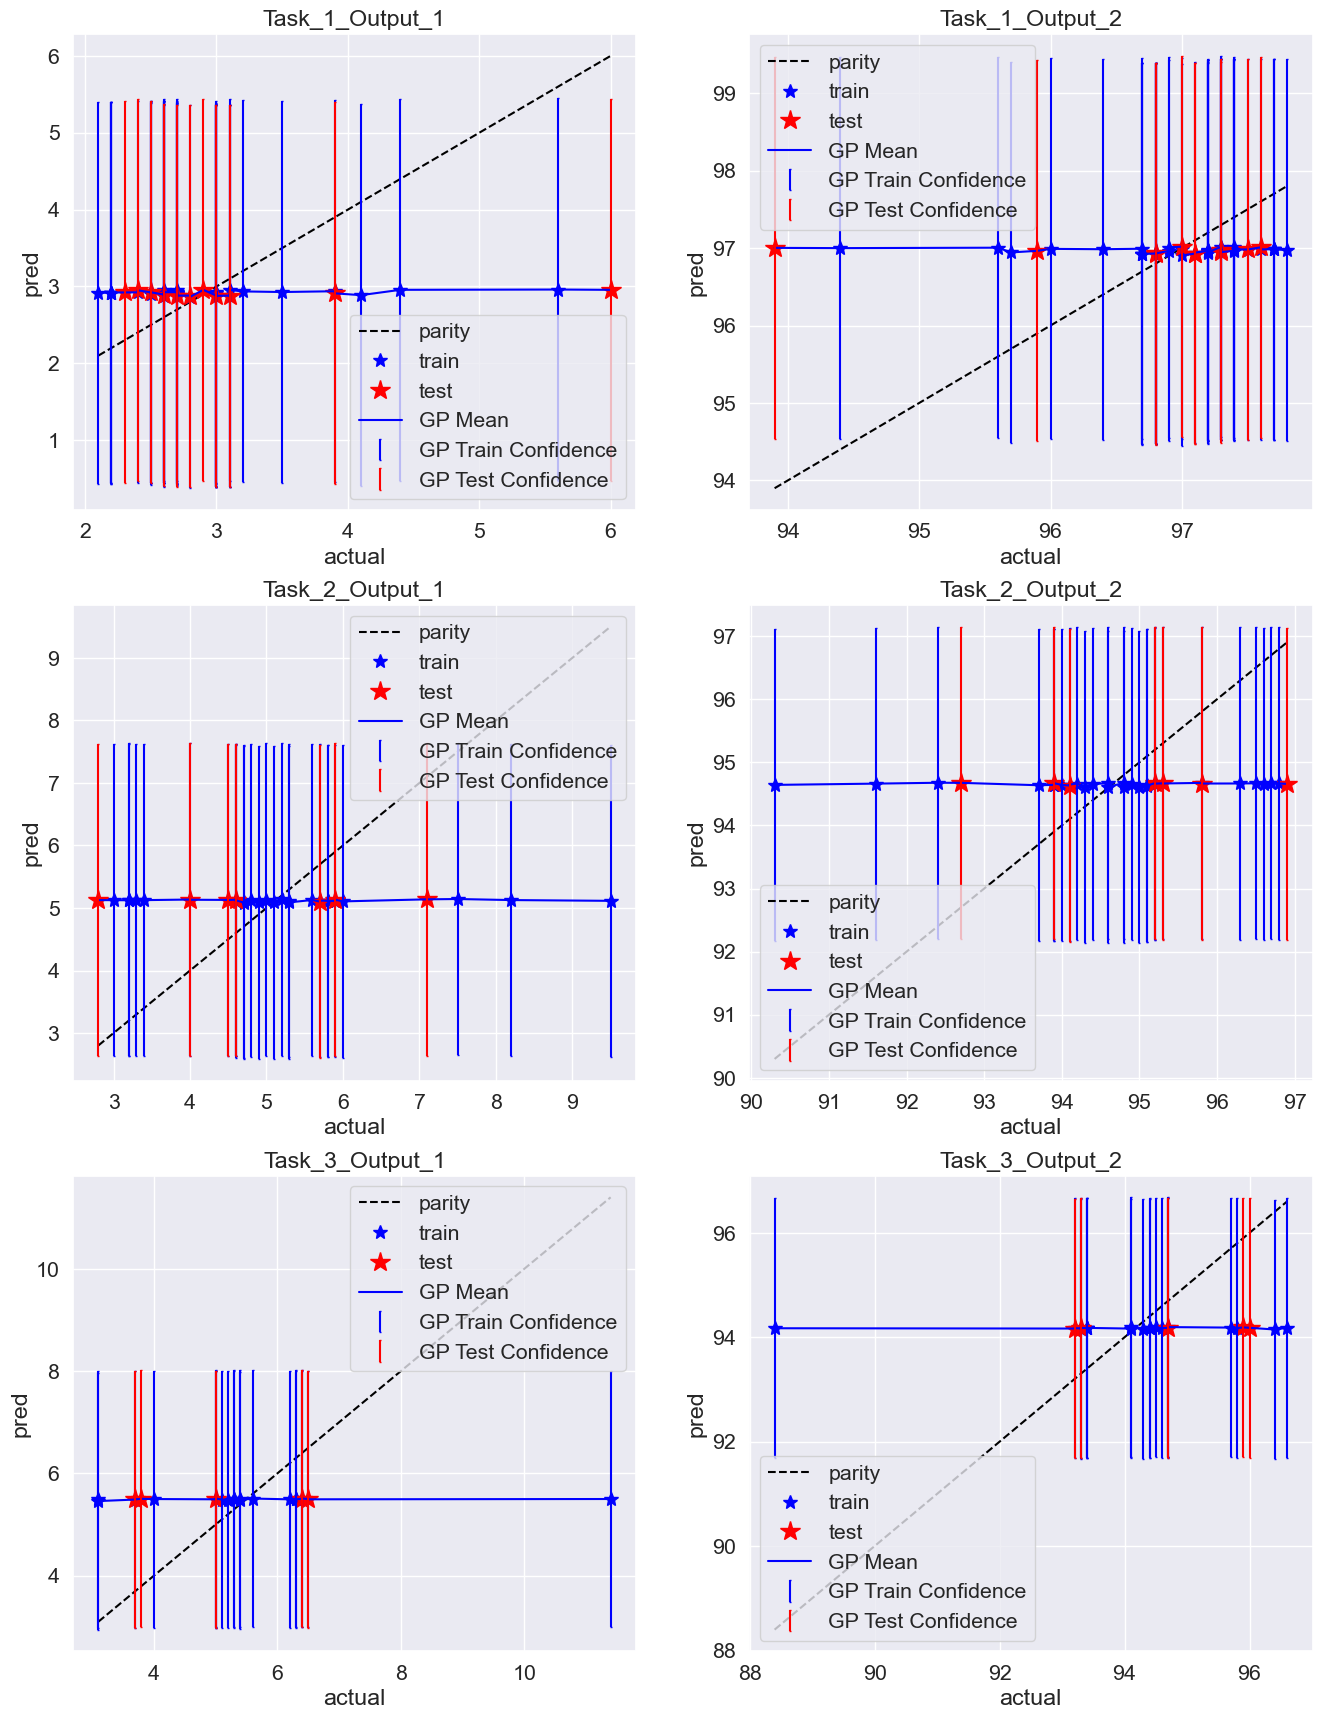

In [152]:
from sklearn.metrics import mean_squared_error

uncertainty_figure_option = 'errorbar' #shade or errorbar
is_set_axis_limit = False

#df_y = total_df_y_long
plot_axis_lb = total_df_y_long.min(axis = 0) - 0.4 * total_df_y_long.std(axis = 0)
plot_axis_ub = total_df_y_long.max(axis = 0) + 0.4 * total_df_y_long.std(axis = 0)

#num_outputs = arr_train_y.shape[-1]
#num_tasks = len(np.unique(arr_train_x[..., -1]))
num_outputs = len(cols_target)
num_tasks = len(df_x['task_ind'].unique())

num_total_output = num_outputs*num_tasks
arr_train_metrics = np.zeros((11,num_total_output))
arr_test_metrics = np.zeros((11,num_total_output))
cols_target_wide = []

# Initialize plots
#f, y_axes = plt.subplots(num_tasks, num_outputs, figsize=(16, 48))
f, y_axes = plt.subplots(num_tasks, num_outputs, figsize=(num_outputs*8, num_tasks*7))
y_axes = y_axes.ravel()
for task_ind in range(num_tasks):
  for j,_ in enumerate(cols_target):
    a = j + len(cols_target)*task_ind
    #tmp_col_y = cols_target_new[a]
    tmp_col_y = 'Task_'+str(task_ind+1) + '_Output_'+str(j+1)
    cols_target_wide.append(tmp_col_y)

    r_train_y = arr_train_y[arr_train_x[:,-1]==task_ind,j]
    r_train_mean_y =arr_train_mean[arr_train_x[:,-1]==task_ind,j]
    r_train_lower_y =arr_train_lower[arr_train_x[:,-1]==task_ind,j]
    r_train_upper_y =arr_train_upper[arr_train_x[:,-1]==task_ind,j]
    r_train_std = r_train_mean_y - r_train_lower_y

    r_test_y = arr_test_y[arr_test_x[:,-1]==task_ind,j]
    r_test_mean_y =arr_test_mean[arr_test_x[:,-1]==task_ind,j]
    r_test_lower_y =arr_test_lower[arr_test_x[:,-1]==task_ind,j]
    r_test_upper_y =arr_test_upper[arr_test_x[:,-1]==task_ind,j]
    r_test_std = r_test_mean_y - r_test_lower_y
    
    train_comp = np.concatenate((r_train_y.reshape(-1,1),r_train_mean_y.reshape(-1,1)),axis = 1)
    df_train_comp = pd.DataFrame(train_comp,columns = ['true','pred'])
    df_train_comp['upper'] = r_train_upper_y
    df_train_comp['lower'] = r_train_lower_y
    df_train_comp['mode'] = 'train'
    
    test_comp = np.concatenate((r_test_y.reshape(-1,1),r_test_mean_y.reshape(-1,1)),axis = 1)
    df_test_comp = pd.DataFrame(test_comp,columns = ['true','pred'])
    df_test_comp['upper'] = r_test_upper_y
    df_test_comp['lower'] = r_test_lower_y
    df_test_comp['mode'] = 'test'
    
    df_comp = pd.concat([df_train_comp,df_test_comp])
    df_comp_sorted = df_comp.sort_values(by = ['true'],ascending=True)

    #plot a parity line
    y_axes[a].plot(df_comp_sorted['true'], df_comp_sorted['true'], '--',c = 'black')
    
    # Plot training data as blue stars
    y_axes[a].plot(df_train_comp['true'], df_train_comp['pred'], 'k*',c = 'blue',markersize=10)

    # Plot training data as red stars
    y_axes[a].plot(df_test_comp['true'], df_test_comp['pred'], 'k*',c = 'red',markersize=15)
    # Predictive mean as blue line
    y_axes[a].plot(df_comp_sorted['true'], df_comp_sorted['pred'],c = 'blue')
    
    if uncertainty_figure_option == 'shade':
    # Shade in confidence
      y_axes[a].fill_between(x = df_comp_sorted['true'],y1 = df_comp_sorted['lower'], y2 = df_comp_sorted['upper'], color='b', alpha=.15)
    else:
      yerr = df_comp_sorted['pred'] - df_comp_sorted['lower']
      yerr = yerr.values.tolist()
      #y_axes[a].errorbar(x = df_comp_sorted['true'], y = df_comp_sorted['pred'], yerr = yerr, capsize=1, fmt='none', ecolor = 'black')
      yerr_train = df_train_comp['pred'] - df_train_comp['lower']
      yerr_train = yerr_train.values.tolist()
      yerr_test = df_test_comp['pred'] - df_test_comp['lower']
      yerr_test = yerr_test.values.tolist()
      y_axes[a].errorbar(x = df_train_comp['true'], y = df_train_comp['pred'], yerr = yerr_train, capsize=1, fmt='none', ecolor = 'blue')
      y_axes[a].errorbar(x = df_test_comp['true'], y = df_test_comp['pred'], yerr = yerr_test, capsize=1, fmt='none', ecolor = 'red')
    
    if is_set_axis_limit:
      y_axes[a].set_xlim([plot_axis_lb[j],plot_axis_ub[j]])
      y_axes[a].set_ylim([plot_axis_lb[j],plot_axis_ub[j]])

    #y_axes[a].legend(['parity','train','test','GP Mean','GP Confidence'])
    y_axes[a].legend(['parity','train','test','GP Mean','GP Train Confidence','GP Test Confidence'])
    y_axes[a].set_title(tmp_col_y)
    y_axes[a].set_xlabel('actual')
    y_axes[a].set_ylabel('pred')

    y_true = r_test_y
    y_pred = r_test_mean_y
    y_train = r_train_y
    mean_train = r_train_mean_y
    

    arr_test_metrics[0,a] = np.round(metrics.mean_absolute_error(y_true, y_pred),2)
    arr_test_metrics[1,a] = np.round(metrics.median_absolute_error(y_true, y_pred),2)
    arr_test_metrics[2,a] = np.round(metrics.mean_squared_error(y_true, y_pred),2)
    arr_test_metrics[3,a] = round(metrics.mean_squared_error(y_true, y_pred),2)
    arr_test_metrics[4,a] = round(metrics.mean_absolute_percentage_error(y_true, y_pred),2)
    arr_test_metrics[5,a] = round(metrics.max_error(y_true, y_pred),2)
    arr_test_metrics[6,a] = round(metrics.explained_variance_score(y_true, y_pred),2)
    arr_test_metrics[7,a] = round(metrics.r2_score(y_true, y_pred),2)
    arr_test_metrics[8,a] = round(np.mean(r_test_std),2)
    arr_test_metrics[9,a] = round(np.min(r_test_std),2)
    arr_test_metrics[10,a] = round(np.max(r_test_std),2)

    arr_train_metrics[0,a] = round(metrics.mean_absolute_error(y_train, mean_train),2)
    arr_train_metrics[1,a] = round(metrics.median_absolute_error(y_train, mean_train),2)
    arr_train_metrics[2,a] = round(metrics.mean_squared_error(y_train, mean_train),2)
    arr_train_metrics[3,a] = round(metrics.mean_squared_error(y_train, mean_train),2)
    arr_train_metrics[4,a] = round(metrics.mean_absolute_percentage_error(y_train, mean_train),2)
    arr_train_metrics[5,a] = round(metrics.max_error(y_train, mean_train),2)
    arr_train_metrics[6,a] = round(metrics.explained_variance_score(y_train, mean_train),2)
    arr_train_metrics[7,a] = round(metrics.r2_score(y_train, mean_train),2)
    arr_train_metrics[8,a] = round(np.mean(r_train_std),2)
    arr_train_metrics[9,a] = round(np.min(r_train_std),2)
    arr_train_metrics[10,a] = round(np.max(r_train_std),2)
    #arr_train_metrics[11,i] = my_gpr.kernel_.get_params()['k1__constant_value']
    #arr_train_metrics[12,i] = my_gpr.kernel_.get_params()['k2__length_scale']


if uncertainty_figure_option == 'shade' and is_set_axis_limit:
  plt.savefig(figPath+'/true-pred-shade.jpg')
elif uncertainty_figure_option == 'shade' and ~is_set_axis_limit:
  plt.savefig(figPath+'/true-pred-shade-zoomin.jpg')
elif uncertainty_figure_option == 'errorbar' and is_set_axis_limit:
  plt.savefig(figPath+'/true-pred-errorbar.jpg')
elif uncertainty_figure_option == 'errorbar' and ~is_set_axis_limit:
  plt.savefig(figPath+'/true-pred-errorbar-zoomin.jpg')

df_test_metrics = pd.DataFrame(arr_test_metrics,columns = cols_target_wide, 
                               index = ['MAE','MAE2','MSE','RMSE','MAPE','MAXE','EVS','R2','AVG_STD','MIN_STD','MAX_STD'])
print(df_test_metrics)

df_train_metrics = pd.DataFrame(arr_train_metrics,columns = cols_target_wide, 
                               index = ['MAE','MAE2','MSE','RMSE','MAPE','MAXE','EVS','R2','AVG_STD','MIN_STD','MAX_STD'])
print(df_train_metrics)


df_train_metrics.to_csv(figPath+'/df_train_metrics.csv')
df_test_metrics.to_csv(figPath+'/df_test_metrics.csv')

In [522]:
from autograd import grad, value_and_grad
import autograd.numpy as np
from autograd.misc.optimizers import adam
import autograd.scipy.stats.multivariate_normal as mvn
from scipy.optimize import minimize

def rbf_kernel(x1, x2):
	output_scale = 1
	lengthscales = 1
	diffs = np.expand_dims(x1 / lengthscales, 1)\
		  - np.expand_dims(x2 / lengthscales, 0)
	return output_scale * np.exp(-0.5 / 10 * np.sum(diffs**2, axis=2))

def gaussian_log_likelihood(X, mean, covar, sigma2=1):
	#ll = np.sum([MultivariateNormal(mean, covar).log_prob(X[:, ii]).numpy() for ii in range(D)])
	ll = np.sum([mvn.logpdf(X[:, ii], mean, covar) for ii in range(D)])
	return ll

def gaussian_prior(Z):
	#covar = torch.eye(n)
	#mean = torch.zeros(n)
	#ll = np.sum([MultivariateNormal(mean, covar).log_prob(Z[:, ii]).numpy() for ii in range(d)])
	covar = np.eye(n)
	mean = np.zeros(n)
	ll = np.sum([mvn.logpdf(Z[:, ii], mean, covar) for ii in range(d)])
	return ll

def objective(Z):
	# The objective is the negative log likelihood of the data.
	Z = np.reshape(Z, (n, d))
	cov_mat = kernel(Z, Z) + np.eye(n)
	#Z = torch.tensor(Z)
	#Z = Z.float()
	#cov_mat = torch.tensor(kernel(Z, Z)) + torch.eye(n)
	#ll = gaussian_log_likelihood(X, zero_mean, cov_mat.float())
	ll = gaussian_log_likelihood(X, zero_mean, cov_mat)
	lprior = gaussian_prior(Z)
	return -(ll + lprior)

In [523]:
def callback(params):
	print('Log likelihood: {0:1.3e}'.format(-objective(params)))

	Z = np.reshape(params, (n, d))

	data_ax.cla()
	#data_ax.scatter(X[:, 0], X[:, 1], c=Z[:, 0])
	data_ax.scatter(X[:, 0], X[:, 1], c=X0[:,-1])
	data_ax.set_title('Observed Data')
	data_ax.set_xlabel(r"$x1$")
	data_ax.set_ylabel(r"$x2$")

	latent_ax.cla()
	#latent_ax.plot(X[:, 0], Z[:, 0], 'kx')
	latent_ax.plot(X[:, 0], Z[:, 0])
	latent_ax.set_xlim([-2, 2])
	latent_ax.set_ylim([-2, 2])
	latent_ax.set_xlabel(r"$x1$")
	latent_ax.set_ylabel(r"$z$")
	latent_ax.set_title('Latent coordinates')

	plt.draw()
	plt.pause(1.0/60.0)
	plt.show(block=False)

In [610]:
pH_lb_by_buffer_dict = {0:3.7,1:5,2:3.7,3:6.2}
pH_ub_by_buffer_dict = {0:5.7,1:7,2:5.7,3:8.2}
buffer_dict = {0:'Ace',1:'His',2:'Cit',3:'Phos'}

In [713]:
np.random.seed(2024)
n_buffer_level = df_X['Buffer_Type_label'].unique().shape[0]
n_salt_level = df_X['Sugar_Salt_label'].unique().shape[0]
n_add_level = df_X['Additive_label'].unique().shape[0]
"""
task_idx = 0
new_train_mean =  arr_train_mean[df_X_train['task_ind']==task_idx,1] - arr_train_mean[df_X_train['task_ind']==task_idx,0] #monomer - hmw
best_idx = np.argmax(new_train_mean)
df_X_train_task = df_X_train[df_X_train['task_ind']==task_idx]
df_X_train_task.iloc[best_idx,:]
"""

"""
df_X_syn_t1= df_X_train.copy()
df_X_syn_t1['Buffer_Type_label'] = syn_buffer_type
df_X_syn_t1['Sugar_Salt_label'] =syn_salt_type
df_X_syn_t1['Additive_label'] = syn_additive_type
df_X_syn_t1['pH'] = y
df_X_syn_t1['task_ind'] = 0


df_X_syn_t2= df_X_train.copy()
df_X_syn_t2['Buffer_Type_label'] = syn_buffer_type
df_X_syn_t2['Sugar_Salt_label'] =syn_salt_type
df_X_syn_t2['Additive_label'] =syn_additive_type
df_X_syn_t2['pH'] = y
df_X_syn_t2['task_ind'] = 1


df_X_syn_t3= df_X_train.copy()
df_X_syn_t3['Buffer_Type_label'] = syn_buffer_type
df_X_syn_t3['Sugar_Salt_label'] =syn_salt_type
df_X_syn_t3['Additive_label'] = syn_additive_type
df_X_syn_t3['pH'] = y
df_X_syn_t3['task_ind'] = 2
"""

#https://stackoverflow.com/questions/27499139/how-can-i-set-a-minimum-distance-constraint-for-generating-points-with-numpy-ran
# specify params

df_X_train_copy = pd.concat([df_X_train,df_X_train])
df_X_train_copy.reset_index(inplace = True, drop = True)
n = len(df_X_train_copy)
shape = np.array([64, 64])
sensitivity = 0.8 # 0 means no movement, 1 means max distance is init_dist

# compute grid shape based on number of points
width_ratio = shape[1] / shape[0]
num_y = n
#num_y = np.int32(np.sqrt(n / width_ratio)) + 1
#num_x = np.int32(n / num_y) + 1

ls_df_X_syn_b = []
ls_df_y_syn_b = []
ls_x_syn_new_b = []
ls_x_syn_gplvm_b = []
for buffer_type_idx in range(n_buffer_level):
        print('==============='+buffer_dict[buffer_type_idx]+'==========')
        
        df_X_train_buffer = df_X_train[df_X_train['Buffer_Type_label']==buffer_type_idx]
        new_train_mean =  arr_train_mean[df_X_train['Buffer_Type_label']==buffer_type_idx,1] - arr_train_mean[df_X_train['Buffer_Type_label']==buffer_type_idx,0] #monomer - hmw
        best_idx_by_buffer = np.argmax(new_train_mean)
        #for task_idx in range(num_tasks):
        """
        
        
        print(df_X_train_buffer.iloc[best_idx,:])
        """

        # create regularly spaced neurons
        #x = np.linspace(0., shape[1]-1, num_x, dtype=np.float32)
        #y = np.linspace(df_X_train_buffer.iloc[best_idx,3] - 1, 
        #                df_X_train_buffer.iloc[best_idx,3] + 1, 
        #                num_y, dtype=np.float32)
        y = np.linspace(pH_lb_by_buffer_dict[buffer_type_idx], 
                        pH_ub_by_buffer_dict[buffer_type_idx], 
                        num_y, dtype=np.float32)
        #coords = np.stack(np.meshgrid(x, y), -1).reshape(-1,2)

        # compute spacing
        init_dist = y[1]-y[0]
        min_dist = init_dist * (1 - sensitivity)

        assert init_dist >= min_dist
        #print(min_dist)

        # perturb points
        max_movement = (init_dist - min_dist)/2
        noise = np.random.uniform(
                low=-max_movement,
                high=max_movement,
                size=y.shape[0])
        y += noise

        # plot
        #plt.figure(figsize=(10*width_ratio,10))
        #plt.scatter(coords[:,0], coords[:,1], s=3)
        #plt.show()


        #syn_buffer_type = np.random.choice(range(n_buffer_level),len(df_X_train))
        syn_salt_type = np.random.choice(range(n_salt_level),len(df_X_train_copy))
        syn_additive_type = np.random.choice(range(n_add_level),len(df_X_train_copy))

        syn_buffer_type = buffer_type_idx
        #syn_salt_type = df_X_train_buffer.iloc[best_idx,1]
        #syn_additive_type = df_X_train_buffer.iloc[best_idx,2]

        df_X_syn_b= df_X_train_copy.copy()
        df_X_syn_b['Buffer_Type_label'] = syn_buffer_type
        df_X_syn_b['Sugar_Salt_label'] =syn_salt_type
        df_X_syn_b['Additive_label'] = syn_additive_type
        df_X_syn_b['pH'] = y
        
        scaled_X_syn=xct.transform(df_X_syn_b)
        t_syn_x = torch.Tensor(scaled_X_syn)
        # Set into eval mode
        gp_model.eval()
        gp_model.likelihood.eval()

        with torch.no_grad(), gpytorch.settings.fast_pred_var():
                syn_pred = gp_model.likelihood(gp_model(t_syn_x))   
                syn_mean = syn_pred.mean
                syn_lower, syn_upper = syn_pred.confidence_region()

                x_cate_syn = t_syn_x[:,gp_model.qual_kernel_columns[0]]
                #x_cate_train = t_train_x[:,gp_model.qual_kernel_columns[0]]
                x_syn_embed = torch.zeros(x_cate_syn.shape[0],gp_model.lv_dim)
                for task_ind in range(gp_model._num_tasks):
                        #transformed categorical value
                        x_cate_syn_per_task = x_cate_syn[t_syn_x[:,-1]==task_ind]
                        row_idx_syn = (t_syn_x[:,-1]==task_ind).nonzero(as_tuple=True)[0]
                        x_syn_cate_zeta = gp_model.transform_categorical(x_cate_syn_per_task.clone().type(torch.int64).to('cpu'),
                                                  perm_dict = gp_model.perm_dict[0], zeta = gp_model.zeta[0])
                        x_syn_cate_latent = gp_model.A_matrix[task_ind](x_syn_cate_zeta.float().to('cpu'))
                        x_syn_embed[row_idx_syn] = x_syn_cate_latent
        
                x_syn_new_b = torch.cat([x_syn_embed,t_syn_x[...,gp_model.quant_index.long()].to(**gp_model.tkwargs)],dim=-1)
                ls_x_syn_new_b.append(x_syn_new_b)
                if gp_model.is_mix_reduce:
                        x_syn_gplvm_b = gp_model.W_matrix(x_syn_new_b.float().to('cpu'))
                        ls_x_syn_gplvm_b.append(x_syn_gplvm_b)
                
        arr_syn_x = t_syn_x.detach().numpy()
        arr_syn_mean = y_scaler.inverse_transform(syn_mean)
        arr_syn_lower = y_scaler.inverse_transform(syn_lower)
        arr_syn_upper = y_scaler.inverse_transform(syn_upper)
        df_y_syn_b = pd.DataFrame(arr_syn_mean,columns=df_y_train.columns)
        #calculate expected improvement
        new_syn_mean =  arr_syn_mean[:,1] - arr_syn_mean[:,0]
        y_std = np.mean(arr_syn_upper - arr_syn_mean,axis = 1)
        z = (new_syn_mean - new_train_mean[best_idx_by_buffer])/y_std
        ei = (new_syn_mean - new_train_mean[best_idx_by_buffer])*norm.cdf(z) + y_std*norm.pdf(z)
        df_y_syn_b['ei'] = ei

        
        #best_syn_idx = np.argmax(ei)
        for task_idx in range(num_tasks):
                print('task'+str(task_idx)+':')
                print('==Among training data==')
                train_mean_by_task =  new_train_mean[df_X_train_buffer['task_ind']==task_idx]
                best_train_idx = np.argmax(train_mean_by_task)
                df_X_train_buffer_t = df_X_train_buffer[df_X_train_buffer['task_ind']==task_idx]
                with pd.option_context('display.float_format', '{:0.1f}'.format):
                        print(df_X_train_buffer_t.iloc[best_train_idx,:])
                
                print('==After simulation==')
                syn_mean_by_task =  new_syn_mean[df_X_syn_b['task_ind']==task_idx]
                best_syn_idx = np.argmax(syn_mean_by_task)
                df_X_syn_b_t = df_X_syn_b[df_X_syn_b['task_ind']==task_idx]
                with pd.option_context('display.float_format', '{:0.1f}'.format):
                        print(df_X_syn_b_t.iloc[best_syn_idx,:])

        ls_df_X_syn_b.append(df_X_syn_b)
        ls_df_y_syn_b.append(df_y_syn_b)
        
        
        
df_X_syn = pd.concat(ls_df_X_syn_b)
df_y_syn = pd.concat(ls_df_y_syn_b)
x_syn_new = torch.cat(ls_x_syn_new_b, 0)
if gp_model.is_mix_reduce:
        x_syn_gplvm = torch.cat(ls_x_syn_gplvm_b, 0)

===============Ace==========
task0:
==Among training data==
Buffer_Type_label   0.0
Sugar_Salt_label    0.0
Additive_label      1.0
pH                  4.5
task_ind            0.0
Name: 1, dtype: float64
==After simulation==
Buffer_Type_label   0.0
Sugar_Salt_label    0.0
Additive_label      1.0
pH                  3.8
task_ind            0.0
Name: 4, dtype: float64
task1:
==Among training data==
Buffer_Type_label   0.0
Sugar_Salt_label    0.0
Additive_label      1.0
pH                  4.5
task_ind            1.0
Name: 25, dtype: float64
==After simulation==
Buffer_Type_label   0.0
Sugar_Salt_label    1.0
Additive_label      0.0
pH                  3.7
task_ind            1.0
Name: 1, dtype: float64
task2:
==Among training data==
Buffer_Type_label   0.0
Sugar_Salt_label    0.0
Additive_label      1.0
pH                  4.5
task_ind            2.0
Name: 49, dtype: float64
==After simulation==
Buffer_Type_label   0.0
Sugar_Salt_label    0.0
Additive_label      1.0
pH                  3

Log likelihood: -3.565e+03


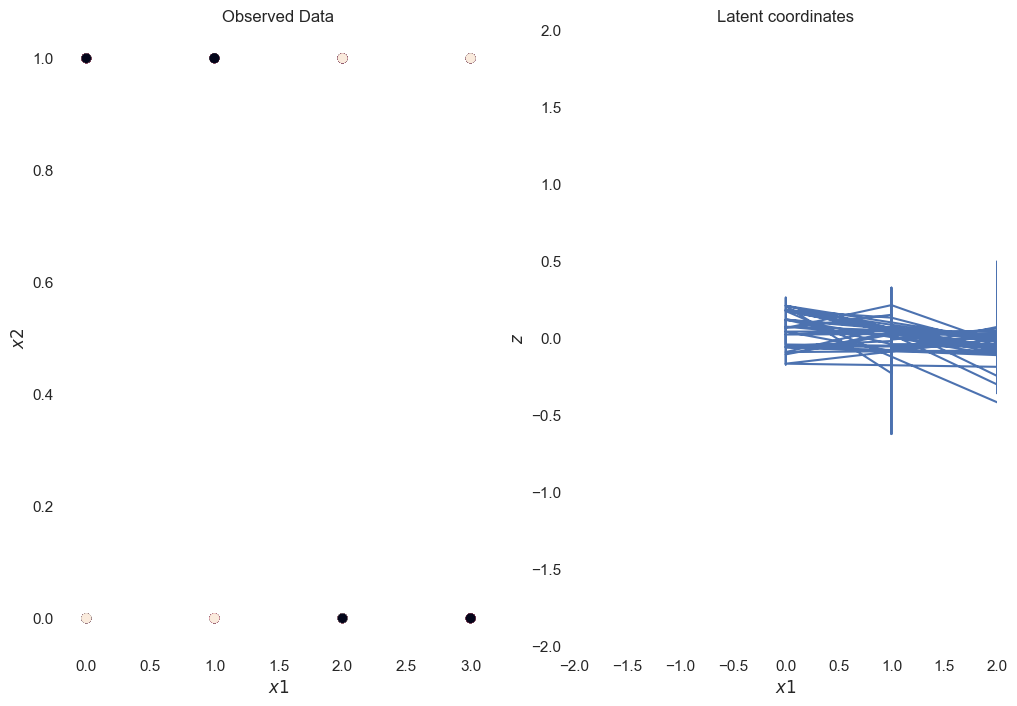

Log likelihood: -3.534e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -3.338e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -3.294e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -3.267e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -3.242e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -3.235e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -3.230e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -3.229e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -3.229e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -3.229e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -3.229e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -3.229e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -3.229e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -3.229e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -3.229e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -3.229e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -3.229e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -3.229e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -3.229e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -3.229e+03


<Figure size 640x480 with 0 Axes>

In [714]:
fig = plt.figure(figsize=(12,8), facecolor='white')
data_ax = fig.add_subplot(121, frameon=False)
latent_ax = fig.add_subplot(122, frameon=False)

kernel = rbf_kernel
#X0 = df_X.to_numpy()
df_X_full = pd.concat([df_X_train,df_X_test,df_X_syn])
X0 = df_X_full.to_numpy()
X = X0[:,:-1]

n,D = X.shape
d = 2
zero_mean = np.zeros(n)

init_params = np.random.normal(size=(n * d))

res = minimize(value_and_grad(objective), init_params, 
               jac=True, method='CG', options = {'maxiter':10000},
               callback = callback)

fitted_Zx = np.reshape(res.x, (n, d))


Log likelihood: -1.041e+04


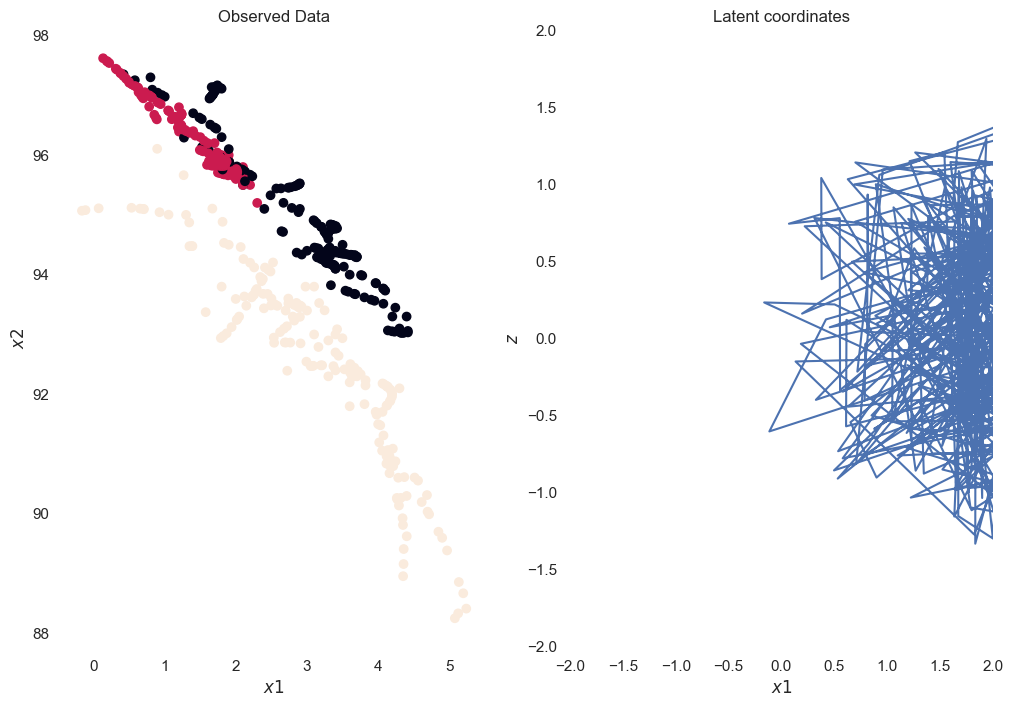

Log likelihood: -9.885e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -8.229e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -7.593e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -7.312e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -7.193e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -7.128e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -7.081e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -7.054e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -7.041e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -7.027e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -7.014e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -7.006e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.987e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.974e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.936e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.910e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.873e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.847e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.839e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.807e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.786e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.771e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.760e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.749e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.740e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.732e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.728e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.726e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.724e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.723e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.722e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.722e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.722e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.721e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.721e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.721e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.721e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.720e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.720e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.720e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.720e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.720e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.720e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.720e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.720e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.720e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.720e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.720e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.720e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.720e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.720e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.720e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.720e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.720e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.720e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.720e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.720e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.720e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.720e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.720e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.720e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.720e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.720e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.720e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.720e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.720e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.720e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.720e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.720e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.720e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

Log likelihood: -6.719e+03


<Figure size 640x480 with 0 Axes>

In [715]:
fig = plt.figure(figsize=(12,8), facecolor='white')
data_ax = fig.add_subplot(121, frameon=False)
latent_ax = fig.add_subplot(122, frameon=False)

kernel = rbf_kernel
df_y_full = pd.concat([df_y_train,df_y_test,df_y_syn.iloc[:,0:2]])
X = df_y_full.to_numpy()
#X = df_y
n,D = X.shape
d = 2
zero_mean = np.zeros(n)

init_params = np.random.normal(size=(n * d))

res = minimize(value_and_grad(objective), init_params, 
               jac=True, method='CG', options = {'maxiter':10000},
               callback = callback)

fitted_Zy = np.reshape(res.x, (n, d))


/Users/chenya68/anaconda3/envs/gpplus-py39/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/chenya68/anaconda3/envs/gpplus-py39/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


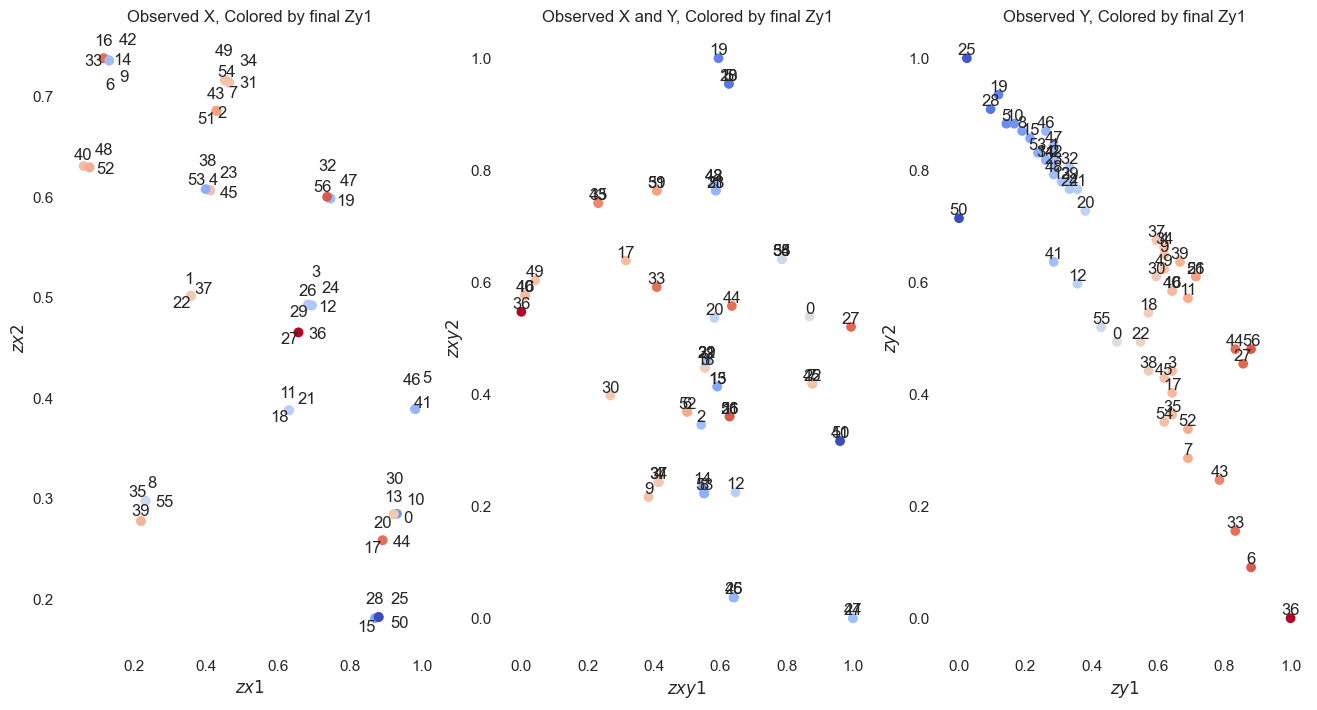

In [716]:
from adjustText import adjust_text
from matplotlib import colors
from mpl_toolkits import mplot3d

letters = list(map(chr, range(97, 123)))
scaled_y_test = y_scaler.transform(df_y_test.to_numpy())
scaled_y_syn = y_scaler.transform(df_y_syn.iloc[:,:2].to_numpy())

fit_zx_scaler = MinMaxScaler()
fit_zy_scaler = MinMaxScaler()
scaled_fitted_Zx = fit_zx_scaler.fit_transform(fitted_Zx)

scaled_train_fitted_Zx = scaled_fitted_Zx[:len(df_X_train)]
scaled_test_fitted_Zx = scaled_fitted_Zx[len(df_X_train):len(df_X)]
scaled_syn_fitted_Zx = scaled_fitted_Zx[len(df_X):]

scaled_fitted_Zy = fit_zy_scaler.fit_transform(fitted_Zy)
scaled_train_fitted_Zy = scaled_fitted_Zy[:len(df_X_train)]
scaled_test_fitted_Zy = scaled_fitted_Zy[len(df_X_train):len(df_X)]
scaled_syn_fitted_Zy = scaled_fitted_Zy[len(df_X):]

fit_zxy_scaler = MinMaxScaler()
if gp_model.is_mix_reduce:
    fitted_train_Zxy = x_train_gplvm.numpy()
    scaled_fitted_train_Zxy = fit_zxy_scaler.fit_transform(fitted_train_Zxy)
    scaled_fitted_test_Zxy = fit_zxy_scaler.transform(x_test_gplvm)
    scaled_fitted_syn_Zxy = fit_zxy_scaler.transform(x_syn_gplvm.detach())
else:
    fitted_train_Zxy = x_train_new.numpy()
    scaled_fitted_train_Zxy = fit_zxy_scaler.fit_transform(fitted_train_Zxy)
    scaled_fitted_test_Zxy = fit_zxy_scaler.transform(x_test_new)
    scaled_fitted_syn_Zxy = fit_zxy_scaler.transform(x_syn_new)



vmin, vcenter, vmax = np.min(scaled_y_train[:, 0]),np.mean(scaled_y_train[:, 0]),np.max(scaled_y_train[:, 0])
divnorm = colors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)

fig = plt.figure(figsize=(16,8), facecolor='white')
latent_ax1 = fig.add_subplot(131, frameon=False)
latent_ax2 = fig.add_subplot(132, frameon=False)
latent_ax3 = fig.add_subplot(133, frameon=False)



latent_ax1.cla()

latent_ax1.scatter(scaled_train_fitted_Zx[:, 0], scaled_train_fitted_Zx[:, 1], c = scaled_y_train[:, 0], cmap = 'coolwarm', norm = divnorm)

latent_ax3.cla()
latent_ax3.scatter(scaled_y_train[:, 0], scaled_y_train[:, 1], c = scaled_y_train[:, 0],cmap = 'coolwarm', norm = divnorm)

latent_ax1.set_xlabel(r"$zx1$")
latent_ax1.set_ylabel(r"$zx2$")
latent_ax3.set_xlabel(r"$zy1$")
latent_ax3.set_ylabel(r"$zy2$")
latent_ax1.set_title('Observed X, Colored by final Zy1')
latent_ax3.set_title('Observed Y, Colored by final Zy1')

# add labels to all points
texts = []
for i,(xi, yi) in enumerate(zip(scaled_train_fitted_Zx[:, 0], scaled_train_fitted_Zx[:, 1])):
    t = latent_ax1.text(xi, yi, i, va='bottom', ha='center')
    texts.append(t)
adjust_text(texts,ax = latent_ax1)

# add labels to all points
texts = []
for i,(xi, yi) in enumerate(zip(scaled_y_train[:, 0], scaled_y_train[:, 1])):
    t = latent_ax3.text(xi, yi, i, va='bottom', ha='center')
    texts.append(t)



latent_ax2.scatter(scaled_fitted_train_Zxy[:, 0], scaled_fitted_train_Zxy[:, 1], 
                   c = scaled_y_train[:, 0],cmap = 'coolwarm', norm = divnorm)

texts = []
for i0,(xi, yi) in enumerate(zip(scaled_fitted_train_Zxy[:, 0], scaled_fitted_train_Zxy[:, 1])):
        t = latent_ax2.text(xi, yi, i0, va='bottom', ha='center')
        texts.append(t)

latent_ax2.set_title('Observed X and Y, Colored by final Zy1')
latent_ax2.set_xlabel(r"$zxy1$")
latent_ax2.set_ylabel(r"$zxy2$")



plt.draw()
#plt.pause(1.0/60.0)
plt.show(block=False)
#plt.savefig(figPath+'/all-embeddings-scaled.jpg')

In [717]:
ls_markers = [ "^" , "o", "*"]
markers = ["." , "," , "o" , "v" , "^" , "<", ">"]
colors = ['r','g','b','y']
dict_markers = dict()
dict_colors = dict()
for i in range(num_tasks):
    dict_markers[i] = ls_markers[i]
    dict_colors[i] = colors[i]

df_train_plot = df_X_train.copy()
df_train_plot['marker'] = df_X_train['task_ind'].map(dict_markers)
df_train_plot['color']  = df_X_train['task_ind'].map(dict_colors)

df_train_plot['lx1']= scaled_train_fitted_Zx[:, 0]
df_train_plot['lx2']= scaled_train_fitted_Zx[:, 1]

df_train_plot['lxy1']= scaled_fitted_train_Zxy[:,0]
df_train_plot['lxy2']= scaled_fitted_train_Zxy[:,1]

df_train_plot['y1']= scaled_y_train[:, 0]
df_train_plot['y2']= scaled_y_train[:, 1]

#test plot df
df_test_plot = df_X_test.copy()
df_test_plot['marker'] = df_X_test['task_ind'].map(dict_markers)
df_test_plot['color']  = df_X_test['task_ind'].map(dict_colors)

df_test_plot['lx1']= scaled_test_fitted_Zx[:, 0]
df_test_plot['lx2']= scaled_test_fitted_Zx[:, 1]

df_test_plot['lxy1']= scaled_fitted_test_Zxy[:,0]
df_test_plot['lxy2']= scaled_fitted_test_Zxy[:,1]

df_test_plot['y1']= scaled_y_test[:, 0]
df_test_plot['y2']= scaled_y_test[:, 1]

"""
#syn plot df
df_syn_plot = df_X_syn.copy()
df_syn_plot['marker'] = df_X_syn['task_ind'].map(dict_markers)
df_syn_plot['color']  = df_X_syn['task_ind'].map(dict_colors)

df_syn_plot['lx1']= scaled_syn_fitted_Zx[:, 0]
df_syn_plot['lx2']= scaled_syn_fitted_Zx[:, 1]

df_syn_plot['lxy1']= scaled_fitted_syn_Zxy[:,0]
df_syn_plot['lxy2']= scaled_fitted_syn_Zxy[:,1]

df_syn_plot['y1']= scaled_y_syn[:, 0]
df_syn_plot['y2']= scaled_y_syn[:, 1]

df_syn_plot['ly1']= scaled_syn_fitted_Zy[:, 0]
df_syn_plot['ly2']= scaled_syn_fitted_Zy[:, 1]
"""

"\n#syn plot df\ndf_syn_plot = df_X_syn.copy()\ndf_syn_plot['marker'] = df_X_syn['task_ind'].map(dict_markers)\ndf_syn_plot['color']  = df_X_syn['task_ind'].map(dict_colors)\n\ndf_syn_plot['lx1']= scaled_syn_fitted_Zx[:, 0]\ndf_syn_plot['lx2']= scaled_syn_fitted_Zx[:, 1]\n\ndf_syn_plot['lxy1']= scaled_fitted_syn_Zxy[:,0]\ndf_syn_plot['lxy2']= scaled_fitted_syn_Zxy[:,1]\n\ndf_syn_plot['y1']= scaled_y_syn[:, 0]\ndf_syn_plot['y2']= scaled_y_syn[:, 1]\n\ndf_syn_plot['ly1']= scaled_syn_fitted_Zy[:, 0]\ndf_syn_plot['ly2']= scaled_syn_fitted_Zy[:, 1]\n"

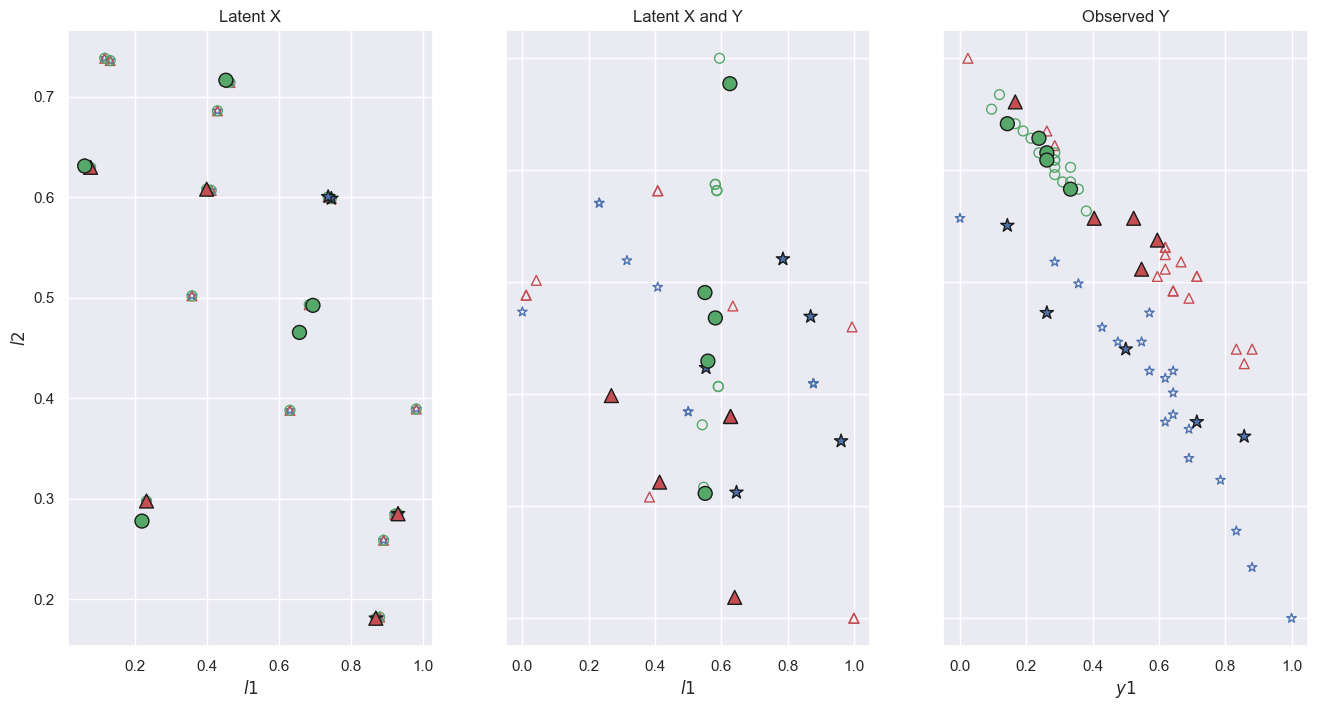

In [718]:

task_idx = t_train_x[:,-1].int()

ls_markers = [markers[i] for i in task_idx]
fig = plt.figure(figsize=(16,8), edgecolor='black')

latent_ax1 = fig.add_subplot(131)
latent_ax2 = fig.add_subplot(132)
latent_ax3 = fig.add_subplot(133)


for marker, d in df_train_plot.groupby('marker'):
    latent_ax1.scatter(x=d['lx1'], y=d['lx2'], edgecolors=d['color'], marker=marker, label=marker, 
                       facecolors='none',s = 50)

for marker, d in df_test_plot.groupby('marker'):
    latent_ax1.scatter(x=d['lx1'], y=d['lx2'], edgecolors='k', marker=marker, label=marker,
                       s = 100,facecolors=d['color'])
    

for marker, d in df_train_plot.groupby('marker'):
    latent_ax3.scatter(x=d['y1'], y=d['y2'], edgecolors=d['color'], marker=marker, label=marker, 
                       facecolors='none',s = 50)


for marker, d in df_test_plot.groupby('marker'):
    latent_ax3.scatter(x=d['y1'], y=d['y2'], edgecolors='k', marker=marker, label=marker, 
                       s= 100,facecolors=d['color'])


for marker, d in df_train_plot.groupby('marker'):
    latent_ax2.scatter(x=d['lxy1'], y=d['lxy2'], edgecolors=d['color'], marker=marker, label=marker, 
                       facecolors='none',s = 50)


for marker, d in df_test_plot.groupby('marker'):
    latent_ax2.scatter(x=d['lxy1'], y=d['lxy2'], edgecolors='k', marker=marker, label=marker, 
                       s = 100,facecolors=d['color'])



latent_ax1.set_xlabel(r"$l1$")
latent_ax1.set_ylabel(r"$l2$")
latent_ax3.set_xlabel(r"$y1$")
#latent_ax3.set_ylabel(r"$y2$")
latent_ax3.set_ylabel('')
latent_ax1.set_title('Latent X')
latent_ax3.set_title('Observed Y')

latent_ax2.set_title('Latent X and Y')
latent_ax2.set_xlabel(r"$l1$")
#latent_ax2.set_ylabel(r"$l2$")
latent_ax2.set_ylabel('')



latent_ax2.tick_params(
axis='y', # changes apply to the y-axis
which='both', # both major and minor ticks are affected
left=False, # ticks along the bottom edge are off
labelleft=False) # labels along the bottom edge are off

"""
latent_ax3.tick_params(
axis='x', # changes apply to the x-axis
which='both', # both major and minor ticks are affected
bottom=False, # ticks along the bottom edge are off
top=False, # ticks along the top edge are off
labelbottom=False) # labels along the bottom edge are off
"""

latent_ax3.tick_params(
axis='y', # changes apply to the y-axis
which='both', # both major and minor ticks are affected
left=False, # ticks along the bottom edge are off
labelleft=False) # labels along the bottom edge are off


plt.draw()
#plt.pause(1.0/60.0)
#plt.show(block=False)
#plt.savefig(figPath+'/all-embeddings-scaled.jpg')

## draw synthetic data

In [719]:
dict_buffers = dict()
ls_buffer_type = ['Acetate','Histidine','Citrate','Phosphate']
for buffer_type_idx in range(n_buffer_level):
    dict_buffers[buffer_type_idx] = ls_buffer_type[buffer_type_idx]

In [720]:
df_y_syn.reset_index(inplace = True, drop = True)
buffer_type_idx = 0

ls_markers = [ "^" , "o", "*",',']
#ls_markers = ["." , "," , "o" , "v" , "^" , "<", ">"]
colors = ['r','g','b','y']
dict_markers = dict()
dict_colors = dict()


for i in range(num_tasks):
    dict_markers[i] = ls_markers[i]
    #dict_colors[i] = colors[i]


for i in range(n_salt_level):
    dict_colors[i] = colors[i]

"""
for i in range(n_buffer_level):
    dict_markers[i] = ls_markers[i]
"""


#task_idx = 0
#syn plot df
df_X_syn.reset_index(inplace= True, drop = True)
#df_syn_plot = df_X_syn.copy()
df_syn_plot = df_X_syn[df_X_syn['Buffer_Type_label']==buffer_type_idx]
df_syn_plot['marker'] = df_X_syn['task_ind'].map(dict_markers)
#df_syn_plot['marker'] = df_X_syn['Buffer_Type_label'].map(dict_markers)
#df_syn_plot['color']  = df_X_syn['task_ind'].map(dict_colors)
#df_syn_plot['color']  = df_X_syn['Sugar_Salt_label'].map(dict_colors)
df_syn_plot['e_color']  = df_X_syn['Sugar_Salt_label'].map(dict_colors)

df_syn_plot['f_color'] = df_syn_plot['e_color']
df_syn_plot.loc[df_syn_plot.Additive_label != 0, 'f_color'] = 'w'


df_syn_plot['lx1']= scaled_syn_fitted_Zx[df_X_syn['Buffer_Type_label']==buffer_type_idx, 0]
df_syn_plot['lx2']= scaled_syn_fitted_Zx[df_X_syn['Buffer_Type_label']==buffer_type_idx, 1]

df_syn_plot['lxy1']= scaled_fitted_syn_Zxy[df_X_syn['Buffer_Type_label']==buffer_type_idx,0]
df_syn_plot['lxy2']= scaled_fitted_syn_Zxy[df_X_syn['Buffer_Type_label']==buffer_type_idx,1]

df_syn_plot['y1']= scaled_y_syn[df_X_syn['Buffer_Type_label']==buffer_type_idx, 0]
df_syn_plot['y2']= scaled_y_syn[df_X_syn['Buffer_Type_label']==buffer_type_idx, 1]

df_syn_plot['oy1']= df_y_syn.loc[df_X_syn['Buffer_Type_label']==buffer_type_idx, '_Dimer_HMW_']
df_syn_plot['oy2']= df_y_syn.loc[df_X_syn['Buffer_Type_label']==buffer_type_idx, '_Monomer']

df_syn_plot['ly1']= scaled_syn_fitted_Zy[df_X_syn['Buffer_Type_label']==buffer_type_idx, 0]
df_syn_plot['ly2']= scaled_syn_fitted_Zy[df_X_syn['Buffer_Type_label']==buffer_type_idx, 1]


"""
df_syn_plot['lx1']= scaled_syn_fitted_Zx[:, 0]
df_syn_plot['lx2']= scaled_syn_fitted_Zx[:, 1]

df_syn_plot['lxy1']= scaled_fitted_syn_Zxy[:,0]
df_syn_plot['lxy2']= scaled_fitted_syn_Zxy[:,1]

df_syn_plot['y1']= scaled_y_syn[:, 0]
df_syn_plot['y2']= scaled_y_syn[:, 1]

df_syn_plot['ly1']= scaled_syn_fitted_Zy[:, 0]
df_syn_plot['ly2']= scaled_syn_fitted_Zy[:, 1]
"""


/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_41952/3650070774.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_syn_plot['marker'] = df_X_syn['task_ind'].map(dict_markers)
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_41952/3650070774.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_syn_plot['e_color']  = df_X_syn['Sugar_Salt_label'].map(dict_colors)
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_41952/3650070774.py:36: SettingWithCopyWarning: 
A value is 

"\ndf_syn_plot['lx1']= scaled_syn_fitted_Zx[:, 0]\ndf_syn_plot['lx2']= scaled_syn_fitted_Zx[:, 1]\n\ndf_syn_plot['lxy1']= scaled_fitted_syn_Zxy[:,0]\ndf_syn_plot['lxy2']= scaled_fitted_syn_Zxy[:,1]\n\ndf_syn_plot['y1']= scaled_y_syn[:, 0]\ndf_syn_plot['y2']= scaled_y_syn[:, 1]\n\ndf_syn_plot['ly1']= scaled_syn_fitted_Zy[:, 0]\ndf_syn_plot['ly2']= scaled_syn_fitted_Zy[:, 1]\n"

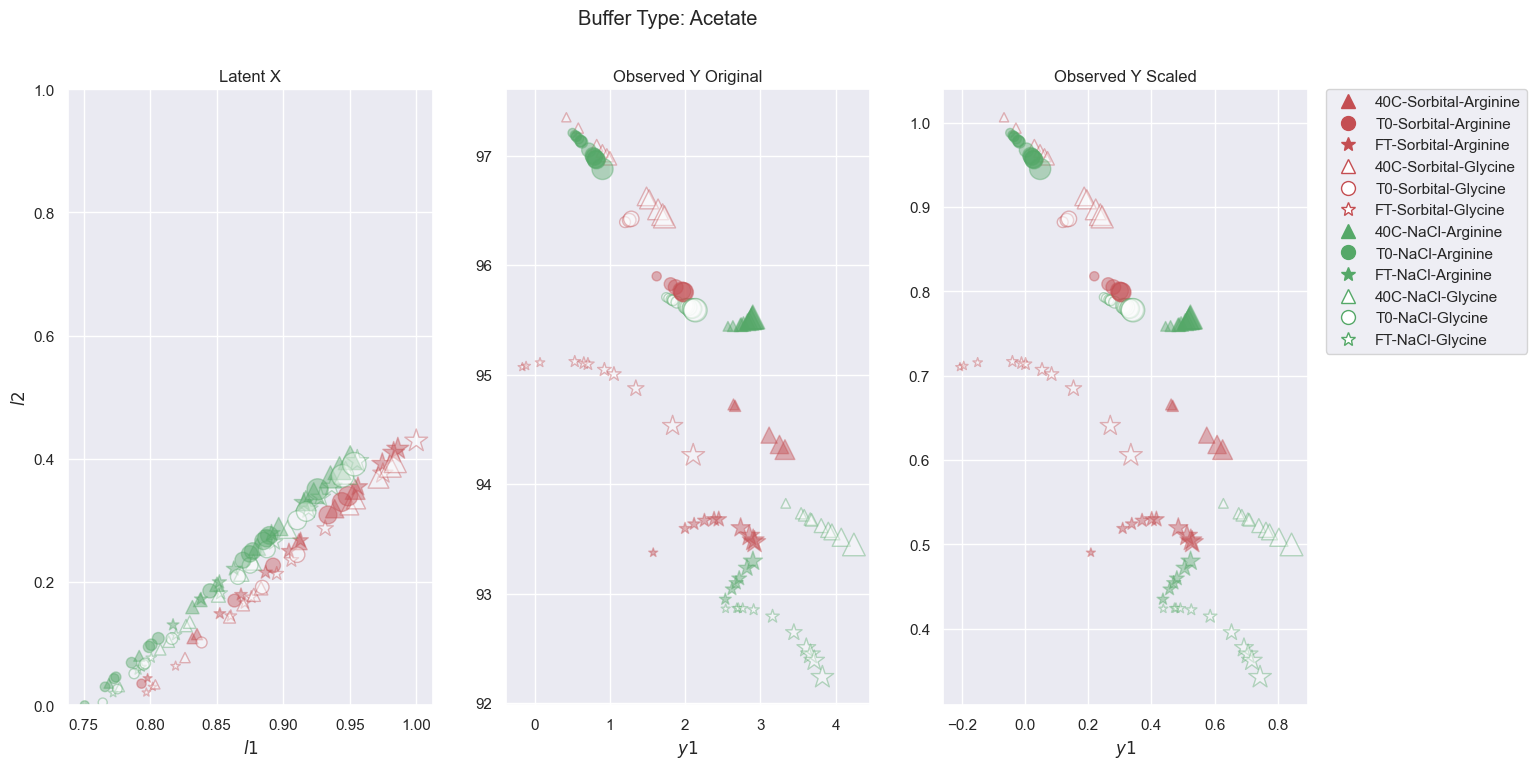

In [721]:
from matplotlib.lines import Line2D
custom = [Line2D([], [], marker=ls_markers[0], markersize=20, markerfacecolor=dict_colors[0], markeredgecolor=dict_colors[0], linestyle='None'),
          Line2D([], [], marker=ls_markers[1], markersize=20, markerfacecolor=dict_colors[0], markeredgecolor=dict_colors[0], linestyle='None'),
          Line2D([], [], marker=ls_markers[2], markersize=20, markerfacecolor=dict_colors[0], markeredgecolor=dict_colors[0], linestyle='None'),
          Line2D([], [], marker=ls_markers[0], markersize=20, markerfacecolor='white', markeredgecolor=dict_colors[0], linestyle='None'),
          Line2D([], [], marker=ls_markers[1], markersize=20, markerfacecolor='white', markeredgecolor=dict_colors[0], linestyle='None'),
          Line2D([], [], marker=ls_markers[2], markersize=20, markerfacecolor='white', markeredgecolor=dict_colors[0], linestyle='None'),
          Line2D([], [], marker=ls_markers[0], markersize=20, markerfacecolor=dict_colors[1], markeredgecolor=dict_colors[1], linestyle='None'),
          Line2D([], [], marker=ls_markers[1], markersize=20, markerfacecolor=dict_colors[1], markeredgecolor=dict_colors[1], linestyle='None'),
          Line2D([], [], marker=ls_markers[2], markersize=20, markerfacecolor=dict_colors[1], markeredgecolor=dict_colors[1], linestyle='None'),
          Line2D([], [], marker=ls_markers[0], markersize=20, markerfacecolor='white', markeredgecolor=dict_colors[1], linestyle='None'),
          Line2D([], [], marker=ls_markers[1], markersize=20, markerfacecolor='white', markeredgecolor=dict_colors[1], linestyle='None'),
          Line2D([], [], marker=ls_markers[2], markersize=20, markerfacecolor='white', markeredgecolor=dict_colors[1], linestyle='None')]

fig = plt.figure(figsize=(16,8), edgecolor='black')

latent_ax1 = fig.add_subplot(131)
latent_ax2 = fig.add_subplot(132)
latent_ax3 = fig.add_subplot(133)


#s = np.power(np.exp(d['pH'].values),2)/10
#s = np.exp(d['pH'].values)
for marker, d in df_syn_plot.groupby('marker'):
    scatter1 = latent_ax1.scatter(x=d['lx1'], y=d['lx2'], edgecolors=d['e_color'], marker=marker,
                                  label = marker,
                       s = np.exp(d['pH'].values)*1,facecolors=d['f_color'],alpha = 0.4)

for marker, d in df_syn_plot.groupby('marker'):
    scatter2 = latent_ax2.scatter(x=d['oy1'], y=d['oy2'], edgecolors=d['e_color'], marker=marker, 
                       label = marker,
                       s = np.exp(d['pH'].values)*1,facecolors=d['f_color'],alpha = 0.4)

for marker, d in df_syn_plot.groupby('marker'):
    scatter3 = latent_ax3.scatter(x=d['y1'], y=d['y2'], edgecolors=d['e_color'], marker=marker,
                       label = marker,
                       s = np.exp(d['pH'].values)*1,facecolors=d['f_color'],alpha = 0.4)





latent_ax1.set_ylim(0,1)
latent_ax1.set_xlabel(r"$l1$")
latent_ax1.set_ylabel(r"$l2$")


latent_ax2.set_title('Observed Y Original')
latent_ax2.set_xlabel(r"$y1$")
#latent_ax2.set_ylabel(r"$y2$")
latent_ax2.set_ylabel('')

#latent_ax3.set_xlim(0,1)
#latent_ax3.set_ylim(0,1)
latent_ax3.set_xlabel(r"$y1$")
#latent_ax3.set_ylabel(r"$y2$")
latent_ax3.set_ylabel('')
latent_ax1.set_title('Latent X')
latent_ax3.set_title('Observed Y Scaled')


"""
latent_ax2.tick_params(
axis='y', # changes apply to the y-axis
which='both', # both major and minor ticks are affected
left=False, # ticks along the bottom edge are off
labelleft=False) # labels along the bottom edge are off



latent_ax3.tick_params(
axis='y', # changes apply to the y-axis
which='both', # both major and minor ticks are affected
left=False, # ticks along the bottom edge are off
labelleft=False
) # labels along the bottom edge are off
"""

"""
latent_ax3.legend(['40C','T0','FT'],
                  bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0,
                  markerscale=0.5)
"""


plt.legend(handles = custom,labels = ['40C-Sorbital-Arginine','T0-Sorbital-Arginine','FT-Sorbital-Arginine',
                                      '40C-Sorbital-Glycine','T0-Sorbital-Glycine','FT-Sorbital-Glycine',
                                      '40C-NaCl-Arginine','T0-NaCl-Arginine','FT-NaCl-Arginine',
                                      '40C-NaCl-Glycine','T0-NaCl-Glycine','FT-NaCl-Glycine'],
                  bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0,
                  markerscale=0.5)
#latent_ax3.add_artist(legend1)

"""
handles, labels = latent_ax3.get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0,
                  markerscale=0.5)




# produce a legend with a cross-section of sizes from the scatter
handles, labels = scatter3.legend_elements(prop="sizes", alpha=0.6)
legend2 = latent_ax3.legend(handles, labels, loc="upper right", title="Sizes")
"""

#plt.draw()


fig.suptitle('Buffer Type: '+str(dict_buffers[buffer_type_idx]))

#plt.pause(1.0/60.0)
plt.show(block=False)
#plt.savefig(figPath+'/all-embeddings-scaled-syn.jpg')

In [783]:
df_y_syn.columns

Index(['_Dimer_HMW_', '_Monomer', 'ei'], dtype='object')

/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_41952/4123515910.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_syn_plot['marker'] = df_X_syn['task_ind'].map(dict_markers)
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_41952/4123515910.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_syn_plot['e_color']  = df_X_syn['Sugar_Salt_label'].map(dict_colors)
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_41952/4123515910.py:28: SettingWithCopyWarning: 
A value is 

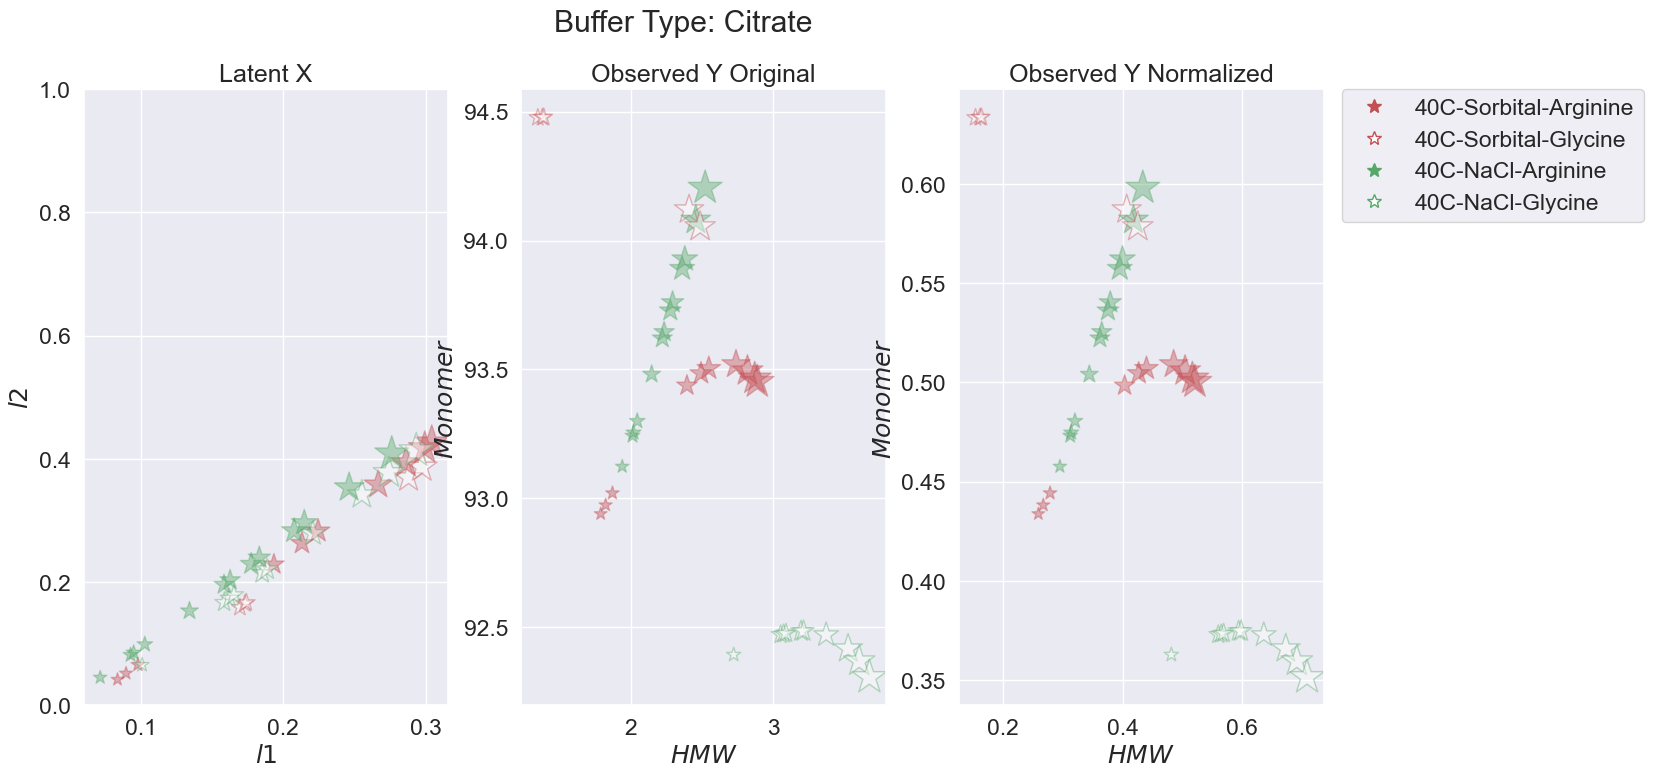

In [804]:
df_y_syn.reset_index(inplace = True, drop = True)
ls_task_names = ['T0','FT','40C']
buffer_type_idx = 2
task_idx = 2

ls_markers = [ "^" , "o", "*",',']
colors = ['r','g','b','y']
dict_markers = dict()
dict_colors = dict()


for i in range(num_tasks):
    dict_markers[i] = ls_markers[i]


for i in range(n_salt_level):
    dict_colors[i] = colors[i]




df_X_syn.reset_index(inplace= True, drop = True)

df_syn_plot = df_X_syn[(df_X_syn['Buffer_Type_label']==buffer_type_idx) & (df_X_syn['task_ind']==task_idx)]
df_syn_plot['marker'] = df_X_syn['task_ind'].map(dict_markers)
df_syn_plot['e_color']  = df_X_syn['Sugar_Salt_label'].map(dict_colors)

df_syn_plot['f_color'] = df_syn_plot['e_color']
df_syn_plot.loc[df_syn_plot.Additive_label != 0, 'f_color'] = 'w'


df_syn_plot['lx1']= scaled_syn_fitted_Zx[(df_X_syn['Buffer_Type_label']==buffer_type_idx) & (df_X_syn['task_ind']==task_idx), 0]
df_syn_plot['lx2']= scaled_syn_fitted_Zx[(df_X_syn['Buffer_Type_label']==buffer_type_idx) & (df_X_syn['task_ind']==task_idx), 1]

df_syn_plot['lxy1']= scaled_fitted_syn_Zxy[(df_X_syn['Buffer_Type_label']==buffer_type_idx) & (df_X_syn['task_ind']==task_idx),0]
df_syn_plot['lxy2']= scaled_fitted_syn_Zxy[(df_X_syn['Buffer_Type_label']==buffer_type_idx) & (df_X_syn['task_ind']==task_idx),1]

df_syn_plot['y1']= scaled_y_syn[(df_X_syn['Buffer_Type_label']==buffer_type_idx) & (df_X_syn['task_ind']==task_idx), 0]
df_syn_plot['y2']= scaled_y_syn[(df_X_syn['Buffer_Type_label']==buffer_type_idx) & (df_X_syn['task_ind']==task_idx), 1]

df_syn_plot['oy1']= df_y_syn.loc[(df_X_syn['Buffer_Type_label']==buffer_type_idx) & (df_X_syn['task_ind']==task_idx), '_Dimer_HMW_']
df_syn_plot['oy2']= df_y_syn.loc[(df_X_syn['Buffer_Type_label']==buffer_type_idx) & (df_X_syn['task_ind']==task_idx), '_Monomer']

df_syn_plot['ly1']= scaled_syn_fitted_Zy[(df_X_syn['Buffer_Type_label']==buffer_type_idx) & (df_X_syn['task_ind']==task_idx), 0]
df_syn_plot['ly2']= scaled_syn_fitted_Zy[(df_X_syn['Buffer_Type_label']==buffer_type_idx) & (df_X_syn['task_ind']==task_idx), 1]


custom = [Line2D([], [], marker=ls_markers[task_idx], markersize=20, markerfacecolor=dict_colors[0], markeredgecolor=dict_colors[0], linestyle='None'),
          Line2D([], [], marker=ls_markers[task_idx], markersize=20, markerfacecolor='white', markeredgecolor=dict_colors[0], linestyle='None'),
          Line2D([], [], marker=ls_markers[task_idx], markersize=20, markerfacecolor=dict_colors[1], markeredgecolor=dict_colors[1], linestyle='None'),
          Line2D([], [], marker=ls_markers[task_idx], markersize=20, markerfacecolor='white', markeredgecolor=dict_colors[1], linestyle='None')]

sns.set(font_scale=1.5)
fig = plt.figure(figsize=(16,8), edgecolor='black')

latent_ax1 = fig.add_subplot(131)
latent_ax2 = fig.add_subplot(132)
latent_ax3 = fig.add_subplot(133)


for marker, d in df_syn_plot.groupby('marker'):
    scatter1 = latent_ax1.scatter(x=d['lx1'], y=d['lx2'], edgecolors=d['e_color'], marker=marker,
                                  label = marker,
                       s = np.exp(d['pH'].values)*2.3,facecolors=d['f_color'],alpha = 0.4)

for marker, d in df_syn_plot.groupby('marker'):
    scatter2 = latent_ax2.scatter(x=d['oy1'], y=d['oy2'], edgecolors=d['e_color'], marker=marker, 
                       label = marker,
                       s = np.exp(d['pH'].values)*2.3,facecolors=d['f_color'],alpha = 0.4)

for marker, d in df_syn_plot.groupby('marker'):
    scatter3 = latent_ax3.scatter(x=d['y1'], y=d['y2'], edgecolors=d['e_color'], marker=marker,
                       label = marker,
                       s = np.exp(d['pH'].values)*2.3,facecolors=d['f_color'],alpha = 0.4)





latent_ax1.set_ylim(0,1)
latent_ax1.set_xlabel(r"$l1$")
latent_ax1.set_ylabel(r"$l2$")


latent_ax2.set_title('Observed Y Original')
latent_ax2.set_xlabel(r"$HMW$")
latent_ax2.set_ylabel(r"$Monomer$")

#latent_ax3.set_xlabel(r"$y1$")
#latent_ax3.set_ylabel(r"$y2$")
latent_ax3.set_xlabel(r"$HMW$")
latent_ax3.set_ylabel(r"$Monomer$")

latent_ax1.set_title('Latent X')
latent_ax3.set_title('Observed Y Normalized')



plt.legend(handles = custom,labels = [ls_task_names[task_idx]+'-Sorbital-Arginine',
                                      ls_task_names[task_idx]+'-Sorbital-Glycine',
                                      ls_task_names[task_idx]+'-NaCl-Arginine',
                                      ls_task_names[task_idx]+'-NaCl-Glycine'],
                  bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0,
                  markerscale=0.5)







fig.suptitle('Buffer Type: '+str(dict_buffers[buffer_type_idx]))
plt.show(block=False)



In [688]:

ls_markers = [ "^" , "o", "*",',']
#ls_markers = ["." , "," , "o" , "v" , "^" , "<", ">"]
colors = ['r','g','b','y']
dict_markers = dict()
dict_colors = dict()
for i in range(n_salt_level):
    dict_colors[i] = colors[i]

#n_buffer_level = df_X['Buffer_Type_label'].unique().shape[0]
for i in range(n_buffer_level):
    dict_markers[i] = ls_markers[i]



task_idx = 0

#df_X_train.reset_index(inplace= True, drop = True)

df_train_plot = df_X_train[df_X_train['task_ind']==task_idx]

df_train_plot['marker'] = df_X_train['Buffer_Type_label'].map(dict_markers)

df_train_plot['e_color']  = df_X_train['Sugar_Salt_label'].map(dict_colors)
df_train_plot['f_color'] = df_train_plot['e_color']
df_train_plot.loc[df_train_plot.Additive_label != 0, 'f_color'] = 'none'

df_train_plot['lx1']= scaled_train_fitted_Zx[df_X_train['task_ind']==task_idx, 0]
df_train_plot['lx2']= scaled_train_fitted_Zx[df_X_train['task_ind']==task_idx, 1]

df_train_plot['lxy1']= scaled_fitted_train_Zxy[df_X_train['task_ind']==task_idx,0]
df_train_plot['lxy2']= scaled_fitted_train_Zxy[df_X_train['task_ind']==task_idx,1]

df_train_plot['y1']= scaled_y_train[df_X_train['task_ind']==task_idx, 0]
df_train_plot['y2']= scaled_y_train[df_X_train['task_ind']==task_idx, 1]

df_train_plot['ly1']= scaled_train_fitted_Zy[df_X_train['task_ind']==task_idx, 0]
df_train_plot['ly2']= scaled_train_fitted_Zy[df_X_train['task_ind']==task_idx, 1]

df_train_plot_additive_0 = df_train_plot[df_X_train['Additive_label']==0]
df_train_plot_additive_1 = df_train_plot[df_X_train['Additive_label']==1]

/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_41952/2306088453.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_plot['marker'] = df_X_train['Buffer_Type_label'].map(dict_markers)
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_41952/2306088453.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_plot['e_color']  = df_X_train['Sugar_Salt_label'].map(dict_colors)
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_41952/2306088453.py:24: SettingWithCopyWarn

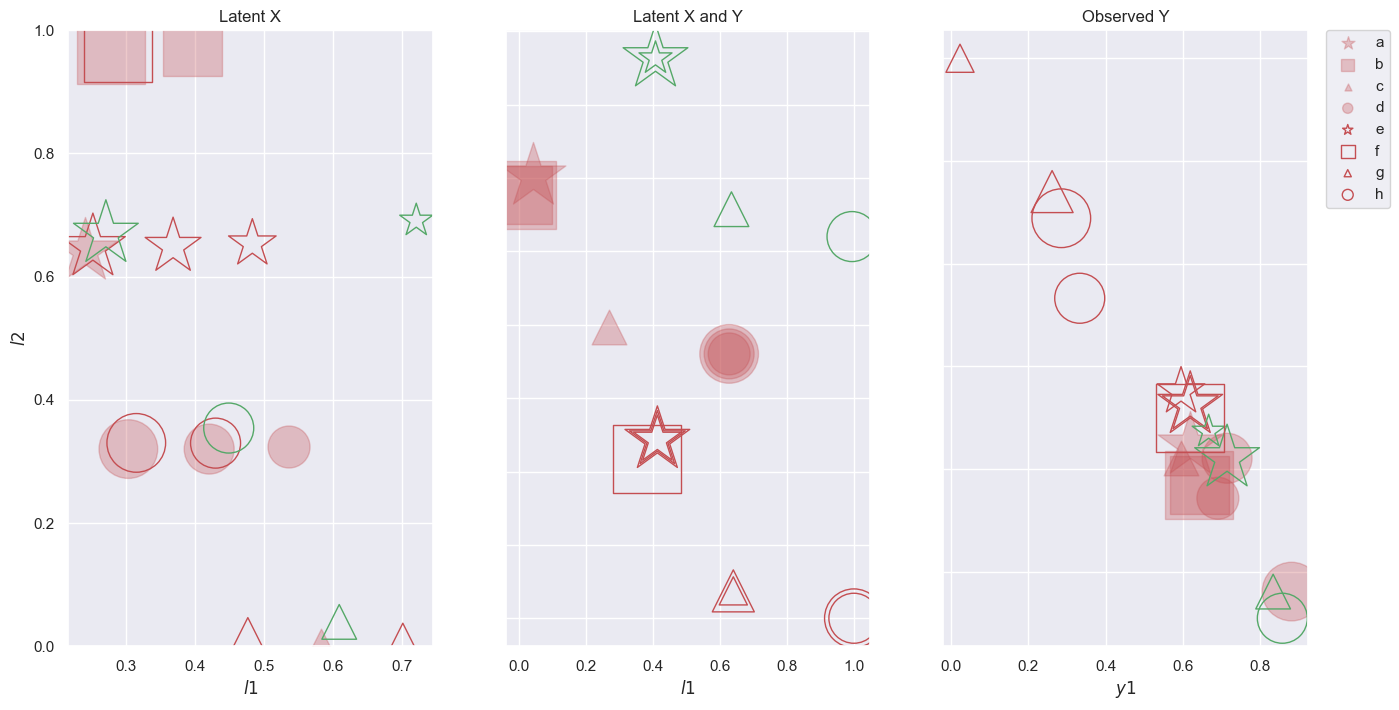

In [689]:
sns.set(font_scale=1)
fig = plt.figure(figsize=(16,8), edgecolor='black')

latent_ax1 = fig.add_subplot(131)
latent_ax2 = fig.add_subplot(132)
latent_ax3 = fig.add_subplot(133)

#embdding 1
for marker, d in df_train_plot_additive_0.groupby('marker'):
    latent_ax1.scatter(x=d['lx1'], y=d['lx2'], edgecolors=d['e_color'], marker=marker, label=marker,
                       s = np.power(d['pH'].values,4),facecolors=d['f_color'],alpha = 0.3)


for marker, d in df_train_plot_additive_1.groupby('marker'):
    latent_ax1.scatter(x=d['lx1'], y=d['lx2'], edgecolors=d['e_color'], marker=marker, label=marker,
                       s = np.power(d['pH'].values,4),facecolors='none')

#embdding 3
for marker, d in df_train_plot_additive_0.groupby('marker'):
    latent_ax3.scatter(x=d['y1'], y=d['y2'], edgecolors=d['e_color'], marker=marker, 
                   s = np.power(d['pH'].values,4),facecolors=d['f_color'],alpha = 0.3)


for marker, d in df_train_plot_additive_1.groupby('marker'):
    latent_ax3.scatter(x=d['y1'], y=d['y2'], edgecolors=d['e_color'], marker=marker, label=marker,
                       s = np.power(d['pH'].values,4),facecolors='none')

#embdding 2
for marker, d in df_train_plot_additive_0.groupby('marker'):
    latent_ax2.scatter(x=d['lxy1'], y=d['lxy2'], edgecolors=d['e_color'], marker=marker, label=marker, 
                       s = np.power(d['pH'].values,4),facecolors=d['f_color'],alpha = 0.3)


for marker, d in df_train_plot_additive_1.groupby('marker'):
    latent_ax2.scatter(x=d['lxy1'], y=d['lxy2'], edgecolors=d['e_color'], marker=marker, label=marker,
                       s = np.power(d['pH'].values,4),facecolors='none')


latent_ax1.set_ylim(0,1)
latent_ax1.set_xlabel(r"$l1$")
latent_ax1.set_ylabel(r"$l2$")
latent_ax3.set_xlabel(r"$y1$")
#latent_ax3.set_ylabel(r"$y2$")
latent_ax3.set_ylabel('')
latent_ax1.set_title('Latent X')
latent_ax3.set_title('Observed Y')

latent_ax2.set_title('Latent X and Y')
latent_ax2.set_xlabel(r"$l1$")
#latent_ax2.set_ylabel(r"$l2$")
latent_ax2.set_ylabel('')



latent_ax2.tick_params(
axis='y', # changes apply to the y-axis
which='both', # both major and minor ticks are affected
left=False, # ticks along the bottom edge are off
labelleft=False) # labels along the bottom edge are off



latent_ax3.tick_params(
axis='y', # changes apply to the y-axis
which='both', # both major and minor ticks are affected
left=False, # ticks along the bottom edge are off
labelleft=False) # labels along the bottom edge are off

latent_ax3.legend(['a','b','c','d','e','f','g','h','i'],
                  bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0,
                  markerscale=0.2)

plt.draw()
#plt.legend()
#plt.pause(1.0/60.0)
plt.show(block=False)
#plt.savefig(figPath+'/all-embeddings-scaled-syn.jpg')